In [9]:
#-*-coding:utf-8-*-
from __future__ import print_function, division
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.models import Sequential
import util
import utils
import tensorflow.contrib.gan as tfgan
num_images_to_eval = 500
import torch.nn as nn
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

from torch.utils.data import Dataset
class MyDataset(Dataset):
    def __init__(self, imgs, transform=None):
        # super().__init__()
        self.imgs = imgs
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        img = self.imgs[index]
        if self.transform is not None:
            img = self.transform(img)
        else:
            img = torch.from_numpy(img)
        return img


import math
import os
import numpy as np
import ot
import torch
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.models as models

from scipy import linalg

from keras.datasets import mnist
import matplotlib.pyplot as plt

def giveName(iter):  # 7 digit name.
    ans = str(iter)
    return ans.zfill(7)

def make_dataset(dataset, dataroot, imageSize):
    """
    :param dataset: must be in 'cifar10 | lsun | imagenet | folder | lfw | fake'
    :return: pytorch dataset for DataLoader to utilize
    """
    if dataset in ['imagenet', 'folder', 'lfw']:
        print(os.getcwd() + dataroot)  # 函数的作用是用于返回当前工作目录
        # folder dataset
        # dataset = dset.ImageFolder(root=dataroot,
        dataset = dset.ImageFolder(root=os.getcwd() + dataroot,
                                   transform=transforms.Compose([
                                       transforms.Resize(imageSize),
                                       # transforms.CenterCrop(imageSize),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   ]))
    elif dataset == 'lsun':
        dataset = dset.LSUN(db_path=dataroot, classes=['bedroom_train'],
                            transform=transforms.Compose([
                                transforms.Resize(imageSize),
                                transforms.CenterCrop(imageSize),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                    (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            ]))
    elif dataset == 'cifar10':
        dataset = dset.CIFAR10(root=dataroot, download=True,
                               transform=transforms.Compose([
                                   transforms.Resize(imageSize),
                                   transforms.ToTensor(),
                                   transforms.Normalize(
                                       (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))
    elif dataset == 'celeba':
        dataset = dset.ImageFolder(root=dataroot,
                                   transform=transforms.Compose([
                                       transforms.CenterCrop(138),
                                       transforms.Resize(imageSize),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   ]))
    else:
        raise Exception('--dataset must be in cifar10 | lsun | imagenet | folder | lfw | fake')
    assert dataset
    return dataset

MNIST_CLASSIFIER_FROZEN_GRAPH = './classify_mnist_graph_def.pb'
INPUT_TENSOR = 'inputs:0'
OUTPUT_TENSOR = 'logits:0'
# CONV_TENSOR = 'fc3/Relu:0'
CONV_TENSOR = 'fc4/BiasAdd:0'
class ConvNetFeatureSaver(object):
    def __init__(self, model='cnn', workers=4, batchSize=64):
        '''
        model: inception_v3, vgg13, vgg16, vgg19, resnet18, resnet34,
               resnet50, resnet101, or resnet152
        '''
        self.model = model
        self.batch_size = batchSize
        self.workers = workers
        if self.model.find('tfgan') >= 0:
            print('tfgan')

        elif self.model.find('vgg') >= 0:
            self.vgg = getattr(models, model)(pretrained=True).cuda().eval()
            self.trans = transforms.Compose([
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406),
                                     (0.229, 0.224, 0.225)),
            ])
        elif self.model.find('resnet') >= 0:
            resnet = getattr(models, model)(pretrained=True)
            resnet.cuda().eval()
            resnet_feature = nn.Sequential(resnet.conv1, resnet.bn1,
                                           resnet.relu,
                                           resnet.maxpool, resnet.layer1,
                                           resnet.layer2, resnet.layer3,
                                           resnet.layer4).cuda().eval()
            self.resnet = resnet
            self.resnet_feature = resnet_feature
            self.trans = transforms.Compose([
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406),
                                     (0.229, 0.224, 0.225)),
            ])
        elif self.model == 'inception' or self.model == 'inception_v3':
            inception = models.inception_v3(
                pretrained=True, transform_input=False).cuda().eval()
            inception_feature = nn.Sequential(inception.Conv2d_1a_3x3,
                                              inception.Conv2d_2a_3x3,
                                              inception.Conv2d_2b_3x3,
                                              nn.MaxPool2d(3, 2),
                                              inception.Conv2d_3b_1x1,
                                              inception.Conv2d_4a_3x3,
                                              nn.MaxPool2d(3, 2),
                                              inception.Mixed_5b,
                                              inception.Mixed_5c,
                                              inception.Mixed_5d,
                                              inception.Mixed_6a,
                                              inception.Mixed_6b,
                                              inception.Mixed_6c,
                                              inception.Mixed_6d,
                                              inception.Mixed_7a,
                                              inception.Mixed_7b,
                                              inception.Mixed_7c,
                                              ).cuda().eval()
            self.inception = inception
            self.inception_feature = inception_feature
            self.trans = transforms.Compose([
                transforms.Resize(299),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
        else:
            raise NotImplementedError

    def save(self, imgFolder, dataloader, save2disk=False):
        feature_pixl, feature_conv, feature_smax, feature_logit = [], [], [], []

        for img in dataloader:
            with torch.no_grad():
                input = img.cuda()
                if self.model == 'tfgan':
                    gen_imgs = np.array(img)
                    eval_images = tf.convert_to_tensor(gen_imgs)
                    flogit = util.mnist_logits(eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH, INPUT_TENSOR, OUTPUT_TENSOR)
                    fconv = util.mnist_logits(eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH, INPUT_TENSOR, CONV_TENSOR)
                    flogit,fconv=tf.Session().run([flogit,fconv])

                    flogit=torch.from_numpy(flogit)
                    fconv=torch.from_numpy(fconv)
                elif self.model == 'vgg' or self.model == 'vgg16':
                    print(self.vgg.features(input).shape)
                    fconv = self.vgg.features(input).view(input.size(0), -1)  # 相当于reshape
                    flogit = self.vgg.classifier(fconv)
                    # flogit = self.vgg.logitifier(fconv)
                elif self.model.find('resnet') >= 0:
                    fconv = self.resnet_feature(
                        input).mean(3).mean(2).squeeze()
                    flogit = self.resnet.fc(fconv)
                elif self.model == 'inception' or self.model == 'inception_v3':
                    fconv = self.inception_feature(
                        input).mean(3).mean(2).squeeze()
                    flogit = self.inception.fc(fconv)
                else:
                    raise NotImplementedError
                fsmax = F.softmax(flogit)
                '''
                总共有四个空间：1.feature_pixl 2.feature_conv 3.feature_logit 4.feature_smax
                '''
                feature_pixl.append(img)
                feature_conv.append(fconv.data.cpu())
                feature_logit.append(flogit.data.cpu())
                feature_smax.append(fsmax.data.cpu())

        feature_pixl = torch.cat(feature_pixl, 0).to('cpu')
        feature_conv = torch.cat(feature_conv, 0).to('cpu')
        feature_logit = torch.cat(feature_logit, 0).to('cpu')
        feature_smax = torch.cat(feature_smax, 0).to('cpu')

        return feature_pixl, feature_conv, feature_logit, feature_smax

    # return feature_pixl, feature_conv, feature_logit, feature_smax


def distance(X, Y, sqrt):
    nX = X.size(0)
    nY = Y.size(0)
    X = X.view(nX, -1)
    X2 = (X * X).sum(1).resize_(nX, 1)
    Y = Y.view(nY, -1)
    Y2 = (Y * Y).sum(1).resize_(nY, 1)

    M = torch.zeros(nX, nY)
    M.copy_(X2.expand(nX, nY) + Y2.expand(nY, nX).transpose(0, 1) -
            2 * torch.mm(X, Y.transpose(0, 1)))

    del X, X2, Y, Y2

    if sqrt:
        M = ((M + M.abs()) / 2).sqrt()

    return M


def wasserstein(M, sqrt):
    if sqrt:
        M = M.abs().sqrt()
    emd = ot.emd2([], [], M.numpy())

    return emd


class Score_knn:
    acc = 0
    acc_real = 0
    acc_fake = 0
    precision = 0
    recall = 0
    tp = 0
    fp = 0
    fn = 0
    ft = 0


def knn(Mxx, Mxy, Myy, k, sqrt):
    n0 = Mxx.size(0)
    n1 = Myy.size(0)
    label = torch.cat((torch.ones(n0), torch.zeros(n1)))
    M = torch.cat((torch.cat((Mxx, Mxy), 1), torch.cat(
        (Mxy.transpose(0, 1), Myy), 1)), 0)
    if sqrt:
        M = M.abs().sqrt()
    INFINITY = float('inf')
    val, idx = (M + torch.diag(INFINITY * torch.ones(n0 + n1))
                ).topk(k, 0, False)

    count = torch.zeros(n0 + n1)
    for i in range(0, k):
        count = count + label.index_select(0, idx[i])
    pred = torch.ge(count, (float(k) / 2) * torch.ones(n0 + n1)).float()

    s = Score_knn()
    s.tp = (pred * label).sum()
    s.fp = (pred * (1 - label)).sum()
    s.fn = ((1 - pred) * label).sum()
    s.tn = ((1 - pred) * (1 - label)).sum()
    s.precision = s.tp / (s.tp + s.fp + 1e-10)
    s.recall = s.tp / (s.tp + s.fn + 1e-10)
    s.acc_t = s.tp / (s.tp + s.fn)
    s.acc_f = s.tn / (s.tn + s.fp)
    s.acc = torch.eq(label, pred).float().mean()
    s.k = k

    return s


def mmd(Mxx, Mxy, Myy, sigma):
    scale = Mxx.mean()
    Mxx = torch.exp(-Mxx / (scale * 2 * sigma * sigma))
    Mxy = torch.exp(-Mxy / (scale * 2 * sigma * sigma))
    Myy = torch.exp(-Myy / (scale * 2 * sigma * sigma))
    mmd = math.sqrt(Mxx.mean() + Myy.mean() - 2 * Mxy.mean())

    return mmd


def entropy_score(X, Y, epsilons):
    Mxy = distance(X, Y, False)
    scores = []
    for epsilon in epsilons:
        scores.append(ent(Mxy.t(), epsilon))

    return scores


def ent(M, epsilon):
    n0 = M.size(0)
    n1 = M.size(1)
    neighbors = M.lt(epsilon).float()
    sums = neighbors.sum(0).repeat(n0, 1)
    sums[sums.eq(0)] = 1
    neighbors = neighbors.div(sums)
    probs = neighbors.sum(1) / n1
    rem = 1 - probs.sum()
    if rem < 0:
        rem = 0
    probs = torch.cat((probs, rem * torch.ones(1)), 0)
    e = {}
    e['probs'] = probs
    probs = probs[probs.gt(0)]
    e['ent'] = -probs.mul(probs.log()).sum()

    return e


eps = 1e-20


def inception_score(X):
    kl = X * ((X + eps).log() - (X.mean(0) + eps).log().expand_as(X))
    score = np.exp(kl.sum(1).mean())

    return score


def mode_score(X, Y):
    kl1 = X * ((X + eps).log() - (X.mean(0) + eps).log().expand_as(X))
    kl2 = X.mean(0) * ((X.mean(0) + eps).log() - (Y.mean(0) + eps).log())
    score = np.exp(kl1.sum(1).mean() - kl2.sum())

    return score


def fid(X, Y):
    m = X.mean(0)
    m_w = Y.mean(0)
    X_np = X.numpy()
    Y_np = Y.numpy()

    C = np.cov(X_np.transpose())
    C_w = np.cov(Y_np.transpose())
    C_C_w_sqrt = linalg.sqrtm(C.dot(C_w), True).real

    score = m.dot(m) + m_w.dot(m_w) - 2 * m_w.dot(m) + \
            np.trace(C + C_w - 2 * C_C_w_sqrt)
#     return np.exp(score)
    return np.sqrt(score)


class Score:
    emd = 0
    mmd = 0
    knn = None


def compute_score(real, fake, k=1, sigma=1, sqrt=True):
    Mxx = distance(real, real, False)
    Mxy = distance(real, fake, False)
    Myy = distance(fake, fake, False)

    s = Score()
    s.emd = wasserstein(Mxy, sqrt)
    s.mmd = mmd(Mxx, Mxy, Myy, sigma)
    s.knn = knn(Mxx, Mxy, Myy, k, sqrt)

    return s


'''
参数说明：
dataset:真实数据集的path
imageSize:图片的大小
dataroot_real:真实数据所在的path
batchSize
saveFolder_r:真实数据的保存位置
conv_model:卷积模型
'''


def compute_score_raw(real_dataloader, fake_dataloader, batchSize, saveFolder_r, saveFolder_f, conv_model='resnet34',
                      workers=4):
    convnet_feature_saver = ConvNetFeatureSaver(model=conv_model,
                                                batchSize=batchSize, workers=workers)
    print(saveFolder_r)
    print(saveFolder_f)
    feature_r = convnet_feature_saver.save(saveFolder_r, real_dataloader, False)
    feature_f = convnet_feature_saver.save(saveFolder_f, fake_dataloader, False)

    # 4 feature spaces and 7 scores + incep + modescore + fid
    score = np.zeros(2 * 7 + 5)
    for i in range(0, 2):
        print('compute score in space: ' + str(i))
        Mxx = distance(feature_r[i], feature_r[i], False)
        Mxy = distance(feature_r[i], feature_f[i], False)
        Myy = distance(feature_f[i], feature_f[i], False)

        score[i * 7] = wasserstein(Mxy, True)
        score[i * 7 + 1] = mmd(Mxx, Mxy, Myy, 1)
        tmp = knn(Mxx, Mxy, Myy, 1, False)
        score[(i * 7 + 2):(i * 7 + 7)] = \
            tmp.acc, tmp.acc_t, tmp.acc_f, tmp.precision, tmp.recall


    score[14] = inception_score(feature_f[3])
    score[15] = mode_score(feature_r[3], feature_f[3])
    score[16] = fid(feature_r[3], feature_f[3])

    return score
labels_name=['w_pixl','mmd_pixl','acc_pixl','acc_t_pixl','acc_f_pixl','acc_precision_pixl','acc_recall_pixl',
             'w_conv','mmd_conv','acc_conv','acc_t_conv','acc_f_conv','acc_precision_conv','acc_recall_conv',
             'is','mode_score','fid' ,'tf_is','tf_fid']
if not os.path.isdir('saved_models_{}'.format('bigan')):
    os.mkdir('saved_models_{}'.format('bigan'))
f = open('saved_models_{}/log_collapse1.txt'.format('bigan'), mode='w')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 512)               51712     
_________________________________________________________________
leaky_re_lu_39 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 512)               2048      
_________________________________________________________________
dense_56 (Dense)             (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_40 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 512)               2048      
_________________________________________________________________
dense_57 (Dense)             (None, 784)               402192    
__________

epoch:0 step:81 [D loss: 0.275081, acc: 90.62%] [G loss: 16.809078]
epoch:0 step:82 [D loss: 0.301127, acc: 85.94%] [G loss: 16.358898]
epoch:0 step:83 [D loss: 0.237588, acc: 90.62%] [G loss: 14.323850]
epoch:0 step:84 [D loss: 0.397076, acc: 82.81%] [G loss: 15.956106]
epoch:0 step:85 [D loss: 0.331105, acc: 85.16%] [G loss: 15.321983]
epoch:0 step:86 [D loss: 0.210009, acc: 92.19%] [G loss: 13.669735]
epoch:0 step:87 [D loss: 0.150067, acc: 92.19%] [G loss: 10.764244]
epoch:0 step:88 [D loss: 0.344277, acc: 82.81%] [G loss: 13.079170]
epoch:0 step:89 [D loss: 0.253635, acc: 85.94%] [G loss: 12.241133]
epoch:0 step:90 [D loss: 0.340201, acc: 82.81%] [G loss: 11.231940]
epoch:0 step:91 [D loss: 0.121303, acc: 93.75%] [G loss: 11.044257]
epoch:0 step:92 [D loss: 0.351838, acc: 82.03%] [G loss: 13.177404]
epoch:0 step:93 [D loss: 0.188943, acc: 91.41%] [G loss: 11.728052]
epoch:0 step:94 [D loss: 0.720653, acc: 73.44%] [G loss: 12.393776]
epoch:0 step:95 [D loss: 0.332880, acc: 82.03%] 

/home/imi432_006/anaconda3/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:208: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


compute score in space: 0
compute score in space: 1
IS socre: 1.197217
FID: 281.459656
0 = 23.77975600051876
1 = 0.5558518023856381
2 = 1.0
3 = 1.0
4 = 1.0
5 = 1.0
6 = 1.0
7 = 16.271036064863235
8 = 0.2638933170237083
9 = 0.9986000061035156
10 = 0.9972000122070312
11 = 1.0
12 = 1.0
13 = 0.9972000122070312
14 = 1.1972161531448364
15 = 6.150457382202148
16 = 0.8523467779159546
17 = 1.1972168684005737
18 = 281.45965576171875
epoch:0 step:201 [D loss: 0.127832, acc: 98.44%] [G loss: 5.498044]
epoch:0 step:202 [D loss: 0.566950, acc: 73.44%] [G loss: 5.699416]
epoch:0 step:203 [D loss: 0.218560, acc: 91.41%] [G loss: 5.686241]
epoch:0 step:204 [D loss: 0.220127, acc: 92.19%] [G loss: 4.997640]
epoch:0 step:205 [D loss: 0.383802, acc: 83.59%] [G loss: 6.185755]
epoch:0 step:206 [D loss: 0.235125, acc: 89.84%] [G loss: 5.536955]
epoch:0 step:207 [D loss: 0.259150, acc: 91.41%] [G loss: 4.722014]
epoch:0 step:208 [D loss: 0.331674, acc: 85.94%] [G loss: 6.284761]
epoch:0 step:209 [D loss: 0.24

epoch:0 step:318 [D loss: 0.505825, acc: 74.22%] [G loss: 4.193446]
epoch:0 step:319 [D loss: 0.345364, acc: 85.16%] [G loss: 3.989229]
epoch:0 step:320 [D loss: 0.299628, acc: 92.97%] [G loss: 4.015049]
epoch:0 step:321 [D loss: 0.437760, acc: 79.69%] [G loss: 4.857816]
epoch:0 step:322 [D loss: 0.328084, acc: 86.72%] [G loss: 4.117125]
epoch:0 step:323 [D loss: 0.333710, acc: 87.50%] [G loss: 4.371173]
epoch:0 step:324 [D loss: 0.394066, acc: 81.25%] [G loss: 4.326088]
epoch:0 step:325 [D loss: 0.356602, acc: 84.38%] [G loss: 4.444832]
epoch:0 step:326 [D loss: 0.343740, acc: 85.94%] [G loss: 4.717916]
epoch:0 step:327 [D loss: 0.384439, acc: 82.81%] [G loss: 4.605781]
epoch:0 step:328 [D loss: 0.257529, acc: 95.31%] [G loss: 4.486116]
epoch:0 step:329 [D loss: 0.414187, acc: 82.81%] [G loss: 4.842558]
epoch:0 step:330 [D loss: 0.336596, acc: 85.16%] [G loss: 4.145716]
epoch:0 step:331 [D loss: 0.523020, acc: 71.09%] [G loss: 4.811646]
epoch:0 step:332 [D loss: 0.299809, acc: 89.06%]

epoch:0 step:436 [D loss: 0.467300, acc: 75.78%] [G loss: 4.111886]
epoch:0 step:437 [D loss: 0.444603, acc: 78.12%] [G loss: 4.315371]
epoch:0 step:438 [D loss: 0.364427, acc: 86.72%] [G loss: 4.778986]
epoch:0 step:439 [D loss: 0.446214, acc: 80.47%] [G loss: 4.700822]
epoch:0 step:440 [D loss: 0.409822, acc: 84.38%] [G loss: 4.287948]
epoch:0 step:441 [D loss: 0.461667, acc: 79.69%] [G loss: 4.536352]
epoch:0 step:442 [D loss: 0.424791, acc: 81.25%] [G loss: 4.385532]
epoch:0 step:443 [D loss: 0.366223, acc: 86.72%] [G loss: 4.503416]
epoch:0 step:444 [D loss: 0.290842, acc: 89.84%] [G loss: 5.029062]
epoch:0 step:445 [D loss: 0.442096, acc: 76.56%] [G loss: 4.475016]
epoch:0 step:446 [D loss: 0.508428, acc: 76.56%] [G loss: 4.459172]
epoch:0 step:447 [D loss: 0.335857, acc: 87.50%] [G loss: 4.863635]
epoch:0 step:448 [D loss: 0.466094, acc: 78.91%] [G loss: 4.468387]
epoch:0 step:449 [D loss: 0.337003, acc: 84.38%] [G loss: 4.363524]
epoch:0 step:450 [D loss: 0.253178, acc: 92.97%]

epoch:0 step:559 [D loss: 0.724382, acc: 57.81%] [G loss: 3.326401]
epoch:0 step:560 [D loss: 0.505713, acc: 78.12%] [G loss: 3.127384]
epoch:0 step:561 [D loss: 0.460916, acc: 82.03%] [G loss: 2.985786]
epoch:0 step:562 [D loss: 0.618985, acc: 60.94%] [G loss: 3.149721]
epoch:0 step:563 [D loss: 0.531130, acc: 75.00%] [G loss: 3.096847]
epoch:0 step:564 [D loss: 0.413045, acc: 80.47%] [G loss: 3.394971]
epoch:0 step:565 [D loss: 0.669342, acc: 66.41%] [G loss: 3.317565]
epoch:0 step:566 [D loss: 0.590069, acc: 67.19%] [G loss: 3.373470]
epoch:0 step:567 [D loss: 0.356954, acc: 88.28%] [G loss: 3.238988]
epoch:0 step:568 [D loss: 0.651898, acc: 61.72%] [G loss: 3.545393]
epoch:0 step:569 [D loss: 0.607079, acc: 64.84%] [G loss: 2.977820]
epoch:0 step:570 [D loss: 0.512604, acc: 75.78%] [G loss: 2.788816]
epoch:0 step:571 [D loss: 0.477201, acc: 76.56%] [G loss: 3.012520]
epoch:0 step:572 [D loss: 0.588840, acc: 66.41%] [G loss: 2.967237]
epoch:0 step:573 [D loss: 0.411843, acc: 82.81%]

epoch:0 step:672 [D loss: 0.602066, acc: 67.19%] [G loss: 3.036819]
epoch:0 step:673 [D loss: 0.580684, acc: 68.75%] [G loss: 2.979302]
epoch:0 step:674 [D loss: 0.546807, acc: 67.97%] [G loss: 3.116378]
epoch:0 step:675 [D loss: 0.504546, acc: 73.44%] [G loss: 3.425170]
epoch:0 step:676 [D loss: 0.626136, acc: 66.41%] [G loss: 2.831759]
epoch:0 step:677 [D loss: 0.565100, acc: 68.75%] [G loss: 3.018270]
epoch:0 step:678 [D loss: 0.555428, acc: 72.66%] [G loss: 3.117193]
epoch:0 step:679 [D loss: 0.580530, acc: 68.75%] [G loss: 3.093078]
epoch:0 step:680 [D loss: 0.418523, acc: 81.25%] [G loss: 2.891939]
epoch:0 step:681 [D loss: 0.559949, acc: 75.00%] [G loss: 3.010657]
epoch:0 step:682 [D loss: 0.615754, acc: 65.62%] [G loss: 2.950319]
epoch:0 step:683 [D loss: 0.468720, acc: 78.12%] [G loss: 3.012445]
epoch:0 step:684 [D loss: 0.409742, acc: 84.38%] [G loss: 3.071218]
epoch:0 step:685 [D loss: 0.564070, acc: 74.22%] [G loss: 2.916350]
epoch:0 step:686 [D loss: 0.562902, acc: 69.53%]

epoch:0 step:796 [D loss: 0.603191, acc: 69.53%] [G loss: 2.953145]
epoch:0 step:797 [D loss: 0.633595, acc: 61.72%] [G loss: 2.713647]
epoch:0 step:798 [D loss: 0.533682, acc: 70.31%] [G loss: 2.888678]
epoch:0 step:799 [D loss: 0.531324, acc: 77.34%] [G loss: 3.021362]
epoch:0 step:800 [D loss: 0.498649, acc: 74.22%] [G loss: 3.084333]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 3.347806
FID: 134.118866
0 = 13.788170396804798
1 = 0.17427844748211094
2 = 0.982200026512146
3 = 0.9648000001907349
4 = 0.9995999932289124
5 = 0.9995855689048767
6 = 0.9648000001907349
7 = 12.47203977563381
8 = 0.2141855039612081
9 = 0.9711999893188477
10 = 0.9545999765396118
11 = 0.9878000020980835
12 = 0.9873810410499573
13 = 0.9545999765396118
14 = 3.3478076457977295
15 = 8.132227897644043
16 = 0.42066970467567444
17 = 3.347805976867676
18 = 134.11886596679688
epoch:0 step:801 [D loss: 0.487299, acc: 78.91%] [G loss: 3.348352]
epoch:0 step:802 [D loss: 0.512913, acc: 

epoch:0 step:910 [D loss: 0.551796, acc: 71.88%] [G loss: 3.108085]
epoch:0 step:911 [D loss: 0.568760, acc: 71.09%] [G loss: 2.978312]
epoch:0 step:912 [D loss: 0.565461, acc: 71.88%] [G loss: 2.961184]
epoch:0 step:913 [D loss: 0.551063, acc: 65.62%] [G loss: 2.954966]
epoch:0 step:914 [D loss: 0.592131, acc: 69.53%] [G loss: 3.322700]
epoch:0 step:915 [D loss: 0.712201, acc: 57.03%] [G loss: 2.969509]
epoch:0 step:916 [D loss: 0.569035, acc: 67.19%] [G loss: 2.999711]
epoch:0 step:917 [D loss: 0.580866, acc: 72.66%] [G loss: 2.917868]
epoch:0 step:918 [D loss: 0.589841, acc: 75.78%] [G loss: 2.902074]
epoch:0 step:919 [D loss: 0.596040, acc: 65.62%] [G loss: 2.727462]
epoch:0 step:920 [D loss: 0.826360, acc: 47.66%] [G loss: 2.609909]
epoch:0 step:921 [D loss: 0.542407, acc: 65.62%] [G loss: 3.067050]
epoch:0 step:922 [D loss: 0.655531, acc: 63.28%] [G loss: 2.663516]
epoch:0 step:923 [D loss: 0.486251, acc: 76.56%] [G loss: 2.770030]
epoch:0 step:924 [D loss: 0.446665, acc: 78.91%]

epoch:1 step:1023 [D loss: 0.554235, acc: 71.88%] [G loss: 2.986850]
epoch:1 step:1024 [D loss: 0.542584, acc: 70.31%] [G loss: 3.009085]
epoch:1 step:1025 [D loss: 0.567624, acc: 66.41%] [G loss: 3.012719]
epoch:1 step:1026 [D loss: 0.518512, acc: 73.44%] [G loss: 3.173171]
epoch:1 step:1027 [D loss: 0.558541, acc: 68.75%] [G loss: 3.177888]
epoch:1 step:1028 [D loss: 0.502921, acc: 73.44%] [G loss: 2.835358]
epoch:1 step:1029 [D loss: 0.602820, acc: 65.62%] [G loss: 2.898655]
epoch:1 step:1030 [D loss: 0.536955, acc: 75.78%] [G loss: 2.829905]
epoch:1 step:1031 [D loss: 0.550380, acc: 73.44%] [G loss: 2.978732]
epoch:1 step:1032 [D loss: 0.597738, acc: 69.53%] [G loss: 3.173989]
epoch:1 step:1033 [D loss: 0.492440, acc: 71.88%] [G loss: 3.297852]
epoch:1 step:1034 [D loss: 0.514737, acc: 77.34%] [G loss: 3.232071]
epoch:1 step:1035 [D loss: 0.479505, acc: 78.12%] [G loss: 2.973196]
epoch:1 step:1036 [D loss: 0.677029, acc: 59.38%] [G loss: 3.004763]
epoch:1 step:1037 [D loss: 0.53893

epoch:1 step:1145 [D loss: 0.611410, acc: 61.72%] [G loss: 3.125952]
epoch:1 step:1146 [D loss: 0.445426, acc: 80.47%] [G loss: 3.005168]
epoch:1 step:1147 [D loss: 0.582532, acc: 68.75%] [G loss: 2.936311]
epoch:1 step:1148 [D loss: 0.518018, acc: 68.75%] [G loss: 2.528213]
epoch:1 step:1149 [D loss: 0.537652, acc: 72.66%] [G loss: 2.937292]
epoch:1 step:1150 [D loss: 0.534358, acc: 67.97%] [G loss: 2.710599]
epoch:1 step:1151 [D loss: 0.648349, acc: 63.28%] [G loss: 2.733827]
epoch:1 step:1152 [D loss: 0.669032, acc: 62.50%] [G loss: 2.709476]
epoch:1 step:1153 [D loss: 0.603507, acc: 70.31%] [G loss: 2.475507]
epoch:1 step:1154 [D loss: 0.486760, acc: 75.00%] [G loss: 2.699408]
epoch:1 step:1155 [D loss: 0.597661, acc: 65.62%] [G loss: 2.887951]
epoch:1 step:1156 [D loss: 0.575343, acc: 70.31%] [G loss: 2.703337]
epoch:1 step:1157 [D loss: 0.567840, acc: 71.09%] [G loss: 2.878839]
epoch:1 step:1158 [D loss: 0.490141, acc: 75.00%] [G loss: 3.381304]
epoch:1 step:1159 [D loss: 0.50571

epoch:1 step:1256 [D loss: 0.501373, acc: 77.34%] [G loss: 2.459445]
epoch:1 step:1257 [D loss: 0.589949, acc: 66.41%] [G loss: 2.683157]
epoch:1 step:1258 [D loss: 0.530690, acc: 74.22%] [G loss: 2.669424]
epoch:1 step:1259 [D loss: 0.584226, acc: 70.31%] [G loss: 2.836909]
epoch:1 step:1260 [D loss: 0.544898, acc: 72.66%] [G loss: 2.602577]
epoch:1 step:1261 [D loss: 0.505382, acc: 69.53%] [G loss: 2.671946]
epoch:1 step:1262 [D loss: 0.555225, acc: 67.97%] [G loss: 2.779319]
epoch:1 step:1263 [D loss: 0.646835, acc: 64.84%] [G loss: 2.520350]
epoch:1 step:1264 [D loss: 0.695738, acc: 65.62%] [G loss: 2.433465]
epoch:1 step:1265 [D loss: 0.549226, acc: 75.78%] [G loss: 2.626476]
epoch:1 step:1266 [D loss: 0.655990, acc: 60.94%] [G loss: 2.624719]
epoch:1 step:1267 [D loss: 0.643735, acc: 62.50%] [G loss: 2.584458]
epoch:1 step:1268 [D loss: 0.552721, acc: 68.75%] [G loss: 2.684985]
epoch:1 step:1269 [D loss: 0.553196, acc: 69.53%] [G loss: 2.593955]
epoch:1 step:1270 [D loss: 0.58828

epoch:1 step:1375 [D loss: 0.519441, acc: 72.66%] [G loss: 2.607289]
epoch:1 step:1376 [D loss: 0.560358, acc: 71.88%] [G loss: 2.668476]
epoch:1 step:1377 [D loss: 0.603029, acc: 64.06%] [G loss: 2.789389]
epoch:1 step:1378 [D loss: 0.546085, acc: 73.44%] [G loss: 2.670971]
epoch:1 step:1379 [D loss: 0.597262, acc: 70.31%] [G loss: 2.805202]
epoch:1 step:1380 [D loss: 0.608541, acc: 68.75%] [G loss: 2.617368]
epoch:1 step:1381 [D loss: 0.501773, acc: 75.78%] [G loss: 3.061756]
epoch:1 step:1382 [D loss: 0.608172, acc: 66.41%] [G loss: 2.761619]
epoch:1 step:1383 [D loss: 0.568926, acc: 72.66%] [G loss: 2.764050]
epoch:1 step:1384 [D loss: 0.475479, acc: 77.34%] [G loss: 3.193751]
epoch:1 step:1385 [D loss: 0.649643, acc: 65.62%] [G loss: 2.762894]
epoch:1 step:1386 [D loss: 0.648858, acc: 62.50%] [G loss: 2.605658]
epoch:1 step:1387 [D loss: 0.635575, acc: 66.41%] [G loss: 2.720482]
epoch:1 step:1388 [D loss: 0.641429, acc: 65.62%] [G loss: 2.804813]
epoch:1 step:1389 [D loss: 0.53749

epoch:1 step:1487 [D loss: 0.575247, acc: 67.97%] [G loss: 2.674036]
epoch:1 step:1488 [D loss: 0.655744, acc: 57.03%] [G loss: 2.612148]
epoch:1 step:1489 [D loss: 0.584414, acc: 71.88%] [G loss: 2.708230]
epoch:1 step:1490 [D loss: 0.522153, acc: 74.22%] [G loss: 2.776170]
epoch:1 step:1491 [D loss: 0.519956, acc: 71.88%] [G loss: 3.112981]
epoch:1 step:1492 [D loss: 0.469130, acc: 75.78%] [G loss: 2.862240]
epoch:1 step:1493 [D loss: 0.495811, acc: 75.00%] [G loss: 2.930060]
epoch:1 step:1494 [D loss: 0.460849, acc: 80.47%] [G loss: 2.841333]
epoch:1 step:1495 [D loss: 0.512665, acc: 71.88%] [G loss: 3.366887]
epoch:1 step:1496 [D loss: 0.605047, acc: 65.62%] [G loss: 2.790430]
epoch:1 step:1497 [D loss: 0.561895, acc: 69.53%] [G loss: 2.634494]
epoch:1 step:1498 [D loss: 0.505098, acc: 74.22%] [G loss: 2.687657]
epoch:1 step:1499 [D loss: 0.593228, acc: 67.97%] [G loss: 2.654158]
epoch:1 step:1500 [D loss: 0.635577, acc: 61.72%] [G loss: 2.488928]
epoch:1 step:1501 [D loss: 0.57128

epoch:1 step:1604 [D loss: 0.652402, acc: 64.06%] [G loss: 3.050171]
epoch:1 step:1605 [D loss: 0.579242, acc: 72.66%] [G loss: 2.722520]
epoch:1 step:1606 [D loss: 0.514770, acc: 74.22%] [G loss: 3.178152]
epoch:1 step:1607 [D loss: 0.491018, acc: 78.91%] [G loss: 3.330190]
epoch:1 step:1608 [D loss: 0.596060, acc: 67.19%] [G loss: 2.846478]
epoch:1 step:1609 [D loss: 0.517413, acc: 72.66%] [G loss: 2.990998]
epoch:1 step:1610 [D loss: 0.663953, acc: 64.06%] [G loss: 2.923226]
epoch:1 step:1611 [D loss: 0.542234, acc: 71.88%] [G loss: 3.137920]
epoch:1 step:1612 [D loss: 0.711529, acc: 64.06%] [G loss: 3.009792]
epoch:1 step:1613 [D loss: 0.452775, acc: 78.91%] [G loss: 3.056839]
epoch:1 step:1614 [D loss: 0.484585, acc: 78.12%] [G loss: 2.736417]
epoch:1 step:1615 [D loss: 0.571337, acc: 68.75%] [G loss: 2.934827]
epoch:1 step:1616 [D loss: 0.528215, acc: 75.78%] [G loss: 2.694945]
epoch:1 step:1617 [D loss: 0.462693, acc: 78.12%] [G loss: 3.273533]
epoch:1 step:1618 [D loss: 0.54282

epoch:1 step:1726 [D loss: 0.502542, acc: 73.44%] [G loss: 2.809722]
epoch:1 step:1727 [D loss: 0.561590, acc: 70.31%] [G loss: 2.883826]
epoch:1 step:1728 [D loss: 0.534791, acc: 77.34%] [G loss: 3.354167]
epoch:1 step:1729 [D loss: 0.484063, acc: 76.56%] [G loss: 3.358667]
epoch:1 step:1730 [D loss: 0.525492, acc: 75.78%] [G loss: 3.210698]
epoch:1 step:1731 [D loss: 0.710666, acc: 64.06%] [G loss: 3.008837]
epoch:1 step:1732 [D loss: 0.464946, acc: 77.34%] [G loss: 3.210728]
epoch:1 step:1733 [D loss: 0.571252, acc: 70.31%] [G loss: 3.258928]
epoch:1 step:1734 [D loss: 0.564100, acc: 71.88%] [G loss: 2.722440]
epoch:1 step:1735 [D loss: 0.486535, acc: 74.22%] [G loss: 3.458970]
epoch:1 step:1736 [D loss: 0.588955, acc: 70.31%] [G loss: 3.075376]
epoch:1 step:1737 [D loss: 0.708294, acc: 59.38%] [G loss: 2.919305]
epoch:1 step:1738 [D loss: 0.517390, acc: 73.44%] [G loss: 3.087796]
epoch:1 step:1739 [D loss: 0.529690, acc: 67.97%] [G loss: 2.906337]
epoch:1 step:1740 [D loss: 0.48410

epoch:1 step:1841 [D loss: 0.594329, acc: 69.53%] [G loss: 3.078562]
epoch:1 step:1842 [D loss: 0.717397, acc: 61.72%] [G loss: 2.869273]
epoch:1 step:1843 [D loss: 0.624782, acc: 61.72%] [G loss: 2.954110]
epoch:1 step:1844 [D loss: 0.501143, acc: 75.00%] [G loss: 2.972458]
epoch:1 step:1845 [D loss: 0.624790, acc: 67.97%] [G loss: 2.901386]
epoch:1 step:1846 [D loss: 0.567287, acc: 70.31%] [G loss: 2.921416]
epoch:1 step:1847 [D loss: 0.515057, acc: 74.22%] [G loss: 3.543261]
epoch:1 step:1848 [D loss: 0.542944, acc: 75.78%] [G loss: 3.088971]
epoch:1 step:1849 [D loss: 0.640473, acc: 65.62%] [G loss: 3.249455]
epoch:1 step:1850 [D loss: 0.552785, acc: 74.22%] [G loss: 2.991007]
epoch:1 step:1851 [D loss: 0.557277, acc: 69.53%] [G loss: 3.324178]
epoch:1 step:1852 [D loss: 0.567380, acc: 66.41%] [G loss: 2.880857]
epoch:1 step:1853 [D loss: 0.556728, acc: 70.31%] [G loss: 2.866504]
epoch:1 step:1854 [D loss: 0.624191, acc: 64.06%] [G loss: 3.181468]
epoch:1 step:1855 [D loss: 0.59459

epoch:2 step:1960 [D loss: 0.543129, acc: 71.88%] [G loss: 2.949776]
epoch:2 step:1961 [D loss: 0.531932, acc: 71.09%] [G loss: 3.077263]
epoch:2 step:1962 [D loss: 0.515259, acc: 75.00%] [G loss: 2.878377]
epoch:2 step:1963 [D loss: 0.533361, acc: 75.78%] [G loss: 3.393515]
epoch:2 step:1964 [D loss: 0.538432, acc: 71.09%] [G loss: 3.106753]
epoch:2 step:1965 [D loss: 0.553114, acc: 75.00%] [G loss: 2.921366]
epoch:2 step:1966 [D loss: 0.595309, acc: 69.53%] [G loss: 3.070889]
epoch:2 step:1967 [D loss: 0.498504, acc: 77.34%] [G loss: 3.123123]
epoch:2 step:1968 [D loss: 0.557203, acc: 69.53%] [G loss: 2.913391]
epoch:2 step:1969 [D loss: 0.437523, acc: 79.69%] [G loss: 3.176246]
epoch:2 step:1970 [D loss: 0.514562, acc: 71.09%] [G loss: 3.148773]
epoch:2 step:1971 [D loss: 0.521089, acc: 75.00%] [G loss: 3.356282]
epoch:2 step:1972 [D loss: 0.574970, acc: 73.44%] [G loss: 2.986948]
epoch:2 step:1973 [D loss: 0.492789, acc: 82.81%] [G loss: 3.131331]
epoch:2 step:1974 [D loss: 0.49169

epoch:2 step:2072 [D loss: 0.526702, acc: 71.88%] [G loss: 3.020725]
epoch:2 step:2073 [D loss: 0.570394, acc: 65.62%] [G loss: 3.062103]
epoch:2 step:2074 [D loss: 0.633875, acc: 67.19%] [G loss: 2.952423]
epoch:2 step:2075 [D loss: 0.640111, acc: 62.50%] [G loss: 2.700474]
epoch:2 step:2076 [D loss: 0.553891, acc: 68.75%] [G loss: 2.858780]
epoch:2 step:2077 [D loss: 0.621350, acc: 65.62%] [G loss: 3.026084]
epoch:2 step:2078 [D loss: 0.595631, acc: 66.41%] [G loss: 3.084196]
epoch:2 step:2079 [D loss: 0.618509, acc: 71.88%] [G loss: 2.765606]
epoch:2 step:2080 [D loss: 0.613030, acc: 67.97%] [G loss: 2.980147]
epoch:2 step:2081 [D loss: 0.595012, acc: 67.97%] [G loss: 3.093533]
epoch:2 step:2082 [D loss: 0.566214, acc: 73.44%] [G loss: 3.167964]
epoch:2 step:2083 [D loss: 0.529829, acc: 71.88%] [G loss: 3.054661]
epoch:2 step:2084 [D loss: 0.606181, acc: 65.62%] [G loss: 2.744863]
epoch:2 step:2085 [D loss: 0.593958, acc: 68.75%] [G loss: 2.762320]
epoch:2 step:2086 [D loss: 0.49495

epoch:2 step:2193 [D loss: 0.475150, acc: 79.69%] [G loss: 2.932658]
epoch:2 step:2194 [D loss: 0.545840, acc: 71.88%] [G loss: 2.660580]
epoch:2 step:2195 [D loss: 0.497837, acc: 75.00%] [G loss: 3.166227]
epoch:2 step:2196 [D loss: 0.535778, acc: 70.31%] [G loss: 3.133524]
epoch:2 step:2197 [D loss: 0.543625, acc: 71.09%] [G loss: 3.100717]
epoch:2 step:2198 [D loss: 0.514465, acc: 73.44%] [G loss: 2.894209]
epoch:2 step:2199 [D loss: 0.676243, acc: 64.84%] [G loss: 2.862134]
epoch:2 step:2200 [D loss: 0.584024, acc: 67.19%] [G loss: 2.835101]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 4.536582
FID: 74.794647
0 = 13.601444177818292
1 = 0.09975168870151377
2 = 0.9599999785423279
3 = 0.9441999793052673
4 = 0.9757999777793884
5 = 0.975010335445404
6 = 0.9441999793052673
7 = 10.541721079921725
8 = 0.16721654621825735
9 = 0.9061999917030334
10 = 0.8989999890327454
11 = 0.9133999943733215
12 = 0.9121347665786743
13 = 0.8989999890327454
14 = 4.53659343

epoch:2 step:2304 [D loss: 0.555647, acc: 73.44%] [G loss: 3.145073]
epoch:2 step:2305 [D loss: 0.497344, acc: 73.44%] [G loss: 3.367209]
epoch:2 step:2306 [D loss: 0.672272, acc: 66.41%] [G loss: 2.778352]
epoch:2 step:2307 [D loss: 0.622346, acc: 67.97%] [G loss: 2.746195]
epoch:2 step:2308 [D loss: 0.546295, acc: 72.66%] [G loss: 3.243357]
epoch:2 step:2309 [D loss: 0.647593, acc: 67.19%] [G loss: 2.872216]
epoch:2 step:2310 [D loss: 0.649060, acc: 65.62%] [G loss: 2.779010]
epoch:2 step:2311 [D loss: 0.696121, acc: 61.72%] [G loss: 2.686706]
epoch:2 step:2312 [D loss: 0.666139, acc: 67.19%] [G loss: 2.906794]
epoch:2 step:2313 [D loss: 0.555701, acc: 71.88%] [G loss: 2.897988]
epoch:2 step:2314 [D loss: 0.484455, acc: 81.25%] [G loss: 2.698018]
epoch:2 step:2315 [D loss: 0.615045, acc: 66.41%] [G loss: 2.723638]
epoch:2 step:2316 [D loss: 0.622620, acc: 61.72%] [G loss: 2.754056]
epoch:2 step:2317 [D loss: 0.582962, acc: 74.22%] [G loss: 2.604203]
epoch:2 step:2318 [D loss: 0.52617

epoch:2 step:2416 [D loss: 0.494306, acc: 76.56%] [G loss: 2.953766]
epoch:2 step:2417 [D loss: 0.537818, acc: 73.44%] [G loss: 2.800750]
epoch:2 step:2418 [D loss: 0.580395, acc: 70.31%] [G loss: 2.849051]
epoch:2 step:2419 [D loss: 0.590378, acc: 64.06%] [G loss: 2.779446]
epoch:2 step:2420 [D loss: 0.507944, acc: 75.78%] [G loss: 2.732007]
epoch:2 step:2421 [D loss: 0.506198, acc: 71.88%] [G loss: 3.360089]
epoch:2 step:2422 [D loss: 0.603930, acc: 66.41%] [G loss: 2.691269]
epoch:2 step:2423 [D loss: 0.612416, acc: 65.62%] [G loss: 2.922835]
epoch:2 step:2424 [D loss: 0.485156, acc: 75.78%] [G loss: 2.932928]
epoch:2 step:2425 [D loss: 0.545400, acc: 73.44%] [G loss: 2.859818]
epoch:2 step:2426 [D loss: 0.581329, acc: 71.88%] [G loss: 2.929628]
epoch:2 step:2427 [D loss: 0.561282, acc: 70.31%] [G loss: 2.978825]
epoch:2 step:2428 [D loss: 0.578981, acc: 71.88%] [G loss: 3.130703]
epoch:2 step:2429 [D loss: 0.505949, acc: 77.34%] [G loss: 3.091110]
epoch:2 step:2430 [D loss: 0.50260

epoch:2 step:2535 [D loss: 0.513181, acc: 77.34%] [G loss: 3.129395]
epoch:2 step:2536 [D loss: 0.704535, acc: 61.72%] [G loss: 3.117321]
epoch:2 step:2537 [D loss: 0.539337, acc: 71.88%] [G loss: 3.307408]
epoch:2 step:2538 [D loss: 0.616900, acc: 67.19%] [G loss: 3.257777]
epoch:2 step:2539 [D loss: 0.562932, acc: 73.44%] [G loss: 3.251560]
epoch:2 step:2540 [D loss: 0.528675, acc: 71.09%] [G loss: 2.804698]
epoch:2 step:2541 [D loss: 0.605411, acc: 67.97%] [G loss: 2.926157]
epoch:2 step:2542 [D loss: 0.709610, acc: 61.72%] [G loss: 2.903834]
epoch:2 step:2543 [D loss: 0.517369, acc: 75.00%] [G loss: 2.840780]
epoch:2 step:2544 [D loss: 0.546705, acc: 75.78%] [G loss: 2.954718]
epoch:2 step:2545 [D loss: 0.497020, acc: 75.00%] [G loss: 3.283347]
epoch:2 step:2546 [D loss: 0.657946, acc: 55.47%] [G loss: 2.802246]
epoch:2 step:2547 [D loss: 0.622206, acc: 64.84%] [G loss: 3.098537]
epoch:2 step:2548 [D loss: 0.554590, acc: 67.19%] [G loss: 3.051385]
epoch:2 step:2549 [D loss: 0.54369

epoch:2 step:2647 [D loss: 0.543047, acc: 73.44%] [G loss: 3.020105]
epoch:2 step:2648 [D loss: 0.589796, acc: 70.31%] [G loss: 2.970703]
epoch:2 step:2649 [D loss: 0.584220, acc: 68.75%] [G loss: 2.946634]
epoch:2 step:2650 [D loss: 0.602126, acc: 69.53%] [G loss: 2.707590]
epoch:2 step:2651 [D loss: 0.556637, acc: 73.44%] [G loss: 3.013251]
epoch:2 step:2652 [D loss: 0.503365, acc: 76.56%] [G loss: 2.809896]
epoch:2 step:2653 [D loss: 0.595002, acc: 65.62%] [G loss: 2.929211]
epoch:2 step:2654 [D loss: 0.546650, acc: 67.19%] [G loss: 3.083137]
epoch:2 step:2655 [D loss: 0.521472, acc: 78.91%] [G loss: 3.383944]
epoch:2 step:2656 [D loss: 0.559182, acc: 69.53%] [G loss: 3.056154]
epoch:2 step:2657 [D loss: 0.604701, acc: 67.19%] [G loss: 2.965087]
epoch:2 step:2658 [D loss: 0.536666, acc: 75.00%] [G loss: 2.809954]
epoch:2 step:2659 [D loss: 0.540103, acc: 74.22%] [G loss: 2.926195]
epoch:2 step:2660 [D loss: 0.492418, acc: 75.00%] [G loss: 3.344265]
epoch:2 step:2661 [D loss: 0.58982

epoch:2 step:2768 [D loss: 0.583605, acc: 70.31%] [G loss: 3.173724]
epoch:2 step:2769 [D loss: 0.538266, acc: 73.44%] [G loss: 3.134044]
epoch:2 step:2770 [D loss: 0.548319, acc: 68.75%] [G loss: 3.128629]
epoch:2 step:2771 [D loss: 0.480690, acc: 77.34%] [G loss: 2.963921]
epoch:2 step:2772 [D loss: 0.502671, acc: 74.22%] [G loss: 3.326057]
epoch:2 step:2773 [D loss: 0.580543, acc: 69.53%] [G loss: 3.072287]
epoch:2 step:2774 [D loss: 0.496094, acc: 78.91%] [G loss: 3.167793]
epoch:2 step:2775 [D loss: 0.610048, acc: 73.44%] [G loss: 3.200245]
epoch:2 step:2776 [D loss: 0.611796, acc: 65.62%] [G loss: 2.629988]
epoch:2 step:2777 [D loss: 0.635254, acc: 69.53%] [G loss: 2.979266]
epoch:2 step:2778 [D loss: 0.586962, acc: 67.19%] [G loss: 3.279933]
epoch:2 step:2779 [D loss: 0.515828, acc: 71.09%] [G loss: 3.262073]
epoch:2 step:2780 [D loss: 0.450519, acc: 80.47%] [G loss: 3.470397]
epoch:2 step:2781 [D loss: 0.587804, acc: 67.97%] [G loss: 3.128439]
epoch:2 step:2782 [D loss: 0.57583

epoch:3 step:2879 [D loss: 0.561393, acc: 71.88%] [G loss: 2.784261]
epoch:3 step:2880 [D loss: 0.572844, acc: 67.19%] [G loss: 2.856009]
epoch:3 step:2881 [D loss: 0.539603, acc: 75.00%] [G loss: 3.331061]
epoch:3 step:2882 [D loss: 0.529239, acc: 74.22%] [G loss: 3.203471]
epoch:3 step:2883 [D loss: 0.442593, acc: 78.91%] [G loss: 3.182117]
epoch:3 step:2884 [D loss: 0.610398, acc: 68.75%] [G loss: 3.126935]
epoch:3 step:2885 [D loss: 0.492272, acc: 82.81%] [G loss: 3.304442]
epoch:3 step:2886 [D loss: 0.523290, acc: 72.66%] [G loss: 3.632846]
epoch:3 step:2887 [D loss: 0.442707, acc: 75.78%] [G loss: 3.280417]
epoch:3 step:2888 [D loss: 0.472999, acc: 75.78%] [G loss: 3.604123]
epoch:3 step:2889 [D loss: 0.571615, acc: 71.88%] [G loss: 3.312927]
epoch:3 step:2890 [D loss: 0.586776, acc: 69.53%] [G loss: 3.074021]
epoch:3 step:2891 [D loss: 0.530509, acc: 71.09%] [G loss: 2.760815]
epoch:3 step:2892 [D loss: 0.510652, acc: 76.56%] [G loss: 2.931492]
epoch:3 step:2893 [D loss: 0.49039

tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 4.942091
FID: 64.076828
0 = 13.648829196167025
1 = 0.10030822934956105
2 = 0.9513999819755554
3 = 0.9405999779701233
4 = 0.9621999859809875
5 = 0.9613655209541321
6 = 0.9405999779701233
7 = 9.999131205511095
8 = 0.15814584707716453
9 = 0.8837000131607056
10 = 0.8799999952316284
11 = 0.8873999714851379
12 = 0.8865605592727661
13 = 0.8799999952316284
14 = 4.942105770111084
15 = 8.329146385192871
16 = 0.30699074268341064
17 = 4.94209098815918
18 = 64.07682800292969
epoch:3 step:3001 [D loss: 0.503022, acc: 76.56%] [G loss: 3.305350]
epoch:3 step:3002 [D loss: 0.506679, acc: 80.47%] [G loss: 3.214539]
epoch:3 step:3003 [D loss: 0.545528, acc: 75.00%] [G loss: 3.162266]
epoch:3 step:3004 [D loss: 0.447165, acc: 75.00%] [G loss: 3.018538]
epoch:3 step:3005 [D loss: 0.495576, acc: 75.00%] [G loss: 3.311808]
epoch:3 step:3006 [D loss: 0.509203, acc: 70.31%] [G loss: 3.464097]
epoch:3 step:3007 [D loss: 0.517064, 

epoch:3 step:3114 [D loss: 0.593105, acc: 67.19%] [G loss: 3.000912]
epoch:3 step:3115 [D loss: 0.499906, acc: 78.91%] [G loss: 3.584453]
epoch:3 step:3116 [D loss: 0.528331, acc: 71.88%] [G loss: 3.187305]
epoch:3 step:3117 [D loss: 0.601136, acc: 68.75%] [G loss: 3.131760]
epoch:3 step:3118 [D loss: 0.509836, acc: 72.66%] [G loss: 3.481136]
epoch:3 step:3119 [D loss: 0.510881, acc: 72.66%] [G loss: 3.278248]
epoch:3 step:3120 [D loss: 0.465797, acc: 79.69%] [G loss: 3.351622]
epoch:3 step:3121 [D loss: 0.521303, acc: 71.88%] [G loss: 3.220172]
epoch:3 step:3122 [D loss: 0.524451, acc: 75.00%] [G loss: 3.518307]
epoch:3 step:3123 [D loss: 0.477284, acc: 71.88%] [G loss: 3.907189]
epoch:3 step:3124 [D loss: 0.442745, acc: 79.69%] [G loss: 3.654965]
epoch:3 step:3125 [D loss: 0.396840, acc: 84.38%] [G loss: 4.266102]
epoch:3 step:3126 [D loss: 0.407258, acc: 81.25%] [G loss: 3.441717]
epoch:3 step:3127 [D loss: 0.597877, acc: 72.66%] [G loss: 3.162219]
epoch:3 step:3128 [D loss: 0.63410

epoch:3 step:3229 [D loss: 0.509236, acc: 75.00%] [G loss: 3.101589]
epoch:3 step:3230 [D loss: 0.561078, acc: 68.75%] [G loss: 3.126696]
epoch:3 step:3231 [D loss: 0.563029, acc: 70.31%] [G loss: 3.115396]
epoch:3 step:3232 [D loss: 0.587122, acc: 69.53%] [G loss: 2.835227]
epoch:3 step:3233 [D loss: 0.461694, acc: 74.22%] [G loss: 3.210532]
epoch:3 step:3234 [D loss: 0.565885, acc: 72.66%] [G loss: 3.311589]
epoch:3 step:3235 [D loss: 0.574354, acc: 69.53%] [G loss: 3.267916]
epoch:3 step:3236 [D loss: 0.571310, acc: 71.09%] [G loss: 3.310981]
epoch:3 step:3237 [D loss: 0.617820, acc: 67.97%] [G loss: 3.483075]
epoch:3 step:3238 [D loss: 0.468391, acc: 78.91%] [G loss: 3.651835]
epoch:3 step:3239 [D loss: 0.467014, acc: 80.47%] [G loss: 3.639569]
epoch:3 step:3240 [D loss: 0.459123, acc: 78.91%] [G loss: 3.491241]
epoch:3 step:3241 [D loss: 0.543609, acc: 73.44%] [G loss: 3.616227]
epoch:3 step:3242 [D loss: 0.611170, acc: 72.66%] [G loss: 3.251051]
epoch:3 step:3243 [D loss: 0.59248

epoch:3 step:3351 [D loss: 0.544219, acc: 67.19%] [G loss: 2.928195]
epoch:3 step:3352 [D loss: 0.588605, acc: 67.97%] [G loss: 3.118902]
epoch:3 step:3353 [D loss: 0.647592, acc: 65.62%] [G loss: 2.881189]
epoch:3 step:3354 [D loss: 0.577446, acc: 72.66%] [G loss: 2.793333]
epoch:3 step:3355 [D loss: 0.563605, acc: 70.31%] [G loss: 2.881956]
epoch:3 step:3356 [D loss: 0.569654, acc: 72.66%] [G loss: 2.733572]
epoch:3 step:3357 [D loss: 0.480286, acc: 82.03%] [G loss: 3.273897]
epoch:3 step:3358 [D loss: 0.506400, acc: 76.56%] [G loss: 3.408140]
epoch:3 step:3359 [D loss: 0.510971, acc: 76.56%] [G loss: 2.919878]
epoch:3 step:3360 [D loss: 0.520084, acc: 71.88%] [G loss: 2.989266]
epoch:3 step:3361 [D loss: 0.559550, acc: 71.88%] [G loss: 2.802019]
epoch:3 step:3362 [D loss: 0.517488, acc: 78.12%] [G loss: 3.205160]
epoch:3 step:3363 [D loss: 0.528470, acc: 75.78%] [G loss: 3.160105]
epoch:3 step:3364 [D loss: 0.487091, acc: 77.34%] [G loss: 2.768482]
epoch:3 step:3365 [D loss: 0.50203

epoch:3 step:3463 [D loss: 0.655144, acc: 65.62%] [G loss: 3.002399]
epoch:3 step:3464 [D loss: 0.546712, acc: 72.66%] [G loss: 3.111483]
epoch:3 step:3465 [D loss: 0.566445, acc: 70.31%] [G loss: 3.294220]
epoch:3 step:3466 [D loss: 0.666938, acc: 65.62%] [G loss: 2.870689]
epoch:3 step:3467 [D loss: 0.536309, acc: 73.44%] [G loss: 3.039289]
epoch:3 step:3468 [D loss: 0.508283, acc: 78.12%] [G loss: 2.929208]
epoch:3 step:3469 [D loss: 0.538263, acc: 70.31%] [G loss: 2.863914]
epoch:3 step:3470 [D loss: 0.469712, acc: 75.78%] [G loss: 3.156341]
epoch:3 step:3471 [D loss: 0.503967, acc: 75.78%] [G loss: 3.164083]
epoch:3 step:3472 [D loss: 0.510226, acc: 76.56%] [G loss: 3.019818]
epoch:3 step:3473 [D loss: 0.578695, acc: 67.97%] [G loss: 3.476786]
epoch:3 step:3474 [D loss: 0.526088, acc: 74.22%] [G loss: 3.528003]
epoch:3 step:3475 [D loss: 0.621803, acc: 69.53%] [G loss: 3.392129]
epoch:3 step:3476 [D loss: 0.532428, acc: 71.09%] [G loss: 3.178887]
epoch:3 step:3477 [D loss: 0.67306

epoch:3 step:3585 [D loss: 0.528935, acc: 71.88%] [G loss: 2.803808]
epoch:3 step:3586 [D loss: 0.601599, acc: 67.19%] [G loss: 2.815254]
epoch:3 step:3587 [D loss: 0.588877, acc: 68.75%] [G loss: 3.010816]
epoch:3 step:3588 [D loss: 0.643617, acc: 65.62%] [G loss: 2.844962]
epoch:3 step:3589 [D loss: 0.563313, acc: 74.22%] [G loss: 2.875956]
epoch:3 step:3590 [D loss: 0.577357, acc: 67.97%] [G loss: 2.813430]
epoch:3 step:3591 [D loss: 0.679610, acc: 64.06%] [G loss: 3.046680]
epoch:3 step:3592 [D loss: 0.498492, acc: 75.78%] [G loss: 3.232024]
epoch:3 step:3593 [D loss: 0.626440, acc: 67.19%] [G loss: 2.986762]
epoch:3 step:3594 [D loss: 0.588203, acc: 73.44%] [G loss: 2.951372]
epoch:3 step:3595 [D loss: 0.590217, acc: 65.62%] [G loss: 2.935064]
epoch:3 step:3596 [D loss: 0.616818, acc: 64.84%] [G loss: 2.577004]
epoch:3 step:3597 [D loss: 0.573464, acc: 66.41%] [G loss: 2.769725]
epoch:3 step:3598 [D loss: 0.627269, acc: 67.19%] [G loss: 2.558458]
epoch:3 step:3599 [D loss: 0.70201

epoch:3 step:3696 [D loss: 0.526009, acc: 73.44%] [G loss: 3.049640]
epoch:3 step:3697 [D loss: 0.500648, acc: 78.91%] [G loss: 3.489239]
epoch:3 step:3698 [D loss: 0.531489, acc: 71.09%] [G loss: 3.395136]
epoch:3 step:3699 [D loss: 0.534721, acc: 78.91%] [G loss: 3.377837]
epoch:3 step:3700 [D loss: 0.532969, acc: 79.69%] [G loss: 3.294196]
epoch:3 step:3701 [D loss: 0.387613, acc: 85.16%] [G loss: 3.278583]
epoch:3 step:3702 [D loss: 0.696137, acc: 62.50%] [G loss: 2.457229]
epoch:3 step:3703 [D loss: 0.573215, acc: 71.88%] [G loss: 2.637032]
epoch:3 step:3704 [D loss: 0.635223, acc: 69.53%] [G loss: 2.604221]
epoch:3 step:3705 [D loss: 0.535706, acc: 70.31%] [G loss: 3.005023]
epoch:3 step:3706 [D loss: 0.590317, acc: 68.75%] [G loss: 2.519077]
epoch:3 step:3707 [D loss: 0.554519, acc: 71.88%] [G loss: 2.956300]
epoch:3 step:3708 [D loss: 0.553382, acc: 72.66%] [G loss: 2.837891]
epoch:3 step:3709 [D loss: 0.514522, acc: 74.22%] [G loss: 3.249190]
epoch:3 step:3710 [D loss: 0.57549

epoch:4 step:3809 [D loss: 0.497915, acc: 76.56%] [G loss: 3.119817]
epoch:4 step:3810 [D loss: 0.573704, acc: 69.53%] [G loss: 2.854369]
epoch:4 step:3811 [D loss: 0.570425, acc: 71.88%] [G loss: 2.684805]
epoch:4 step:3812 [D loss: 0.656046, acc: 64.06%] [G loss: 2.641794]
epoch:4 step:3813 [D loss: 0.581287, acc: 65.62%] [G loss: 2.631379]
epoch:4 step:3814 [D loss: 0.636579, acc: 64.84%] [G loss: 2.540101]
epoch:4 step:3815 [D loss: 0.572345, acc: 67.19%] [G loss: 2.837169]
epoch:4 step:3816 [D loss: 0.627170, acc: 64.06%] [G loss: 2.733941]
epoch:4 step:3817 [D loss: 0.570705, acc: 65.62%] [G loss: 2.860713]
epoch:4 step:3818 [D loss: 0.490128, acc: 78.12%] [G loss: 2.957780]
epoch:4 step:3819 [D loss: 0.579813, acc: 66.41%] [G loss: 2.883416]
epoch:4 step:3820 [D loss: 0.504335, acc: 78.12%] [G loss: 3.175401]
epoch:4 step:3821 [D loss: 0.556104, acc: 72.66%] [G loss: 2.822624]
epoch:4 step:3822 [D loss: 0.579705, acc: 66.41%] [G loss: 2.536487]
epoch:4 step:3823 [D loss: 0.55298

epoch:4 step:3932 [D loss: 0.598682, acc: 67.19%] [G loss: 2.519499]
epoch:4 step:3933 [D loss: 0.722321, acc: 60.16%] [G loss: 2.367917]
epoch:4 step:3934 [D loss: 0.614353, acc: 65.62%] [G loss: 2.375828]
epoch:4 step:3935 [D loss: 0.620336, acc: 68.75%] [G loss: 2.470896]
epoch:4 step:3936 [D loss: 0.604315, acc: 63.28%] [G loss: 2.726454]
epoch:4 step:3937 [D loss: 0.630121, acc: 68.75%] [G loss: 2.561222]
epoch:4 step:3938 [D loss: 0.552227, acc: 73.44%] [G loss: 2.654482]
epoch:4 step:3939 [D loss: 0.549752, acc: 69.53%] [G loss: 2.792698]
epoch:4 step:3940 [D loss: 0.545810, acc: 71.88%] [G loss: 2.651428]
epoch:4 step:3941 [D loss: 0.632369, acc: 68.75%] [G loss: 2.561475]
epoch:4 step:3942 [D loss: 0.518581, acc: 78.12%] [G loss: 3.109301]
epoch:4 step:3943 [D loss: 0.605439, acc: 64.06%] [G loss: 2.943164]
epoch:4 step:3944 [D loss: 0.641589, acc: 63.28%] [G loss: 2.472484]
epoch:4 step:3945 [D loss: 0.653053, acc: 61.72%] [G loss: 2.596262]
epoch:4 step:3946 [D loss: 0.56568

epoch:4 step:4047 [D loss: 0.587065, acc: 73.44%] [G loss: 2.799235]
epoch:4 step:4048 [D loss: 0.565206, acc: 72.66%] [G loss: 2.932505]
epoch:4 step:4049 [D loss: 0.660214, acc: 60.16%] [G loss: 2.506343]
epoch:4 step:4050 [D loss: 0.575788, acc: 71.09%] [G loss: 2.525479]
epoch:4 step:4051 [D loss: 0.572419, acc: 64.06%] [G loss: 2.629795]
epoch:4 step:4052 [D loss: 0.578844, acc: 73.44%] [G loss: 3.036465]
epoch:4 step:4053 [D loss: 0.546608, acc: 71.09%] [G loss: 2.662078]
epoch:4 step:4054 [D loss: 0.592240, acc: 68.75%] [G loss: 3.240062]
epoch:4 step:4055 [D loss: 0.586904, acc: 70.31%] [G loss: 2.861968]
epoch:4 step:4056 [D loss: 0.620364, acc: 71.88%] [G loss: 2.607218]
epoch:4 step:4057 [D loss: 0.518415, acc: 73.44%] [G loss: 2.798983]
epoch:4 step:4058 [D loss: 0.626712, acc: 65.62%] [G loss: 2.705595]
epoch:4 step:4059 [D loss: 0.587311, acc: 73.44%] [G loss: 2.750911]
epoch:4 step:4060 [D loss: 0.505311, acc: 75.78%] [G loss: 3.025556]
epoch:4 step:4061 [D loss: 0.44183

epoch:4 step:4167 [D loss: 0.550246, acc: 76.56%] [G loss: 2.840054]
epoch:4 step:4168 [D loss: 0.636601, acc: 62.50%] [G loss: 2.546826]
epoch:4 step:4169 [D loss: 0.688013, acc: 63.28%] [G loss: 2.461063]
epoch:4 step:4170 [D loss: 0.526160, acc: 73.44%] [G loss: 2.744255]
epoch:4 step:4171 [D loss: 0.655301, acc: 62.50%] [G loss: 2.648261]
epoch:4 step:4172 [D loss: 0.552886, acc: 73.44%] [G loss: 2.872514]
epoch:4 step:4173 [D loss: 0.575561, acc: 74.22%] [G loss: 2.791400]
epoch:4 step:4174 [D loss: 0.522372, acc: 71.09%] [G loss: 2.743918]
epoch:4 step:4175 [D loss: 0.574625, acc: 69.53%] [G loss: 3.089860]
epoch:4 step:4176 [D loss: 0.560496, acc: 75.78%] [G loss: 3.037262]
epoch:4 step:4177 [D loss: 0.474155, acc: 81.25%] [G loss: 3.173233]
epoch:4 step:4178 [D loss: 0.522067, acc: 75.00%] [G loss: 3.150710]
epoch:4 step:4179 [D loss: 0.555122, acc: 72.66%] [G loss: 3.156130]
epoch:4 step:4180 [D loss: 0.592344, acc: 74.22%] [G loss: 2.856914]
epoch:4 step:4181 [D loss: 0.50613

epoch:4 step:4281 [D loss: 0.565286, acc: 71.88%] [G loss: 2.742599]
epoch:4 step:4282 [D loss: 0.550208, acc: 72.66%] [G loss: 2.858449]
epoch:4 step:4283 [D loss: 0.609441, acc: 67.19%] [G loss: 2.687435]
epoch:4 step:4284 [D loss: 0.558263, acc: 73.44%] [G loss: 2.608825]
epoch:4 step:4285 [D loss: 0.636113, acc: 63.28%] [G loss: 2.758824]
epoch:4 step:4286 [D loss: 0.526840, acc: 69.53%] [G loss: 2.495440]
epoch:4 step:4287 [D loss: 0.629187, acc: 65.62%] [G loss: 2.623538]
epoch:4 step:4288 [D loss: 0.608878, acc: 68.75%] [G loss: 2.520708]
epoch:4 step:4289 [D loss: 0.616357, acc: 67.19%] [G loss: 2.356395]
epoch:4 step:4290 [D loss: 0.711403, acc: 57.81%] [G loss: 2.380941]
epoch:4 step:4291 [D loss: 0.661848, acc: 59.38%] [G loss: 2.337131]
epoch:4 step:4292 [D loss: 0.581493, acc: 69.53%] [G loss: 2.804077]
epoch:4 step:4293 [D loss: 0.580412, acc: 68.75%] [G loss: 2.410537]
epoch:4 step:4294 [D loss: 0.533261, acc: 75.78%] [G loss: 2.670559]
epoch:4 step:4295 [D loss: 0.53945

tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 5.422679
FID: 52.678387
0 = 13.299305605792977
1 = 0.0896916968662951
2 = 0.9312000274658203
3 = 0.932200014591217
4 = 0.9301999807357788
5 = 0.9303393363952637
6 = 0.932200014591217
7 = 9.39764976365568
8 = 0.14119773370366734
9 = 0.8567000031471252
10 = 0.8560000061988831
11 = 0.8574000000953674
12 = 0.8572000861167908
13 = 0.8560000061988831
14 = 5.42269229888916
15 = 8.866142272949219
16 = 0.25369808077812195
17 = 5.422679424285889
18 = 52.67838668823242
epoch:4 step:4401 [D loss: 0.601845, acc: 68.75%] [G loss: 2.591605]
epoch:4 step:4402 [D loss: 0.524736, acc: 78.12%] [G loss: 2.795904]
epoch:4 step:4403 [D loss: 0.634701, acc: 67.97%] [G loss: 2.488604]
epoch:4 step:4404 [D loss: 0.581978, acc: 67.97%] [G loss: 2.446877]
epoch:4 step:4405 [D loss: 0.565111, acc: 71.88%] [G loss: 2.518055]
epoch:4 step:4406 [D loss: 0.592606, acc: 66.41%] [G loss: 2.490445]
epoch:4 step:4407 [D loss: 0.585059, acc:

epoch:4 step:4512 [D loss: 0.656534, acc: 62.50%] [G loss: 2.515298]
epoch:4 step:4513 [D loss: 0.685333, acc: 65.62%] [G loss: 2.452811]
epoch:4 step:4514 [D loss: 0.699297, acc: 60.16%] [G loss: 2.316347]
epoch:4 step:4515 [D loss: 0.587699, acc: 66.41%] [G loss: 2.629438]
epoch:4 step:4516 [D loss: 0.566733, acc: 67.97%] [G loss: 2.526935]
epoch:4 step:4517 [D loss: 0.573914, acc: 66.41%] [G loss: 2.625283]
epoch:4 step:4518 [D loss: 0.611230, acc: 67.19%] [G loss: 2.543717]
epoch:4 step:4519 [D loss: 0.659524, acc: 65.62%] [G loss: 2.451237]
epoch:4 step:4520 [D loss: 0.547640, acc: 71.09%] [G loss: 2.726872]
epoch:4 step:4521 [D loss: 0.625468, acc: 63.28%] [G loss: 2.603862]
epoch:4 step:4522 [D loss: 0.613253, acc: 70.31%] [G loss: 3.124722]
epoch:4 step:4523 [D loss: 0.584363, acc: 64.06%] [G loss: 3.115738]
epoch:4 step:4524 [D loss: 0.589018, acc: 68.75%] [G loss: 2.789169]
epoch:4 step:4525 [D loss: 0.544867, acc: 73.44%] [G loss: 2.789325]
epoch:4 step:4526 [D loss: 0.62430

epoch:4 step:4626 [D loss: 0.649943, acc: 63.28%] [G loss: 2.354015]
epoch:4 step:4627 [D loss: 0.535334, acc: 75.78%] [G loss: 2.523493]
epoch:4 step:4628 [D loss: 0.644792, acc: 60.16%] [G loss: 2.503366]
epoch:4 step:4629 [D loss: 0.502119, acc: 78.12%] [G loss: 2.704496]
epoch:4 step:4630 [D loss: 0.618077, acc: 67.19%] [G loss: 2.681613]
epoch:4 step:4631 [D loss: 0.618366, acc: 71.88%] [G loss: 2.537370]
epoch:4 step:4632 [D loss: 0.535209, acc: 77.34%] [G loss: 3.124855]
epoch:4 step:4633 [D loss: 0.517272, acc: 72.66%] [G loss: 2.945307]
epoch:4 step:4634 [D loss: 0.518529, acc: 71.09%] [G loss: 3.106733]
epoch:4 step:4635 [D loss: 0.604825, acc: 64.06%] [G loss: 3.050407]
epoch:4 step:4636 [D loss: 0.572217, acc: 72.66%] [G loss: 2.923923]
epoch:4 step:4637 [D loss: 0.568745, acc: 71.88%] [G loss: 2.809310]
epoch:4 step:4638 [D loss: 0.560228, acc: 70.31%] [G loss: 3.071939]
epoch:4 step:4639 [D loss: 0.605186, acc: 65.62%] [G loss: 2.628596]
epoch:4 step:4640 [D loss: 0.61897

epoch:5 step:4747 [D loss: 0.509472, acc: 78.12%] [G loss: 2.653916]
epoch:5 step:4748 [D loss: 0.633162, acc: 63.28%] [G loss: 2.413052]
epoch:5 step:4749 [D loss: 0.541072, acc: 69.53%] [G loss: 2.736940]
epoch:5 step:4750 [D loss: 0.508336, acc: 76.56%] [G loss: 2.740588]
epoch:5 step:4751 [D loss: 0.560581, acc: 69.53%] [G loss: 2.565154]
epoch:5 step:4752 [D loss: 0.555065, acc: 77.34%] [G loss: 2.706772]
epoch:5 step:4753 [D loss: 0.614937, acc: 62.50%] [G loss: 2.690720]
epoch:5 step:4754 [D loss: 0.599593, acc: 64.84%] [G loss: 2.609316]
epoch:5 step:4755 [D loss: 0.600172, acc: 64.84%] [G loss: 2.623175]
epoch:5 step:4756 [D loss: 0.603880, acc: 68.75%] [G loss: 2.829556]
epoch:5 step:4757 [D loss: 0.604974, acc: 69.53%] [G loss: 2.598330]
epoch:5 step:4758 [D loss: 0.584455, acc: 69.53%] [G loss: 2.547590]
epoch:5 step:4759 [D loss: 0.561195, acc: 73.44%] [G loss: 2.816011]
epoch:5 step:4760 [D loss: 0.544780, acc: 75.00%] [G loss: 2.954626]
epoch:5 step:4761 [D loss: 0.54941

epoch:5 step:4860 [D loss: 0.619036, acc: 69.53%] [G loss: 2.774142]
epoch:5 step:4861 [D loss: 0.516382, acc: 74.22%] [G loss: 2.642454]
epoch:5 step:4862 [D loss: 0.652011, acc: 62.50%] [G loss: 2.335647]
epoch:5 step:4863 [D loss: 0.530150, acc: 71.88%] [G loss: 2.918794]
epoch:5 step:4864 [D loss: 0.621118, acc: 64.84%] [G loss: 2.559357]
epoch:5 step:4865 [D loss: 0.621040, acc: 67.97%] [G loss: 2.511268]
epoch:5 step:4866 [D loss: 0.700292, acc: 61.72%] [G loss: 2.636371]
epoch:5 step:4867 [D loss: 0.687331, acc: 60.16%] [G loss: 2.597289]
epoch:5 step:4868 [D loss: 0.672890, acc: 60.16%] [G loss: 2.645004]
epoch:5 step:4869 [D loss: 0.562087, acc: 68.75%] [G loss: 2.361034]
epoch:5 step:4870 [D loss: 0.607082, acc: 61.72%] [G loss: 2.546324]
epoch:5 step:4871 [D loss: 0.607031, acc: 68.75%] [G loss: 2.607757]
epoch:5 step:4872 [D loss: 0.632823, acc: 64.84%] [G loss: 2.411687]
epoch:5 step:4873 [D loss: 0.484340, acc: 78.91%] [G loss: 2.848097]
epoch:5 step:4874 [D loss: 0.63281

epoch:5 step:4980 [D loss: 0.542802, acc: 67.97%] [G loss: 2.574430]
epoch:5 step:4981 [D loss: 0.523467, acc: 75.00%] [G loss: 2.673813]
epoch:5 step:4982 [D loss: 0.577129, acc: 69.53%] [G loss: 2.672835]
epoch:5 step:4983 [D loss: 0.588185, acc: 75.00%] [G loss: 2.797153]
epoch:5 step:4984 [D loss: 0.632235, acc: 67.97%] [G loss: 2.660869]
epoch:5 step:4985 [D loss: 0.491789, acc: 75.78%] [G loss: 2.514364]
epoch:5 step:4986 [D loss: 0.694354, acc: 60.94%] [G loss: 2.294251]
epoch:5 step:4987 [D loss: 0.610317, acc: 65.62%] [G loss: 2.386709]
epoch:5 step:4988 [D loss: 0.590679, acc: 65.62%] [G loss: 2.328831]
epoch:5 step:4989 [D loss: 0.566903, acc: 71.09%] [G loss: 2.819771]
epoch:5 step:4990 [D loss: 0.538092, acc: 76.56%] [G loss: 2.793787]
epoch:5 step:4991 [D loss: 0.692982, acc: 62.50%] [G loss: 2.411241]
epoch:5 step:4992 [D loss: 0.530206, acc: 73.44%] [G loss: 2.479918]
epoch:5 step:4993 [D loss: 0.621775, acc: 65.62%] [G loss: 2.550080]
epoch:5 step:4994 [D loss: 0.60040

epoch:5 step:5091 [D loss: 0.568398, acc: 71.09%] [G loss: 2.775756]
epoch:5 step:5092 [D loss: 0.588854, acc: 68.75%] [G loss: 2.854955]
epoch:5 step:5093 [D loss: 0.610356, acc: 66.41%] [G loss: 2.691662]
epoch:5 step:5094 [D loss: 0.577678, acc: 67.97%] [G loss: 2.475264]
epoch:5 step:5095 [D loss: 0.590756, acc: 67.19%] [G loss: 2.345480]
epoch:5 step:5096 [D loss: 0.598241, acc: 65.62%] [G loss: 2.714069]
epoch:5 step:5097 [D loss: 0.661007, acc: 62.50%] [G loss: 2.562759]
epoch:5 step:5098 [D loss: 0.569010, acc: 65.62%] [G loss: 2.780294]
epoch:5 step:5099 [D loss: 0.622499, acc: 71.09%] [G loss: 2.708252]
epoch:5 step:5100 [D loss: 0.660360, acc: 58.59%] [G loss: 2.343921]
epoch:5 step:5101 [D loss: 0.573489, acc: 67.19%] [G loss: 2.362617]
epoch:5 step:5102 [D loss: 0.635969, acc: 64.84%] [G loss: 2.521834]
epoch:5 step:5103 [D loss: 0.667746, acc: 58.59%] [G loss: 2.478144]
epoch:5 step:5104 [D loss: 0.659721, acc: 64.06%] [G loss: 2.463813]
epoch:5 step:5105 [D loss: 0.64217

epoch:5 step:5204 [D loss: 0.551226, acc: 71.09%] [G loss: 2.783033]
epoch:5 step:5205 [D loss: 0.536747, acc: 72.66%] [G loss: 2.556458]
epoch:5 step:5206 [D loss: 0.545083, acc: 71.09%] [G loss: 2.783668]
epoch:5 step:5207 [D loss: 0.593170, acc: 71.09%] [G loss: 2.606997]
epoch:5 step:5208 [D loss: 0.511798, acc: 75.00%] [G loss: 3.084998]
epoch:5 step:5209 [D loss: 0.551576, acc: 69.53%] [G loss: 2.746592]
epoch:5 step:5210 [D loss: 0.643077, acc: 63.28%] [G loss: 2.808620]
epoch:5 step:5211 [D loss: 0.534996, acc: 69.53%] [G loss: 2.836975]
epoch:5 step:5212 [D loss: 0.601259, acc: 66.41%] [G loss: 2.608178]
epoch:5 step:5213 [D loss: 0.674644, acc: 61.72%] [G loss: 2.381377]
epoch:5 step:5214 [D loss: 0.686532, acc: 65.62%] [G loss: 2.080976]
epoch:5 step:5215 [D loss: 0.578932, acc: 70.31%] [G loss: 2.383722]
epoch:5 step:5216 [D loss: 0.633448, acc: 64.06%] [G loss: 2.356241]
epoch:5 step:5217 [D loss: 0.546016, acc: 75.00%] [G loss: 2.646834]
epoch:5 step:5218 [D loss: 0.63177

epoch:5 step:5324 [D loss: 0.534424, acc: 71.88%] [G loss: 2.520456]
epoch:5 step:5325 [D loss: 0.570432, acc: 69.53%] [G loss: 2.675006]
epoch:5 step:5326 [D loss: 0.549580, acc: 66.41%] [G loss: 3.207171]
epoch:5 step:5327 [D loss: 0.480092, acc: 75.78%] [G loss: 2.826959]
epoch:5 step:5328 [D loss: 0.603363, acc: 69.53%] [G loss: 2.674979]
epoch:5 step:5329 [D loss: 0.565325, acc: 73.44%] [G loss: 2.791444]
epoch:5 step:5330 [D loss: 0.559156, acc: 73.44%] [G loss: 2.909755]
epoch:5 step:5331 [D loss: 0.517737, acc: 72.66%] [G loss: 2.873879]
epoch:5 step:5332 [D loss: 0.555158, acc: 71.09%] [G loss: 3.298488]
epoch:5 step:5333 [D loss: 0.504647, acc: 79.69%] [G loss: 3.400473]
epoch:5 step:5334 [D loss: 0.536538, acc: 74.22%] [G loss: 2.799836]
epoch:5 step:5335 [D loss: 0.574839, acc: 71.88%] [G loss: 2.975268]
epoch:5 step:5336 [D loss: 0.574076, acc: 67.19%] [G loss: 2.773672]
epoch:5 step:5337 [D loss: 0.645555, acc: 63.28%] [G loss: 2.473532]
epoch:5 step:5338 [D loss: 0.64237

epoch:5 step:5436 [D loss: 0.589186, acc: 64.06%] [G loss: 2.394218]
epoch:5 step:5437 [D loss: 0.654549, acc: 62.50%] [G loss: 2.221754]
epoch:5 step:5438 [D loss: 0.645950, acc: 63.28%] [G loss: 2.382985]
epoch:5 step:5439 [D loss: 0.553992, acc: 71.88%] [G loss: 2.425339]
epoch:5 step:5440 [D loss: 0.602276, acc: 63.28%] [G loss: 2.539604]
epoch:5 step:5441 [D loss: 0.666605, acc: 59.38%] [G loss: 2.316868]
epoch:5 step:5442 [D loss: 0.570860, acc: 67.97%] [G loss: 2.455051]
epoch:5 step:5443 [D loss: 0.581217, acc: 69.53%] [G loss: 2.378389]
epoch:5 step:5444 [D loss: 0.676642, acc: 65.62%] [G loss: 2.390974]
epoch:5 step:5445 [D loss: 0.598643, acc: 66.41%] [G loss: 2.264828]
epoch:5 step:5446 [D loss: 0.585832, acc: 69.53%] [G loss: 2.596905]
epoch:5 step:5447 [D loss: 0.641567, acc: 64.84%] [G loss: 2.324369]
epoch:5 step:5448 [D loss: 0.612349, acc: 66.41%] [G loss: 2.311093]
epoch:5 step:5449 [D loss: 0.651422, acc: 64.06%] [G loss: 2.396935]
epoch:5 step:5450 [D loss: 0.70684

epoch:5 step:5557 [D loss: 0.540552, acc: 67.97%] [G loss: 2.310622]
epoch:5 step:5558 [D loss: 0.597605, acc: 67.97%] [G loss: 2.530799]
epoch:5 step:5559 [D loss: 0.619956, acc: 67.97%] [G loss: 2.318197]
epoch:5 step:5560 [D loss: 0.565717, acc: 69.53%] [G loss: 2.501066]
epoch:5 step:5561 [D loss: 0.614904, acc: 66.41%] [G loss: 2.369495]
epoch:5 step:5562 [D loss: 0.615629, acc: 66.41%] [G loss: 2.488461]
epoch:5 step:5563 [D loss: 0.612688, acc: 60.16%] [G loss: 1.977917]
epoch:5 step:5564 [D loss: 0.617289, acc: 68.75%] [G loss: 2.375553]
epoch:5 step:5565 [D loss: 0.624119, acc: 64.06%] [G loss: 2.242028]
epoch:5 step:5566 [D loss: 0.616073, acc: 64.06%] [G loss: 2.284073]
epoch:5 step:5567 [D loss: 0.680332, acc: 60.16%] [G loss: 2.171832]
epoch:5 step:5568 [D loss: 0.668798, acc: 64.06%] [G loss: 2.424179]
epoch:5 step:5569 [D loss: 0.572101, acc: 73.44%] [G loss: 2.416739]
epoch:5 step:5570 [D loss: 0.589520, acc: 67.19%] [G loss: 2.554328]
epoch:5 step:5571 [D loss: 0.61087

epoch:6 step:5672 [D loss: 0.565845, acc: 69.53%] [G loss: 2.515019]
epoch:6 step:5673 [D loss: 0.639328, acc: 65.62%] [G loss: 2.370265]
epoch:6 step:5674 [D loss: 0.591088, acc: 69.53%] [G loss: 2.614113]
epoch:6 step:5675 [D loss: 0.642369, acc: 68.75%] [G loss: 2.664355]
epoch:6 step:5676 [D loss: 0.613224, acc: 67.19%] [G loss: 2.606568]
epoch:6 step:5677 [D loss: 0.571561, acc: 68.75%] [G loss: 2.449757]
epoch:6 step:5678 [D loss: 0.584519, acc: 75.00%] [G loss: 2.501110]
epoch:6 step:5679 [D loss: 0.648900, acc: 64.06%] [G loss: 2.554836]
epoch:6 step:5680 [D loss: 0.624037, acc: 67.19%] [G loss: 2.230607]
epoch:6 step:5681 [D loss: 0.600856, acc: 67.97%] [G loss: 2.432199]
epoch:6 step:5682 [D loss: 0.593705, acc: 69.53%] [G loss: 2.422411]
epoch:6 step:5683 [D loss: 0.608817, acc: 67.97%] [G loss: 2.668993]
epoch:6 step:5684 [D loss: 0.548389, acc: 68.75%] [G loss: 2.743218]
epoch:6 step:5685 [D loss: 0.613434, acc: 64.84%] [G loss: 2.383794]
epoch:6 step:5686 [D loss: 0.58701

epoch:6 step:5792 [D loss: 0.635361, acc: 63.28%] [G loss: 2.186975]
epoch:6 step:5793 [D loss: 0.692818, acc: 56.25%] [G loss: 2.401709]
epoch:6 step:5794 [D loss: 0.702751, acc: 56.25%] [G loss: 2.331919]
epoch:6 step:5795 [D loss: 0.648777, acc: 64.84%] [G loss: 2.109273]
epoch:6 step:5796 [D loss: 0.542334, acc: 71.09%] [G loss: 2.448296]
epoch:6 step:5797 [D loss: 0.570120, acc: 70.31%] [G loss: 2.219597]
epoch:6 step:5798 [D loss: 0.518891, acc: 78.12%] [G loss: 2.361167]
epoch:6 step:5799 [D loss: 0.623525, acc: 65.62%] [G loss: 2.498621]
epoch:6 step:5800 [D loss: 0.626054, acc: 62.50%] [G loss: 2.457352]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 5.837904
FID: 42.440662
0 = 13.198352806663538
1 = 0.09400904153397543
2 = 0.9223999977111816
3 = 0.920799970626831
4 = 0.9240000247955322
5 = 0.9237560033798218
6 = 0.920799970626831
7 = 8.708064251613655
8 = 0.12822427392710517
9 = 0.8305000066757202
10 = 0.8352000117301941
11 = 0.8258000016212

epoch:6 step:5903 [D loss: 0.663288, acc: 66.41%] [G loss: 2.140575]
epoch:6 step:5904 [D loss: 0.534743, acc: 72.66%] [G loss: 2.343005]
epoch:6 step:5905 [D loss: 0.607463, acc: 64.06%] [G loss: 2.479945]
epoch:6 step:5906 [D loss: 0.566416, acc: 68.75%] [G loss: 2.586979]
epoch:6 step:5907 [D loss: 0.559542, acc: 69.53%] [G loss: 2.443041]
epoch:6 step:5908 [D loss: 0.511458, acc: 77.34%] [G loss: 2.654981]
epoch:6 step:5909 [D loss: 0.596773, acc: 66.41%] [G loss: 2.226354]
epoch:6 step:5910 [D loss: 0.682445, acc: 64.06%] [G loss: 2.251683]
epoch:6 step:5911 [D loss: 0.572558, acc: 74.22%] [G loss: 2.554907]
epoch:6 step:5912 [D loss: 0.627687, acc: 59.38%] [G loss: 2.553766]
epoch:6 step:5913 [D loss: 0.530561, acc: 70.31%] [G loss: 2.659523]
epoch:6 step:5914 [D loss: 0.645221, acc: 60.94%] [G loss: 2.448786]
epoch:6 step:5915 [D loss: 0.569167, acc: 67.97%] [G loss: 2.523090]
epoch:6 step:5916 [D loss: 0.574763, acc: 68.75%] [G loss: 2.260334]
epoch:6 step:5917 [D loss: 0.65925

epoch:6 step:6018 [D loss: 0.657275, acc: 60.16%] [G loss: 2.274595]
epoch:6 step:6019 [D loss: 0.668433, acc: 59.38%] [G loss: 2.277179]
epoch:6 step:6020 [D loss: 0.590744, acc: 70.31%] [G loss: 2.287020]
epoch:6 step:6021 [D loss: 0.572964, acc: 69.53%] [G loss: 2.743375]
epoch:6 step:6022 [D loss: 0.667546, acc: 66.41%] [G loss: 2.300034]
epoch:6 step:6023 [D loss: 0.616776, acc: 64.84%] [G loss: 2.277857]
epoch:6 step:6024 [D loss: 0.562308, acc: 73.44%] [G loss: 2.496265]
epoch:6 step:6025 [D loss: 0.589990, acc: 72.66%] [G loss: 2.407217]
epoch:6 step:6026 [D loss: 0.657310, acc: 63.28%] [G loss: 2.344505]
epoch:6 step:6027 [D loss: 0.542828, acc: 71.88%] [G loss: 2.658662]
epoch:6 step:6028 [D loss: 0.576778, acc: 72.66%] [G loss: 2.512234]
epoch:6 step:6029 [D loss: 0.649481, acc: 62.50%] [G loss: 2.516766]
epoch:6 step:6030 [D loss: 0.622732, acc: 67.19%] [G loss: 2.290884]
epoch:6 step:6031 [D loss: 0.553364, acc: 72.66%] [G loss: 2.635183]
epoch:6 step:6032 [D loss: 0.65085

epoch:6 step:6138 [D loss: 0.564397, acc: 71.88%] [G loss: 2.580587]
epoch:6 step:6139 [D loss: 0.638434, acc: 64.06%] [G loss: 2.339899]
epoch:6 step:6140 [D loss: 0.659874, acc: 63.28%] [G loss: 2.217829]
epoch:6 step:6141 [D loss: 0.596110, acc: 67.97%] [G loss: 2.191905]
epoch:6 step:6142 [D loss: 0.624702, acc: 65.62%] [G loss: 2.200282]
epoch:6 step:6143 [D loss: 0.558405, acc: 71.88%] [G loss: 2.425693]
epoch:6 step:6144 [D loss: 0.620665, acc: 63.28%] [G loss: 2.439668]
epoch:6 step:6145 [D loss: 0.542069, acc: 71.88%] [G loss: 2.503046]
epoch:6 step:6146 [D loss: 0.572683, acc: 69.53%] [G loss: 2.329450]
epoch:6 step:6147 [D loss: 0.621445, acc: 65.62%] [G loss: 2.401667]
epoch:6 step:6148 [D loss: 0.696258, acc: 59.38%] [G loss: 2.357402]
epoch:6 step:6149 [D loss: 0.625646, acc: 69.53%] [G loss: 2.395787]
epoch:6 step:6150 [D loss: 0.622715, acc: 68.75%] [G loss: 2.205485]
epoch:6 step:6151 [D loss: 0.653997, acc: 64.06%] [G loss: 2.216841]
epoch:6 step:6152 [D loss: 0.59213

epoch:6 step:6249 [D loss: 0.622553, acc: 67.19%] [G loss: 2.179410]
epoch:6 step:6250 [D loss: 0.603570, acc: 65.62%] [G loss: 2.315223]
epoch:6 step:6251 [D loss: 0.623425, acc: 68.75%] [G loss: 2.402541]
epoch:6 step:6252 [D loss: 0.582203, acc: 67.97%] [G loss: 2.357514]
epoch:6 step:6253 [D loss: 0.585470, acc: 74.22%] [G loss: 2.462322]
epoch:6 step:6254 [D loss: 0.566282, acc: 66.41%] [G loss: 2.373961]
epoch:6 step:6255 [D loss: 0.542549, acc: 75.00%] [G loss: 2.449442]
epoch:6 step:6256 [D loss: 0.582042, acc: 67.19%] [G loss: 2.598284]
epoch:6 step:6257 [D loss: 0.703702, acc: 57.81%] [G loss: 2.452691]
epoch:6 step:6258 [D loss: 0.533580, acc: 75.00%] [G loss: 2.343317]
epoch:6 step:6259 [D loss: 0.595317, acc: 71.09%] [G loss: 2.562387]
epoch:6 step:6260 [D loss: 0.547966, acc: 73.44%] [G loss: 2.376307]
epoch:6 step:6261 [D loss: 0.609102, acc: 66.41%] [G loss: 2.561065]
epoch:6 step:6262 [D loss: 0.630850, acc: 63.28%] [G loss: 2.374341]
epoch:6 step:6263 [D loss: 0.62750

epoch:6 step:6369 [D loss: 0.624480, acc: 55.47%] [G loss: 2.256298]
epoch:6 step:6370 [D loss: 0.659315, acc: 58.59%] [G loss: 2.214101]
epoch:6 step:6371 [D loss: 0.577265, acc: 71.88%] [G loss: 2.309222]
epoch:6 step:6372 [D loss: 0.660680, acc: 60.94%] [G loss: 2.390904]
epoch:6 step:6373 [D loss: 0.614517, acc: 65.62%] [G loss: 2.263877]
epoch:6 step:6374 [D loss: 0.672855, acc: 60.94%] [G loss: 2.339877]
epoch:6 step:6375 [D loss: 0.608650, acc: 64.06%] [G loss: 2.188329]
epoch:6 step:6376 [D loss: 0.560191, acc: 68.75%] [G loss: 2.310553]
epoch:6 step:6377 [D loss: 0.591321, acc: 66.41%] [G loss: 2.422408]
epoch:6 step:6378 [D loss: 0.625303, acc: 61.72%] [G loss: 2.300181]
epoch:6 step:6379 [D loss: 0.539043, acc: 72.66%] [G loss: 2.563618]
epoch:6 step:6380 [D loss: 0.598327, acc: 70.31%] [G loss: 2.288385]
epoch:6 step:6381 [D loss: 0.640416, acc: 60.94%] [G loss: 2.288290]
epoch:6 step:6382 [D loss: 0.596866, acc: 64.84%] [G loss: 2.372602]
epoch:6 step:6383 [D loss: 0.59268

epoch:6 step:6481 [D loss: 0.670957, acc: 64.06%] [G loss: 2.281958]
epoch:6 step:6482 [D loss: 0.639685, acc: 63.28%] [G loss: 2.456146]
epoch:6 step:6483 [D loss: 0.638365, acc: 59.38%] [G loss: 2.074976]
epoch:6 step:6484 [D loss: 0.615967, acc: 71.09%] [G loss: 2.161405]
epoch:6 step:6485 [D loss: 0.614436, acc: 67.19%] [G loss: 2.223492]
epoch:6 step:6486 [D loss: 0.611901, acc: 67.97%] [G loss: 2.204336]
epoch:6 step:6487 [D loss: 0.648115, acc: 60.16%] [G loss: 2.117106]
epoch:6 step:6488 [D loss: 0.647956, acc: 65.62%] [G loss: 2.242353]
epoch:6 step:6489 [D loss: 0.643693, acc: 60.16%] [G loss: 2.011741]
epoch:6 step:6490 [D loss: 0.612210, acc: 65.62%] [G loss: 2.321332]
epoch:6 step:6491 [D loss: 0.660916, acc: 64.84%] [G loss: 1.969609]
epoch:6 step:6492 [D loss: 0.631179, acc: 61.72%] [G loss: 2.172890]
epoch:6 step:6493 [D loss: 0.539852, acc: 71.88%] [G loss: 2.292075]
epoch:6 step:6494 [D loss: 0.620069, acc: 65.62%] [G loss: 2.215241]
epoch:6 step:6495 [D loss: 0.60106

tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 6.234924
FID: 32.961727
0 = 13.019263269424446
1 = 0.08100466735956147
2 = 0.9236999750137329
3 = 0.9290000200271606
4 = 0.91839998960495
5 = 0.9192559123039246
6 = 0.9290000200271606
7 = 8.09251796704532
8 = 0.11361225045733181
9 = 0.7943000197410583
10 = 0.8008000254631042
11 = 0.7878000140190125
12 = 0.7905231714248657
13 = 0.8008000254631042
14 = 6.2349443435668945
15 = 9.345274925231934
16 = 0.16538582742214203
17 = 6.234923839569092
18 = 32.961727142333984
epoch:7 step:6601 [D loss: 0.624093, acc: 66.41%] [G loss: 2.293472]
epoch:7 step:6602 [D loss: 0.603368, acc: 67.19%] [G loss: 2.206380]
epoch:7 step:6603 [D loss: 0.653087, acc: 63.28%] [G loss: 2.049173]
epoch:7 step:6604 [D loss: 0.600527, acc: 71.09%] [G loss: 2.159847]
epoch:7 step:6605 [D loss: 0.660154, acc: 61.72%] [G loss: 2.255031]
epoch:7 step:6606 [D loss: 0.605242, acc: 71.88%] [G loss: 2.262381]
epoch:7 step:6607 [D loss: 0.563296, 

epoch:7 step:6713 [D loss: 0.593433, acc: 74.22%] [G loss: 2.387141]
epoch:7 step:6714 [D loss: 0.580178, acc: 69.53%] [G loss: 2.413524]
epoch:7 step:6715 [D loss: 0.671632, acc: 62.50%] [G loss: 2.545276]
epoch:7 step:6716 [D loss: 0.569339, acc: 67.97%] [G loss: 2.178398]
epoch:7 step:6717 [D loss: 0.613849, acc: 69.53%] [G loss: 2.108805]
epoch:7 step:6718 [D loss: 0.688091, acc: 67.19%] [G loss: 2.162702]
epoch:7 step:6719 [D loss: 0.599061, acc: 67.97%] [G loss: 1.945343]
epoch:7 step:6720 [D loss: 0.612956, acc: 65.62%] [G loss: 2.249886]
epoch:7 step:6721 [D loss: 0.578036, acc: 66.41%] [G loss: 2.385778]
epoch:7 step:6722 [D loss: 0.625482, acc: 64.06%] [G loss: 2.205509]
epoch:7 step:6723 [D loss: 0.639713, acc: 67.97%] [G loss: 2.071130]
epoch:7 step:6724 [D loss: 0.647093, acc: 68.75%] [G loss: 2.126710]
epoch:7 step:6725 [D loss: 0.599409, acc: 64.06%] [G loss: 2.344883]
epoch:7 step:6726 [D loss: 0.619562, acc: 67.97%] [G loss: 2.271192]
epoch:7 step:6727 [D loss: 0.57520

epoch:7 step:6824 [D loss: 0.689703, acc: 63.28%] [G loss: 1.991529]
epoch:7 step:6825 [D loss: 0.614207, acc: 62.50%] [G loss: 2.381052]
epoch:7 step:6826 [D loss: 0.639321, acc: 65.62%] [G loss: 2.183334]
epoch:7 step:6827 [D loss: 0.672149, acc: 64.06%] [G loss: 2.046146]
epoch:7 step:6828 [D loss: 0.632290, acc: 64.84%] [G loss: 2.248421]
epoch:7 step:6829 [D loss: 0.618854, acc: 63.28%] [G loss: 2.285858]
epoch:7 step:6830 [D loss: 0.626015, acc: 66.41%] [G loss: 2.193538]
epoch:7 step:6831 [D loss: 0.566042, acc: 71.88%] [G loss: 2.055846]
epoch:7 step:6832 [D loss: 0.621900, acc: 70.31%] [G loss: 2.214255]
epoch:7 step:6833 [D loss: 0.589723, acc: 66.41%] [G loss: 2.294095]
epoch:7 step:6834 [D loss: 0.676763, acc: 60.94%] [G loss: 2.309736]
epoch:7 step:6835 [D loss: 0.592072, acc: 68.75%] [G loss: 2.275114]
epoch:7 step:6836 [D loss: 0.638908, acc: 59.38%] [G loss: 2.000242]
epoch:7 step:6837 [D loss: 0.635518, acc: 65.62%] [G loss: 2.164711]
epoch:7 step:6838 [D loss: 0.58179

epoch:7 step:6946 [D loss: 0.739661, acc: 60.94%] [G loss: 2.023619]
epoch:7 step:6947 [D loss: 0.637474, acc: 64.84%] [G loss: 2.247838]
epoch:7 step:6948 [D loss: 0.627138, acc: 68.75%] [G loss: 2.139889]
epoch:7 step:6949 [D loss: 0.593894, acc: 67.97%] [G loss: 2.293185]
epoch:7 step:6950 [D loss: 0.727098, acc: 53.91%] [G loss: 2.076186]
epoch:7 step:6951 [D loss: 0.621408, acc: 66.41%] [G loss: 2.232551]
epoch:7 step:6952 [D loss: 0.577319, acc: 68.75%] [G loss: 2.551953]
epoch:7 step:6953 [D loss: 0.653815, acc: 60.94%] [G loss: 2.173656]
epoch:7 step:6954 [D loss: 0.616563, acc: 65.62%] [G loss: 2.184749]
epoch:7 step:6955 [D loss: 0.657935, acc: 62.50%] [G loss: 2.038864]
epoch:7 step:6956 [D loss: 0.693106, acc: 56.25%] [G loss: 1.927290]
epoch:7 step:6957 [D loss: 0.647982, acc: 62.50%] [G loss: 1.978869]
epoch:7 step:6958 [D loss: 0.645917, acc: 67.19%] [G loss: 2.207290]
epoch:7 step:6959 [D loss: 0.641207, acc: 62.50%] [G loss: 2.138805]
epoch:7 step:6960 [D loss: 0.66386

epoch:7 step:7058 [D loss: 0.543831, acc: 75.00%] [G loss: 2.391969]
epoch:7 step:7059 [D loss: 0.738336, acc: 54.69%] [G loss: 1.931446]
epoch:7 step:7060 [D loss: 0.692659, acc: 59.38%] [G loss: 1.968234]
epoch:7 step:7061 [D loss: 0.647168, acc: 62.50%] [G loss: 1.885921]
epoch:7 step:7062 [D loss: 0.615515, acc: 67.97%] [G loss: 2.527861]
epoch:7 step:7063 [D loss: 0.582442, acc: 65.62%] [G loss: 2.562651]
epoch:7 step:7064 [D loss: 0.570971, acc: 71.88%] [G loss: 2.220324]
epoch:7 step:7065 [D loss: 0.672582, acc: 57.03%] [G loss: 2.232687]
epoch:7 step:7066 [D loss: 0.650327, acc: 59.38%] [G loss: 2.229096]
epoch:7 step:7067 [D loss: 0.598474, acc: 67.97%] [G loss: 2.728112]
epoch:7 step:7068 [D loss: 0.589134, acc: 66.41%] [G loss: 2.173692]
epoch:7 step:7069 [D loss: 0.657779, acc: 64.84%] [G loss: 2.051254]
epoch:7 step:7070 [D loss: 0.693407, acc: 53.12%] [G loss: 1.996324]
epoch:7 step:7071 [D loss: 0.604711, acc: 66.41%] [G loss: 2.082047]
epoch:7 step:7072 [D loss: 0.64217

epoch:7 step:7180 [D loss: 0.650307, acc: 65.62%] [G loss: 2.102220]
epoch:7 step:7181 [D loss: 0.642255, acc: 63.28%] [G loss: 2.046886]
epoch:7 step:7182 [D loss: 0.616337, acc: 67.97%] [G loss: 2.280113]
epoch:7 step:7183 [D loss: 0.609920, acc: 68.75%] [G loss: 2.146602]
epoch:7 step:7184 [D loss: 0.561786, acc: 71.88%] [G loss: 2.092104]
epoch:7 step:7185 [D loss: 0.580218, acc: 69.53%] [G loss: 1.997760]
epoch:7 step:7186 [D loss: 0.593636, acc: 66.41%] [G loss: 2.234617]
epoch:7 step:7187 [D loss: 0.629983, acc: 67.19%] [G loss: 2.120517]
epoch:7 step:7188 [D loss: 0.624488, acc: 66.41%] [G loss: 2.325089]
epoch:7 step:7189 [D loss: 0.628306, acc: 68.75%] [G loss: 2.245328]
epoch:7 step:7190 [D loss: 0.612122, acc: 64.84%] [G loss: 2.414097]
epoch:7 step:7191 [D loss: 0.588622, acc: 71.88%] [G loss: 2.502092]
epoch:7 step:7192 [D loss: 0.659325, acc: 60.16%] [G loss: 2.282429]
epoch:7 step:7193 [D loss: 0.533281, acc: 76.56%] [G loss: 2.440259]
epoch:7 step:7194 [D loss: 0.64111

epoch:7 step:7294 [D loss: 0.676297, acc: 60.16%] [G loss: 2.028538]
epoch:7 step:7295 [D loss: 0.578361, acc: 71.09%] [G loss: 2.222821]
epoch:7 step:7296 [D loss: 0.575806, acc: 70.31%] [G loss: 2.207295]
epoch:7 step:7297 [D loss: 0.590104, acc: 74.22%] [G loss: 2.058735]
epoch:7 step:7298 [D loss: 0.732864, acc: 53.91%] [G loss: 2.009298]
epoch:7 step:7299 [D loss: 0.601574, acc: 64.84%] [G loss: 2.154559]
epoch:7 step:7300 [D loss: 0.717057, acc: 57.03%] [G loss: 2.219900]
epoch:7 step:7301 [D loss: 0.615660, acc: 65.62%] [G loss: 2.080049]
epoch:7 step:7302 [D loss: 0.598845, acc: 72.66%] [G loss: 2.257371]
epoch:7 step:7303 [D loss: 0.629730, acc: 63.28%] [G loss: 2.161274]
epoch:7 step:7304 [D loss: 0.658786, acc: 63.28%] [G loss: 2.251302]
epoch:7 step:7305 [D loss: 0.568607, acc: 70.31%] [G loss: 2.333630]
epoch:7 step:7306 [D loss: 0.515851, acc: 72.66%] [G loss: 2.346111]
epoch:7 step:7307 [D loss: 0.644125, acc: 68.75%] [G loss: 2.263692]
epoch:7 step:7308 [D loss: 0.60873

epoch:7 step:7405 [D loss: 0.625664, acc: 61.72%] [G loss: 2.143784]
epoch:7 step:7406 [D loss: 0.605996, acc: 65.62%] [G loss: 2.326241]
epoch:7 step:7407 [D loss: 0.597788, acc: 63.28%] [G loss: 2.143497]
epoch:7 step:7408 [D loss: 0.594726, acc: 65.62%] [G loss: 2.314996]
epoch:7 step:7409 [D loss: 0.713715, acc: 63.28%] [G loss: 2.213038]
epoch:7 step:7410 [D loss: 0.615836, acc: 68.75%] [G loss: 2.166213]
epoch:7 step:7411 [D loss: 0.594379, acc: 68.75%] [G loss: 2.140108]
epoch:7 step:7412 [D loss: 0.629272, acc: 61.72%] [G loss: 2.262722]
epoch:7 step:7413 [D loss: 0.621178, acc: 68.75%] [G loss: 2.237703]
epoch:7 step:7414 [D loss: 0.635432, acc: 63.28%] [G loss: 2.063984]
epoch:7 step:7415 [D loss: 0.692115, acc: 55.47%] [G loss: 1.925410]
epoch:7 step:7416 [D loss: 0.575930, acc: 71.88%] [G loss: 2.349992]
epoch:7 step:7417 [D loss: 0.698878, acc: 54.69%] [G loss: 1.857520]
epoch:7 step:7418 [D loss: 0.630605, acc: 63.28%] [G loss: 2.174503]
epoch:7 step:7419 [D loss: 0.60744

epoch:8 step:7527 [D loss: 0.658167, acc: 64.06%] [G loss: 2.066873]
epoch:8 step:7528 [D loss: 0.616054, acc: 71.88%] [G loss: 2.117250]
epoch:8 step:7529 [D loss: 0.627907, acc: 62.50%] [G loss: 1.970030]
epoch:8 step:7530 [D loss: 0.613075, acc: 66.41%] [G loss: 2.173320]
epoch:8 step:7531 [D loss: 0.643893, acc: 60.94%] [G loss: 1.987347]
epoch:8 step:7532 [D loss: 0.572417, acc: 75.00%] [G loss: 2.431870]
epoch:8 step:7533 [D loss: 0.630743, acc: 62.50%] [G loss: 2.096883]
epoch:8 step:7534 [D loss: 0.657388, acc: 63.28%] [G loss: 2.345377]
epoch:8 step:7535 [D loss: 0.661339, acc: 59.38%] [G loss: 2.331801]
epoch:8 step:7536 [D loss: 0.540166, acc: 71.09%] [G loss: 2.447835]
epoch:8 step:7537 [D loss: 0.641658, acc: 61.72%] [G loss: 2.160630]
epoch:8 step:7538 [D loss: 0.555553, acc: 73.44%] [G loss: 2.220072]
epoch:8 step:7539 [D loss: 0.626226, acc: 64.06%] [G loss: 2.366878]
epoch:8 step:7540 [D loss: 0.643019, acc: 60.16%] [G loss: 2.072728]
epoch:8 step:7541 [D loss: 0.65958

epoch:8 step:7642 [D loss: 0.680290, acc: 63.28%] [G loss: 2.178102]
epoch:8 step:7643 [D loss: 0.614223, acc: 64.06%] [G loss: 2.290127]
epoch:8 step:7644 [D loss: 0.661452, acc: 59.38%] [G loss: 2.027070]
epoch:8 step:7645 [D loss: 0.545829, acc: 74.22%] [G loss: 2.265179]
epoch:8 step:7646 [D loss: 0.603491, acc: 67.19%] [G loss: 2.177119]
epoch:8 step:7647 [D loss: 0.552230, acc: 73.44%] [G loss: 2.524289]
epoch:8 step:7648 [D loss: 0.623562, acc: 65.62%] [G loss: 2.565675]
epoch:8 step:7649 [D loss: 0.598638, acc: 68.75%] [G loss: 2.118166]
epoch:8 step:7650 [D loss: 0.572322, acc: 75.78%] [G loss: 2.287521]
epoch:8 step:7651 [D loss: 0.596895, acc: 68.75%] [G loss: 2.312077]
epoch:8 step:7652 [D loss: 0.598854, acc: 67.97%] [G loss: 2.455752]
epoch:8 step:7653 [D loss: 0.621718, acc: 71.09%] [G loss: 2.323873]
epoch:8 step:7654 [D loss: 0.608823, acc: 65.62%] [G loss: 2.032434]
epoch:8 step:7655 [D loss: 0.599399, acc: 69.53%] [G loss: 2.224573]
epoch:8 step:7656 [D loss: 0.67413

epoch:8 step:7761 [D loss: 0.648501, acc: 67.19%] [G loss: 2.070654]
epoch:8 step:7762 [D loss: 0.571108, acc: 75.00%] [G loss: 2.358914]
epoch:8 step:7763 [D loss: 0.604937, acc: 64.06%] [G loss: 2.278713]
epoch:8 step:7764 [D loss: 0.598449, acc: 61.72%] [G loss: 2.299402]
epoch:8 step:7765 [D loss: 0.612800, acc: 66.41%] [G loss: 2.181370]
epoch:8 step:7766 [D loss: 0.587756, acc: 71.09%] [G loss: 2.438932]
epoch:8 step:7767 [D loss: 0.552196, acc: 68.75%] [G loss: 2.413557]
epoch:8 step:7768 [D loss: 0.631245, acc: 64.84%] [G loss: 2.214080]
epoch:8 step:7769 [D loss: 0.670236, acc: 64.06%] [G loss: 2.257082]
epoch:8 step:7770 [D loss: 0.564289, acc: 75.00%] [G loss: 2.478545]
epoch:8 step:7771 [D loss: 0.655647, acc: 60.94%] [G loss: 2.027436]
epoch:8 step:7772 [D loss: 0.592157, acc: 67.19%] [G loss: 2.302222]
epoch:8 step:7773 [D loss: 0.637123, acc: 67.97%] [G loss: 2.004140]
epoch:8 step:7774 [D loss: 0.676335, acc: 63.28%] [G loss: 2.238614]
epoch:8 step:7775 [D loss: 0.63621

epoch:8 step:7874 [D loss: 0.618625, acc: 66.41%] [G loss: 2.126684]
epoch:8 step:7875 [D loss: 0.612328, acc: 66.41%] [G loss: 2.114256]
epoch:8 step:7876 [D loss: 0.618053, acc: 67.19%] [G loss: 2.239031]
epoch:8 step:7877 [D loss: 0.609516, acc: 63.28%] [G loss: 2.195211]
epoch:8 step:7878 [D loss: 0.599852, acc: 67.19%] [G loss: 2.273657]
epoch:8 step:7879 [D loss: 0.633554, acc: 60.94%] [G loss: 2.017397]
epoch:8 step:7880 [D loss: 0.697619, acc: 61.72%] [G loss: 2.191329]
epoch:8 step:7881 [D loss: 0.595367, acc: 66.41%] [G loss: 2.108599]
epoch:8 step:7882 [D loss: 0.676201, acc: 60.16%] [G loss: 1.926630]
epoch:8 step:7883 [D loss: 0.677886, acc: 58.59%] [G loss: 1.843385]
epoch:8 step:7884 [D loss: 0.644038, acc: 67.19%] [G loss: 1.810810]
epoch:8 step:7885 [D loss: 0.641841, acc: 64.06%] [G loss: 2.034383]
epoch:8 step:7886 [D loss: 0.620351, acc: 59.38%] [G loss: 2.060109]
epoch:8 step:7887 [D loss: 0.660256, acc: 61.72%] [G loss: 2.180810]
epoch:8 step:7888 [D loss: 0.61700

epoch:8 step:7997 [D loss: 0.757570, acc: 53.91%] [G loss: 1.995308]
epoch:8 step:7998 [D loss: 0.697304, acc: 59.38%] [G loss: 1.933554]
epoch:8 step:7999 [D loss: 0.591218, acc: 70.31%] [G loss: 1.998454]
epoch:8 step:8000 [D loss: 0.573566, acc: 73.44%] [G loss: 2.142941]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 6.250772
FID: 30.474615
0 = 12.849303725624086
1 = 0.08000589229818764
2 = 0.9089000225067139
3 = 0.920199990272522
4 = 0.897599995136261
5 = 0.899863064289093
6 = 0.920199990272522
7 = 7.847261047983157
8 = 0.10762421019083791
9 = 0.7875000238418579
10 = 0.795199990272522
11 = 0.7797999978065491
12 = 0.7831396460533142
13 = 0.795199990272522
14 = 6.250796318054199
15 = 9.246296882629395
16 = 0.18662473559379578
17 = 6.250771999359131
18 = 30.4746150970459
epoch:8 step:8001 [D loss: 0.642024, acc: 64.06%] [G loss: 2.203218]
epoch:8 step:8002 [D loss: 0.664101, acc: 62.50%] [G loss: 1.869756]
epoch:8 step:8003 [D loss: 0.637153, acc: 6

epoch:8 step:8109 [D loss: 0.588047, acc: 64.84%] [G loss: 2.357927]
epoch:8 step:8110 [D loss: 0.638778, acc: 63.28%] [G loss: 1.912559]
epoch:8 step:8111 [D loss: 0.650474, acc: 61.72%] [G loss: 1.874983]
epoch:8 step:8112 [D loss: 0.616821, acc: 68.75%] [G loss: 2.112958]
epoch:8 step:8113 [D loss: 0.620165, acc: 65.62%] [G loss: 2.334167]
epoch:8 step:8114 [D loss: 0.580250, acc: 71.88%] [G loss: 2.166332]
epoch:8 step:8115 [D loss: 0.636954, acc: 64.06%] [G loss: 2.090880]
epoch:8 step:8116 [D loss: 0.635434, acc: 66.41%] [G loss: 2.088924]
epoch:8 step:8117 [D loss: 0.611601, acc: 60.94%] [G loss: 2.120825]
epoch:8 step:8118 [D loss: 0.663008, acc: 57.03%] [G loss: 2.218611]
epoch:8 step:8119 [D loss: 0.552000, acc: 72.66%] [G loss: 2.245912]
epoch:8 step:8120 [D loss: 0.535267, acc: 72.66%] [G loss: 2.404033]
epoch:8 step:8121 [D loss: 0.664607, acc: 65.62%] [G loss: 2.149756]
epoch:8 step:8122 [D loss: 0.648105, acc: 64.84%] [G loss: 2.117446]
epoch:8 step:8123 [D loss: 0.61197

epoch:8 step:8223 [D loss: 0.636108, acc: 60.94%] [G loss: 2.082391]
epoch:8 step:8224 [D loss: 0.605972, acc: 69.53%] [G loss: 2.277188]
epoch:8 step:8225 [D loss: 0.597747, acc: 66.41%] [G loss: 2.072337]
epoch:8 step:8226 [D loss: 0.625286, acc: 67.97%] [G loss: 2.157815]
epoch:8 step:8227 [D loss: 0.633307, acc: 62.50%] [G loss: 2.071369]
epoch:8 step:8228 [D loss: 0.633048, acc: 64.06%] [G loss: 2.316972]
epoch:8 step:8229 [D loss: 0.607128, acc: 70.31%] [G loss: 2.361529]
epoch:8 step:8230 [D loss: 0.682700, acc: 60.94%] [G loss: 1.931843]
epoch:8 step:8231 [D loss: 0.589100, acc: 71.09%] [G loss: 2.312888]
epoch:8 step:8232 [D loss: 0.545972, acc: 73.44%] [G loss: 2.378509]
epoch:8 step:8233 [D loss: 0.646692, acc: 61.72%] [G loss: 2.346554]
epoch:8 step:8234 [D loss: 0.652985, acc: 60.16%] [G loss: 2.185901]
epoch:8 step:8235 [D loss: 0.625748, acc: 64.84%] [G loss: 1.978486]
epoch:8 step:8236 [D loss: 0.630472, acc: 64.06%] [G loss: 2.051069]
epoch:8 step:8237 [D loss: 0.65301

epoch:8 step:8343 [D loss: 0.607564, acc: 69.53%] [G loss: 2.282365]
epoch:8 step:8344 [D loss: 0.626839, acc: 64.84%] [G loss: 2.202104]
epoch:8 step:8345 [D loss: 0.600469, acc: 66.41%] [G loss: 2.302382]
epoch:8 step:8346 [D loss: 0.655882, acc: 59.38%] [G loss: 2.254498]
epoch:8 step:8347 [D loss: 0.670598, acc: 63.28%] [G loss: 2.085079]
epoch:8 step:8348 [D loss: 0.582444, acc: 71.09%] [G loss: 2.163910]
epoch:8 step:8349 [D loss: 0.570109, acc: 71.09%] [G loss: 2.255861]
epoch:8 step:8350 [D loss: 0.686257, acc: 59.38%] [G loss: 2.138815]
epoch:8 step:8351 [D loss: 0.608246, acc: 67.19%] [G loss: 1.935673]
epoch:8 step:8352 [D loss: 0.706972, acc: 60.16%] [G loss: 2.005977]
epoch:8 step:8353 [D loss: 0.620908, acc: 62.50%] [G loss: 2.171496]
epoch:8 step:8354 [D loss: 0.729561, acc: 58.59%] [G loss: 2.107817]
epoch:8 step:8355 [D loss: 0.676877, acc: 59.38%] [G loss: 2.062435]
epoch:8 step:8356 [D loss: 0.613268, acc: 67.97%] [G loss: 2.195995]
epoch:8 step:8357 [D loss: 0.64199

epoch:9 step:8457 [D loss: 0.653934, acc: 62.50%] [G loss: 2.165582]
epoch:9 step:8458 [D loss: 0.627317, acc: 61.72%] [G loss: 2.246274]
epoch:9 step:8459 [D loss: 0.628015, acc: 67.19%] [G loss: 2.067880]
epoch:9 step:8460 [D loss: 0.640586, acc: 60.94%] [G loss: 2.095971]
epoch:9 step:8461 [D loss: 0.655731, acc: 59.38%] [G loss: 2.003432]
epoch:9 step:8462 [D loss: 0.601250, acc: 73.44%] [G loss: 1.973429]
epoch:9 step:8463 [D loss: 0.616538, acc: 64.06%] [G loss: 1.925462]
epoch:9 step:8464 [D loss: 0.687956, acc: 57.03%] [G loss: 2.020654]
epoch:9 step:8465 [D loss: 0.653257, acc: 61.72%] [G loss: 1.863108]
epoch:9 step:8466 [D loss: 0.655351, acc: 64.06%] [G loss: 2.040229]
epoch:9 step:8467 [D loss: 0.648916, acc: 64.06%] [G loss: 1.915826]
epoch:9 step:8468 [D loss: 0.601524, acc: 66.41%] [G loss: 1.950142]
epoch:9 step:8469 [D loss: 0.617955, acc: 65.62%] [G loss: 2.307757]
epoch:9 step:8470 [D loss: 0.624977, acc: 65.62%] [G loss: 2.056890]
epoch:9 step:8471 [D loss: 0.64090

epoch:9 step:8579 [D loss: 0.611202, acc: 65.62%] [G loss: 2.104556]
epoch:9 step:8580 [D loss: 0.650839, acc: 65.62%] [G loss: 2.157918]
epoch:9 step:8581 [D loss: 0.633752, acc: 64.84%] [G loss: 1.856503]
epoch:9 step:8582 [D loss: 0.618053, acc: 67.19%] [G loss: 2.127916]
epoch:9 step:8583 [D loss: 0.594010, acc: 68.75%] [G loss: 1.963838]
epoch:9 step:8584 [D loss: 0.597919, acc: 65.62%] [G loss: 2.347970]
epoch:9 step:8585 [D loss: 0.647431, acc: 62.50%] [G loss: 2.079078]
epoch:9 step:8586 [D loss: 0.628168, acc: 64.84%] [G loss: 2.084894]
epoch:9 step:8587 [D loss: 0.636700, acc: 53.91%] [G loss: 2.160557]
epoch:9 step:8588 [D loss: 0.629084, acc: 61.72%] [G loss: 2.124018]
epoch:9 step:8589 [D loss: 0.610261, acc: 66.41%] [G loss: 2.153857]
epoch:9 step:8590 [D loss: 0.647224, acc: 63.28%] [G loss: 2.002702]
epoch:9 step:8591 [D loss: 0.658874, acc: 60.16%] [G loss: 2.117357]
epoch:9 step:8592 [D loss: 0.618879, acc: 70.31%] [G loss: 2.089989]
epoch:9 step:8593 [D loss: 0.65442

epoch:9 step:8692 [D loss: 0.640359, acc: 60.94%] [G loss: 2.156455]
epoch:9 step:8693 [D loss: 0.581948, acc: 67.97%] [G loss: 2.106569]
epoch:9 step:8694 [D loss: 0.641756, acc: 64.06%] [G loss: 2.115653]
epoch:9 step:8695 [D loss: 0.578896, acc: 71.09%] [G loss: 2.369378]
epoch:9 step:8696 [D loss: 0.552799, acc: 68.75%] [G loss: 2.342968]
epoch:9 step:8697 [D loss: 0.568431, acc: 67.97%] [G loss: 2.362660]
epoch:9 step:8698 [D loss: 0.673881, acc: 64.06%] [G loss: 2.072888]
epoch:9 step:8699 [D loss: 0.599199, acc: 71.09%] [G loss: 2.129818]
epoch:9 step:8700 [D loss: 0.596356, acc: 69.53%] [G loss: 2.086424]
epoch:9 step:8701 [D loss: 0.609596, acc: 67.19%] [G loss: 2.067159]
epoch:9 step:8702 [D loss: 0.594576, acc: 69.53%] [G loss: 2.165585]
epoch:9 step:8703 [D loss: 0.589876, acc: 67.19%] [G loss: 2.123633]
epoch:9 step:8704 [D loss: 0.615475, acc: 68.75%] [G loss: 2.277048]
epoch:9 step:8705 [D loss: 0.565419, acc: 72.66%] [G loss: 2.506998]
epoch:9 step:8706 [D loss: 0.65518

epoch:9 step:8804 [D loss: 0.559289, acc: 67.97%] [G loss: 2.224191]
epoch:9 step:8805 [D loss: 0.658193, acc: 58.59%] [G loss: 2.117226]
epoch:9 step:8806 [D loss: 0.721123, acc: 57.03%] [G loss: 1.954470]
epoch:9 step:8807 [D loss: 0.569098, acc: 72.66%] [G loss: 2.043757]
epoch:9 step:8808 [D loss: 0.632279, acc: 66.41%] [G loss: 1.878195]
epoch:9 step:8809 [D loss: 0.714559, acc: 60.16%] [G loss: 2.025896]
epoch:9 step:8810 [D loss: 0.669098, acc: 56.25%] [G loss: 1.767009]
epoch:9 step:8811 [D loss: 0.627794, acc: 65.62%] [G loss: 2.196028]
epoch:9 step:8812 [D loss: 0.661384, acc: 64.84%] [G loss: 2.080688]
epoch:9 step:8813 [D loss: 0.602379, acc: 71.09%] [G loss: 1.958629]
epoch:9 step:8814 [D loss: 0.647397, acc: 60.94%] [G loss: 2.097818]
epoch:9 step:8815 [D loss: 0.619239, acc: 63.28%] [G loss: 2.059299]
epoch:9 step:8816 [D loss: 0.665671, acc: 59.38%] [G loss: 1.869253]
epoch:9 step:8817 [D loss: 0.589133, acc: 67.97%] [G loss: 2.191621]
epoch:9 step:8818 [D loss: 0.64975

epoch:9 step:8926 [D loss: 0.644912, acc: 65.62%] [G loss: 2.058056]
epoch:9 step:8927 [D loss: 0.576978, acc: 71.09%] [G loss: 2.159406]
epoch:9 step:8928 [D loss: 0.604592, acc: 66.41%] [G loss: 2.299989]
epoch:9 step:8929 [D loss: 0.611121, acc: 68.75%] [G loss: 2.051093]
epoch:9 step:8930 [D loss: 0.596797, acc: 67.19%] [G loss: 2.254306]
epoch:9 step:8931 [D loss: 0.568562, acc: 70.31%] [G loss: 2.392468]
epoch:9 step:8932 [D loss: 0.607916, acc: 66.41%] [G loss: 2.264518]
epoch:9 step:8933 [D loss: 0.685494, acc: 57.03%] [G loss: 1.801401]
epoch:9 step:8934 [D loss: 0.733068, acc: 56.25%] [G loss: 1.810870]
epoch:9 step:8935 [D loss: 0.680535, acc: 58.59%] [G loss: 1.828792]
epoch:9 step:8936 [D loss: 0.640401, acc: 63.28%] [G loss: 2.106706]
epoch:9 step:8937 [D loss: 0.609356, acc: 64.84%] [G loss: 2.381149]
epoch:9 step:8938 [D loss: 0.619851, acc: 61.72%] [G loss: 2.236351]
epoch:9 step:8939 [D loss: 0.679126, acc: 59.38%] [G loss: 2.015493]
epoch:9 step:8940 [D loss: 0.68416

epoch:9 step:9039 [D loss: 0.657048, acc: 58.59%] [G loss: 1.955200]
epoch:9 step:9040 [D loss: 0.608273, acc: 67.97%] [G loss: 2.250764]
epoch:9 step:9041 [D loss: 0.582723, acc: 64.06%] [G loss: 2.203248]
epoch:9 step:9042 [D loss: 0.651400, acc: 61.72%] [G loss: 2.052802]
epoch:9 step:9043 [D loss: 0.676249, acc: 57.81%] [G loss: 1.902671]
epoch:9 step:9044 [D loss: 0.594325, acc: 67.97%] [G loss: 2.006121]
epoch:9 step:9045 [D loss: 0.630089, acc: 61.72%] [G loss: 2.102779]
epoch:9 step:9046 [D loss: 0.645687, acc: 60.94%] [G loss: 2.288370]
epoch:9 step:9047 [D loss: 0.646269, acc: 66.41%] [G loss: 1.915841]
epoch:9 step:9048 [D loss: 0.659638, acc: 56.25%] [G loss: 1.921652]
epoch:9 step:9049 [D loss: 0.677679, acc: 56.25%] [G loss: 1.979677]
epoch:9 step:9050 [D loss: 0.592445, acc: 67.97%] [G loss: 2.138834]
epoch:9 step:9051 [D loss: 0.705630, acc: 61.72%] [G loss: 2.010347]
epoch:9 step:9052 [D loss: 0.636324, acc: 67.97%] [G loss: 1.855888]
epoch:9 step:9053 [D loss: 0.60977

epoch:9 step:9160 [D loss: 0.591647, acc: 73.44%] [G loss: 1.983369]
epoch:9 step:9161 [D loss: 0.591089, acc: 72.66%] [G loss: 2.128536]
epoch:9 step:9162 [D loss: 0.612144, acc: 60.94%] [G loss: 1.976529]
epoch:9 step:9163 [D loss: 0.602116, acc: 67.97%] [G loss: 2.093995]
epoch:9 step:9164 [D loss: 0.629249, acc: 60.16%] [G loss: 2.047699]
epoch:9 step:9165 [D loss: 0.571369, acc: 70.31%] [G loss: 2.076676]
epoch:9 step:9166 [D loss: 0.616805, acc: 67.97%] [G loss: 2.059907]
epoch:9 step:9167 [D loss: 0.679193, acc: 60.94%] [G loss: 1.951849]
epoch:9 step:9168 [D loss: 0.712341, acc: 58.59%] [G loss: 2.168484]
epoch:9 step:9169 [D loss: 0.565506, acc: 73.44%] [G loss: 2.022112]
epoch:9 step:9170 [D loss: 0.588129, acc: 68.75%] [G loss: 2.027915]
epoch:9 step:9171 [D loss: 0.636188, acc: 63.28%] [G loss: 2.111123]
epoch:9 step:9172 [D loss: 0.591874, acc: 68.75%] [G loss: 1.919883]
epoch:9 step:9173 [D loss: 0.622136, acc: 67.19%] [G loss: 2.024746]
epoch:9 step:9174 [D loss: 0.63659

epoch:9 step:9271 [D loss: 0.700811, acc: 57.03%] [G loss: 1.883840]
epoch:9 step:9272 [D loss: 0.592716, acc: 72.66%] [G loss: 1.961714]
epoch:9 step:9273 [D loss: 0.588686, acc: 72.66%] [G loss: 2.005677]
epoch:9 step:9274 [D loss: 0.583451, acc: 71.09%] [G loss: 2.055683]
epoch:9 step:9275 [D loss: 0.588206, acc: 66.41%] [G loss: 2.173861]
epoch:9 step:9276 [D loss: 0.590377, acc: 67.19%] [G loss: 1.983654]
epoch:9 step:9277 [D loss: 0.658064, acc: 59.38%] [G loss: 2.102405]
epoch:9 step:9278 [D loss: 0.582321, acc: 71.09%] [G loss: 2.103225]
epoch:9 step:9279 [D loss: 0.643223, acc: 61.72%] [G loss: 2.154661]
epoch:9 step:9280 [D loss: 0.632049, acc: 63.28%] [G loss: 2.134205]
epoch:9 step:9281 [D loss: 0.571147, acc: 73.44%] [G loss: 2.115302]
epoch:9 step:9282 [D loss: 0.636174, acc: 61.72%] [G loss: 2.185076]
epoch:9 step:9283 [D loss: 0.641541, acc: 67.97%] [G loss: 2.025799]
epoch:9 step:9284 [D loss: 0.665658, acc: 61.72%] [G loss: 1.818226]
epoch:9 step:9285 [D loss: 0.59957

epoch:10 step:9393 [D loss: 0.663312, acc: 67.19%] [G loss: 2.098760]
epoch:10 step:9394 [D loss: 0.674284, acc: 57.03%] [G loss: 1.887659]
epoch:10 step:9395 [D loss: 0.599442, acc: 72.66%] [G loss: 2.250409]
epoch:10 step:9396 [D loss: 0.624432, acc: 64.06%] [G loss: 1.907074]
epoch:10 step:9397 [D loss: 0.609218, acc: 65.62%] [G loss: 2.021679]
epoch:10 step:9398 [D loss: 0.581066, acc: 68.75%] [G loss: 2.027746]
epoch:10 step:9399 [D loss: 0.623992, acc: 66.41%] [G loss: 2.086704]
epoch:10 step:9400 [D loss: 0.586375, acc: 72.66%] [G loss: 1.941153]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 6.619855
FID: 25.959492
0 = 12.899711280584327
1 = 0.0815722019081593
2 = 0.9042999744415283
3 = 0.9211999773979187
4 = 0.8873999714851379
5 = 0.8910814523696899
6 = 0.9211999773979187
7 = 7.528349820554249
8 = 0.1018707293217915
9 = 0.7703999876976013
10 = 0.777400016784668
11 = 0.7634000182151794
12 = 0.7666666507720947
13 = 0.777400016784668
14 = 6.6198

epoch:10 step:9506 [D loss: 0.626662, acc: 64.84%] [G loss: 1.881351]
epoch:10 step:9507 [D loss: 0.634918, acc: 67.97%] [G loss: 2.115129]
epoch:10 step:9508 [D loss: 0.631247, acc: 67.97%] [G loss: 1.966172]
epoch:10 step:9509 [D loss: 0.680105, acc: 60.94%] [G loss: 2.036182]
epoch:10 step:9510 [D loss: 0.632212, acc: 65.62%] [G loss: 2.007077]
epoch:10 step:9511 [D loss: 0.638130, acc: 63.28%] [G loss: 1.847383]
epoch:10 step:9512 [D loss: 0.641377, acc: 61.72%] [G loss: 1.937217]
epoch:10 step:9513 [D loss: 0.618576, acc: 67.97%] [G loss: 1.994948]
epoch:10 step:9514 [D loss: 0.618926, acc: 67.19%] [G loss: 2.148012]
epoch:10 step:9515 [D loss: 0.618431, acc: 66.41%] [G loss: 2.069200]
epoch:10 step:9516 [D loss: 0.698257, acc: 62.50%] [G loss: 1.956345]
epoch:10 step:9517 [D loss: 0.616389, acc: 67.97%] [G loss: 2.030781]
epoch:10 step:9518 [D loss: 0.729015, acc: 55.47%] [G loss: 1.901695]
epoch:10 step:9519 [D loss: 0.640547, acc: 63.28%] [G loss: 1.938783]
epoch:10 step:9520 [

epoch:10 step:9619 [D loss: 0.745373, acc: 57.81%] [G loss: 2.135347]
epoch:10 step:9620 [D loss: 0.712797, acc: 50.78%] [G loss: 1.799765]
epoch:10 step:9621 [D loss: 0.669990, acc: 63.28%] [G loss: 1.856906]
epoch:10 step:9622 [D loss: 0.640505, acc: 63.28%] [G loss: 1.958616]
epoch:10 step:9623 [D loss: 0.658380, acc: 60.16%] [G loss: 2.024840]
epoch:10 step:9624 [D loss: 0.621959, acc: 66.41%] [G loss: 1.991023]
epoch:10 step:9625 [D loss: 0.683971, acc: 60.94%] [G loss: 1.878156]
epoch:10 step:9626 [D loss: 0.613092, acc: 67.97%] [G loss: 2.150366]
epoch:10 step:9627 [D loss: 0.686584, acc: 61.72%] [G loss: 1.988940]
epoch:10 step:9628 [D loss: 0.645689, acc: 64.84%] [G loss: 1.914173]
epoch:10 step:9629 [D loss: 0.610664, acc: 71.09%] [G loss: 1.979840]
epoch:10 step:9630 [D loss: 0.613923, acc: 71.09%] [G loss: 2.120496]
epoch:10 step:9631 [D loss: 0.610138, acc: 70.31%] [G loss: 2.159404]
epoch:10 step:9632 [D loss: 0.677855, acc: 55.47%] [G loss: 2.221917]
epoch:10 step:9633 [

epoch:10 step:9740 [D loss: 0.666855, acc: 60.94%] [G loss: 2.144843]
epoch:10 step:9741 [D loss: 0.615370, acc: 63.28%] [G loss: 2.128566]
epoch:10 step:9742 [D loss: 0.622430, acc: 64.84%] [G loss: 2.163268]
epoch:10 step:9743 [D loss: 0.637595, acc: 63.28%] [G loss: 1.868094]
epoch:10 step:9744 [D loss: 0.626701, acc: 67.19%] [G loss: 2.142229]
epoch:10 step:9745 [D loss: 0.651402, acc: 60.94%] [G loss: 1.946901]
epoch:10 step:9746 [D loss: 0.629276, acc: 60.94%] [G loss: 1.927376]
epoch:10 step:9747 [D loss: 0.750130, acc: 50.78%] [G loss: 1.856024]
epoch:10 step:9748 [D loss: 0.620557, acc: 67.19%] [G loss: 1.969657]
epoch:10 step:9749 [D loss: 0.613084, acc: 67.97%] [G loss: 2.016181]
epoch:10 step:9750 [D loss: 0.623646, acc: 60.94%] [G loss: 2.109742]
epoch:10 step:9751 [D loss: 0.702205, acc: 64.84%] [G loss: 2.129091]
epoch:10 step:9752 [D loss: 0.592480, acc: 62.50%] [G loss: 2.095577]
epoch:10 step:9753 [D loss: 0.648764, acc: 59.38%] [G loss: 2.141127]
epoch:10 step:9754 [

epoch:10 step:9852 [D loss: 0.717738, acc: 58.59%] [G loss: 1.861005]
epoch:10 step:9853 [D loss: 0.640983, acc: 60.94%] [G loss: 1.848117]
epoch:10 step:9854 [D loss: 0.622485, acc: 67.19%] [G loss: 1.988719]
epoch:10 step:9855 [D loss: 0.650767, acc: 60.94%] [G loss: 1.840349]
epoch:10 step:9856 [D loss: 0.729223, acc: 54.69%] [G loss: 1.886532]
epoch:10 step:9857 [D loss: 0.631561, acc: 64.06%] [G loss: 1.929995]
epoch:10 step:9858 [D loss: 0.630921, acc: 67.19%] [G loss: 2.050712]
epoch:10 step:9859 [D loss: 0.658680, acc: 57.81%] [G loss: 1.819125]
epoch:10 step:9860 [D loss: 0.677136, acc: 54.69%] [G loss: 1.887172]
epoch:10 step:9861 [D loss: 0.631849, acc: 60.16%] [G loss: 1.933437]
epoch:10 step:9862 [D loss: 0.586443, acc: 71.09%] [G loss: 1.995041]
epoch:10 step:9863 [D loss: 0.675947, acc: 55.47%] [G loss: 1.863329]
epoch:10 step:9864 [D loss: 0.602977, acc: 64.84%] [G loss: 2.012673]
epoch:10 step:9865 [D loss: 0.600598, acc: 69.53%] [G loss: 2.272948]
epoch:10 step:9866 [

epoch:10 step:9972 [D loss: 0.596359, acc: 67.97%] [G loss: 1.996044]
epoch:10 step:9973 [D loss: 0.609635, acc: 66.41%] [G loss: 2.066250]
epoch:10 step:9974 [D loss: 0.647865, acc: 63.28%] [G loss: 1.971746]
epoch:10 step:9975 [D loss: 0.639101, acc: 60.94%] [G loss: 2.258655]
epoch:10 step:9976 [D loss: 0.628631, acc: 64.06%] [G loss: 2.061945]
epoch:10 step:9977 [D loss: 0.631303, acc: 68.75%] [G loss: 2.162171]
epoch:10 step:9978 [D loss: 0.689689, acc: 65.62%] [G loss: 2.137314]
epoch:10 step:9979 [D loss: 0.595233, acc: 67.19%] [G loss: 2.084599]
epoch:10 step:9980 [D loss: 0.624238, acc: 65.62%] [G loss: 1.949940]
epoch:10 step:9981 [D loss: 0.677058, acc: 56.25%] [G loss: 1.915383]
epoch:10 step:9982 [D loss: 0.640966, acc: 60.16%] [G loss: 1.938559]
epoch:10 step:9983 [D loss: 0.574881, acc: 71.09%] [G loss: 1.971141]
epoch:10 step:9984 [D loss: 0.678110, acc: 54.69%] [G loss: 2.000730]
epoch:10 step:9985 [D loss: 0.691342, acc: 57.81%] [G loss: 1.863261]
epoch:10 step:9986 [

epoch:10 step:10083 [D loss: 0.665553, acc: 60.16%] [G loss: 1.952567]
epoch:10 step:10084 [D loss: 0.637731, acc: 60.94%] [G loss: 1.996360]
epoch:10 step:10085 [D loss: 0.644452, acc: 59.38%] [G loss: 1.968765]
epoch:10 step:10086 [D loss: 0.660378, acc: 61.72%] [G loss: 1.850243]
epoch:10 step:10087 [D loss: 0.632596, acc: 64.06%] [G loss: 1.925332]
epoch:10 step:10088 [D loss: 0.699023, acc: 61.72%] [G loss: 2.017404]
epoch:10 step:10089 [D loss: 0.673988, acc: 57.03%] [G loss: 2.081377]
epoch:10 step:10090 [D loss: 0.606628, acc: 67.97%] [G loss: 2.157388]
epoch:10 step:10091 [D loss: 0.627885, acc: 71.09%] [G loss: 1.929483]
epoch:10 step:10092 [D loss: 0.672435, acc: 57.81%] [G loss: 1.912187]
epoch:10 step:10093 [D loss: 0.608281, acc: 66.41%] [G loss: 1.936293]
epoch:10 step:10094 [D loss: 0.641224, acc: 59.38%] [G loss: 2.076286]
epoch:10 step:10095 [D loss: 0.602694, acc: 67.97%] [G loss: 2.133874]
epoch:10 step:10096 [D loss: 0.631561, acc: 67.97%] [G loss: 1.972962]
epoch:

tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 6.650978
FID: 25.238810
0 = 12.684909470176748
1 = 0.07876931574248353
2 = 0.8920000195503235
3 = 0.8999999761581421
4 = 0.8840000033378601
5 = 0.8858267664909363
6 = 0.8999999761581421
7 = 7.465630829811081
8 = 0.10044955294154985
9 = 0.7581999897956848
10 = 0.7680000066757202
11 = 0.7483999729156494
12 = 0.7532365918159485
13 = 0.7680000066757202
14 = 6.651001930236816
15 = 9.279443740844727
16 = 0.1632155179977417
17 = 6.650977611541748
18 = 25.23880958557129
epoch:10 step:10201 [D loss: 0.670028, acc: 55.47%] [G loss: 2.044529]
epoch:10 step:10202 [D loss: 0.592103, acc: 68.75%] [G loss: 1.953668]
epoch:10 step:10203 [D loss: 0.644092, acc: 60.94%] [G loss: 2.077188]
epoch:10 step:10204 [D loss: 0.634248, acc: 68.75%] [G loss: 2.009491]
epoch:10 step:10205 [D loss: 0.647906, acc: 61.72%] [G loss: 1.982621]
epoch:10 step:10206 [D loss: 0.662562, acc: 57.03%] [G loss: 1.920505]
epoch:10 step:10207 [D lo

epoch:11 step:10310 [D loss: 0.627033, acc: 59.38%] [G loss: 2.140884]
epoch:11 step:10311 [D loss: 0.633081, acc: 62.50%] [G loss: 2.106388]
epoch:11 step:10312 [D loss: 0.654865, acc: 59.38%] [G loss: 1.999538]
epoch:11 step:10313 [D loss: 0.600457, acc: 66.41%] [G loss: 2.081585]
epoch:11 step:10314 [D loss: 0.640447, acc: 67.19%] [G loss: 2.034704]
epoch:11 step:10315 [D loss: 0.654658, acc: 64.84%] [G loss: 1.983242]
epoch:11 step:10316 [D loss: 0.629292, acc: 63.28%] [G loss: 2.066099]
epoch:11 step:10317 [D loss: 0.596339, acc: 69.53%] [G loss: 2.239599]
epoch:11 step:10318 [D loss: 0.616857, acc: 67.19%] [G loss: 2.027683]
epoch:11 step:10319 [D loss: 0.606474, acc: 64.06%] [G loss: 2.086688]
epoch:11 step:10320 [D loss: 0.682673, acc: 59.38%] [G loss: 2.064415]
epoch:11 step:10321 [D loss: 0.580724, acc: 68.75%] [G loss: 2.169993]
epoch:11 step:10322 [D loss: 0.558618, acc: 67.97%] [G loss: 2.251698]
epoch:11 step:10323 [D loss: 0.666769, acc: 63.28%] [G loss: 2.264680]
epoch:

epoch:11 step:10422 [D loss: 0.602202, acc: 69.53%] [G loss: 2.128953]
epoch:11 step:10423 [D loss: 0.634284, acc: 64.06%] [G loss: 2.073737]
epoch:11 step:10424 [D loss: 0.615781, acc: 63.28%] [G loss: 2.269953]
epoch:11 step:10425 [D loss: 0.589742, acc: 67.19%] [G loss: 1.978595]
epoch:11 step:10426 [D loss: 0.586212, acc: 68.75%] [G loss: 2.466819]
epoch:11 step:10427 [D loss: 0.687333, acc: 56.25%] [G loss: 2.067311]
epoch:11 step:10428 [D loss: 0.700687, acc: 57.81%] [G loss: 2.117396]
epoch:11 step:10429 [D loss: 0.632393, acc: 66.41%] [G loss: 2.181937]
epoch:11 step:10430 [D loss: 0.678650, acc: 58.59%] [G loss: 2.026167]
epoch:11 step:10431 [D loss: 0.649198, acc: 60.94%] [G loss: 2.133787]
epoch:11 step:10432 [D loss: 0.621588, acc: 67.19%] [G loss: 1.791077]
epoch:11 step:10433 [D loss: 0.619252, acc: 58.59%] [G loss: 2.093395]
epoch:11 step:10434 [D loss: 0.675209, acc: 57.03%] [G loss: 1.867315]
epoch:11 step:10435 [D loss: 0.605241, acc: 64.06%] [G loss: 1.946574]
epoch:

epoch:11 step:10540 [D loss: 0.612226, acc: 64.84%] [G loss: 2.220615]
epoch:11 step:10541 [D loss: 0.613487, acc: 64.84%] [G loss: 2.186713]
epoch:11 step:10542 [D loss: 0.620838, acc: 67.19%] [G loss: 2.082742]
epoch:11 step:10543 [D loss: 0.584121, acc: 66.41%] [G loss: 2.115703]
epoch:11 step:10544 [D loss: 0.618586, acc: 65.62%] [G loss: 2.113456]
epoch:11 step:10545 [D loss: 0.575259, acc: 70.31%] [G loss: 2.117568]
epoch:11 step:10546 [D loss: 0.712742, acc: 62.50%] [G loss: 2.065501]
epoch:11 step:10547 [D loss: 0.608009, acc: 66.41%] [G loss: 2.013731]
epoch:11 step:10548 [D loss: 0.687263, acc: 56.25%] [G loss: 1.987044]
epoch:11 step:10549 [D loss: 0.603149, acc: 65.62%] [G loss: 2.147061]
epoch:11 step:10550 [D loss: 0.583557, acc: 69.53%] [G loss: 2.024437]
epoch:11 step:10551 [D loss: 0.633176, acc: 65.62%] [G loss: 2.134337]
epoch:11 step:10552 [D loss: 0.628655, acc: 62.50%] [G loss: 2.080132]
epoch:11 step:10553 [D loss: 0.661194, acc: 60.16%] [G loss: 1.986172]
epoch:

epoch:11 step:10649 [D loss: 0.697969, acc: 53.91%] [G loss: 1.829596]
epoch:11 step:10650 [D loss: 0.636694, acc: 62.50%] [G loss: 2.157428]
epoch:11 step:10651 [D loss: 0.638864, acc: 64.06%] [G loss: 2.031908]
epoch:11 step:10652 [D loss: 0.604375, acc: 68.75%] [G loss: 2.279541]
epoch:11 step:10653 [D loss: 0.575574, acc: 67.97%] [G loss: 2.155170]
epoch:11 step:10654 [D loss: 0.619167, acc: 64.06%] [G loss: 2.294278]
epoch:11 step:10655 [D loss: 0.681208, acc: 62.50%] [G loss: 1.885571]
epoch:11 step:10656 [D loss: 0.688375, acc: 56.25%] [G loss: 1.764333]
epoch:11 step:10657 [D loss: 0.625718, acc: 64.84%] [G loss: 1.963688]
epoch:11 step:10658 [D loss: 0.687349, acc: 57.81%] [G loss: 1.848238]
epoch:11 step:10659 [D loss: 0.702254, acc: 56.25%] [G loss: 1.868232]
epoch:11 step:10660 [D loss: 0.613314, acc: 64.06%] [G loss: 2.039055]
epoch:11 step:10661 [D loss: 0.576094, acc: 71.09%] [G loss: 2.229337]
epoch:11 step:10662 [D loss: 0.630273, acc: 64.84%] [G loss: 2.092980]
epoch:

epoch:11 step:10768 [D loss: 0.603476, acc: 64.06%] [G loss: 2.311375]
epoch:11 step:10769 [D loss: 0.644880, acc: 64.84%] [G loss: 2.055987]
epoch:11 step:10770 [D loss: 0.628376, acc: 67.19%] [G loss: 1.829387]
epoch:11 step:10771 [D loss: 0.613948, acc: 69.53%] [G loss: 1.809634]
epoch:11 step:10772 [D loss: 0.683348, acc: 59.38%] [G loss: 2.056503]
epoch:11 step:10773 [D loss: 0.589633, acc: 72.66%] [G loss: 2.017705]
epoch:11 step:10774 [D loss: 0.678052, acc: 57.81%] [G loss: 1.941679]
epoch:11 step:10775 [D loss: 0.668082, acc: 57.81%] [G loss: 1.971688]
epoch:11 step:10776 [D loss: 0.571181, acc: 74.22%] [G loss: 2.215309]
epoch:11 step:10777 [D loss: 0.656567, acc: 63.28%] [G loss: 2.109109]
epoch:11 step:10778 [D loss: 0.584845, acc: 66.41%] [G loss: 2.462990]
epoch:11 step:10779 [D loss: 0.561733, acc: 67.97%] [G loss: 2.433856]
epoch:11 step:10780 [D loss: 0.686711, acc: 55.47%] [G loss: 1.907987]
epoch:11 step:10781 [D loss: 0.669744, acc: 64.84%] [G loss: 2.041226]
epoch:

epoch:11 step:10876 [D loss: 0.651009, acc: 64.06%] [G loss: 1.826558]
epoch:11 step:10877 [D loss: 0.615081, acc: 67.19%] [G loss: 1.857236]
epoch:11 step:10878 [D loss: 0.605626, acc: 68.75%] [G loss: 1.887269]
epoch:11 step:10879 [D loss: 0.717024, acc: 56.25%] [G loss: 1.950677]
epoch:11 step:10880 [D loss: 0.675881, acc: 59.38%] [G loss: 1.843949]
epoch:11 step:10881 [D loss: 0.589373, acc: 71.09%] [G loss: 2.015130]
epoch:11 step:10882 [D loss: 0.637135, acc: 65.62%] [G loss: 2.042325]
epoch:11 step:10883 [D loss: 0.672613, acc: 58.59%] [G loss: 1.831823]
epoch:11 step:10884 [D loss: 0.692928, acc: 55.47%] [G loss: 1.948106]
epoch:11 step:10885 [D loss: 0.736599, acc: 48.44%] [G loss: 1.829247]
epoch:11 step:10886 [D loss: 0.706969, acc: 53.91%] [G loss: 1.814693]
epoch:11 step:10887 [D loss: 0.633799, acc: 66.41%] [G loss: 1.953710]
epoch:11 step:10888 [D loss: 0.675353, acc: 60.94%] [G loss: 1.894825]
epoch:11 step:10889 [D loss: 0.632802, acc: 59.38%] [G loss: 2.009280]
epoch:

epoch:11 step:10995 [D loss: 0.669719, acc: 60.94%] [G loss: 1.928372]
epoch:11 step:10996 [D loss: 0.629323, acc: 64.84%] [G loss: 1.927140]
epoch:11 step:10997 [D loss: 0.680337, acc: 57.03%] [G loss: 1.976468]
epoch:11 step:10998 [D loss: 0.641822, acc: 62.50%] [G loss: 2.011100]
epoch:11 step:10999 [D loss: 0.597698, acc: 66.41%] [G loss: 2.086421]
epoch:11 step:11000 [D loss: 0.594193, acc: 73.44%] [G loss: 2.103084]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 6.764251
FID: 21.675665
0 = 12.89359412107472
1 = 0.08777254437754889
2 = 0.8981999754905701
3 = 0.9020000100135803
4 = 0.8944000005722046
5 = 0.8951964974403381
6 = 0.9020000100135803
7 = 7.243856570446516
8 = 0.09063241862482835
9 = 0.7587000131607056
10 = 0.7656000256538391
11 = 0.751800000667572
12 = 0.7551785111427307
13 = 0.7656000256538391
14 = 6.764277458190918
15 = 9.418317794799805
16 = 0.1347610503435135
17 = 6.764251232147217
18 = 21.6756649017334
epoch:11 step:11001 [D loss:

epoch:11 step:11107 [D loss: 0.678705, acc: 58.59%] [G loss: 1.788312]
epoch:11 step:11108 [D loss: 0.682135, acc: 57.03%] [G loss: 1.794239]
epoch:11 step:11109 [D loss: 0.599143, acc: 71.09%] [G loss: 1.919726]
epoch:11 step:11110 [D loss: 0.639519, acc: 62.50%] [G loss: 1.974696]
epoch:11 step:11111 [D loss: 0.643910, acc: 64.84%] [G loss: 1.921844]
epoch:11 step:11112 [D loss: 0.573912, acc: 70.31%] [G loss: 2.065987]
epoch:11 step:11113 [D loss: 0.636017, acc: 60.16%] [G loss: 2.045404]
epoch:11 step:11114 [D loss: 0.580496, acc: 70.31%] [G loss: 2.075307]
epoch:11 step:11115 [D loss: 0.654072, acc: 67.97%] [G loss: 1.974507]
epoch:11 step:11116 [D loss: 0.628403, acc: 67.19%] [G loss: 2.004367]
epoch:11 step:11117 [D loss: 0.634938, acc: 67.19%] [G loss: 1.950202]
epoch:11 step:11118 [D loss: 0.609389, acc: 67.19%] [G loss: 1.879924]
epoch:11 step:11119 [D loss: 0.701072, acc: 57.03%] [G loss: 1.824130]
epoch:11 step:11120 [D loss: 0.647041, acc: 66.41%] [G loss: 1.892410]
epoch:

epoch:11 step:11215 [D loss: 0.620692, acc: 66.41%] [G loss: 2.006364]
epoch:11 step:11216 [D loss: 0.619099, acc: 67.19%] [G loss: 2.174601]
epoch:11 step:11217 [D loss: 0.594934, acc: 68.75%] [G loss: 2.191339]
epoch:11 step:11218 [D loss: 0.571042, acc: 72.66%] [G loss: 2.151700]
epoch:11 step:11219 [D loss: 0.586873, acc: 70.31%] [G loss: 2.321067]
epoch:11 step:11220 [D loss: 0.606378, acc: 62.50%] [G loss: 2.146167]
epoch:11 step:11221 [D loss: 0.645227, acc: 60.16%] [G loss: 2.078622]
epoch:11 step:11222 [D loss: 0.660632, acc: 60.94%] [G loss: 1.954986]
epoch:11 step:11223 [D loss: 0.587845, acc: 71.09%] [G loss: 2.209518]
epoch:11 step:11224 [D loss: 0.588538, acc: 68.75%] [G loss: 2.047282]
epoch:11 step:11225 [D loss: 0.599563, acc: 69.53%] [G loss: 2.239367]
epoch:11 step:11226 [D loss: 0.638188, acc: 60.16%] [G loss: 2.614679]
epoch:11 step:11227 [D loss: 0.729620, acc: 51.56%] [G loss: 1.935269]
epoch:11 step:11228 [D loss: 0.610277, acc: 65.62%] [G loss: 2.108935]
epoch:

epoch:12 step:11335 [D loss: 0.682893, acc: 60.16%] [G loss: 2.022596]
epoch:12 step:11336 [D loss: 0.644130, acc: 60.94%] [G loss: 1.986538]
epoch:12 step:11337 [D loss: 0.643976, acc: 61.72%] [G loss: 2.030427]
epoch:12 step:11338 [D loss: 0.622988, acc: 64.06%] [G loss: 1.983209]
epoch:12 step:11339 [D loss: 0.674178, acc: 60.94%] [G loss: 1.848278]
epoch:12 step:11340 [D loss: 0.628132, acc: 65.62%] [G loss: 1.892901]
epoch:12 step:11341 [D loss: 0.588409, acc: 68.75%] [G loss: 1.977026]
epoch:12 step:11342 [D loss: 0.702040, acc: 58.59%] [G loss: 1.835881]
epoch:12 step:11343 [D loss: 0.662494, acc: 56.25%] [G loss: 1.943846]
epoch:12 step:11344 [D loss: 0.649944, acc: 66.41%] [G loss: 1.868297]
epoch:12 step:11345 [D loss: 0.679193, acc: 64.06%] [G loss: 1.949985]
epoch:12 step:11346 [D loss: 0.635986, acc: 55.47%] [G loss: 1.845734]
epoch:12 step:11347 [D loss: 0.633752, acc: 60.94%] [G loss: 1.977257]
epoch:12 step:11348 [D loss: 0.621688, acc: 63.28%] [G loss: 1.917467]
epoch:

epoch:12 step:11446 [D loss: 0.635169, acc: 67.19%] [G loss: 1.971526]
epoch:12 step:11447 [D loss: 0.602217, acc: 67.97%] [G loss: 1.974010]
epoch:12 step:11448 [D loss: 0.662194, acc: 63.28%] [G loss: 1.915778]
epoch:12 step:11449 [D loss: 0.627131, acc: 65.62%] [G loss: 1.953954]
epoch:12 step:11450 [D loss: 0.560772, acc: 75.78%] [G loss: 2.057674]
epoch:12 step:11451 [D loss: 0.563143, acc: 72.66%] [G loss: 2.325198]
epoch:12 step:11452 [D loss: 0.603372, acc: 68.75%] [G loss: 2.217335]
epoch:12 step:11453 [D loss: 0.561275, acc: 71.88%] [G loss: 2.261613]
epoch:12 step:11454 [D loss: 0.616065, acc: 65.62%] [G loss: 2.036007]
epoch:12 step:11455 [D loss: 0.718552, acc: 52.34%] [G loss: 1.830627]
epoch:12 step:11456 [D loss: 0.611039, acc: 69.53%] [G loss: 1.950049]
epoch:12 step:11457 [D loss: 0.663532, acc: 62.50%] [G loss: 1.847034]
epoch:12 step:11458 [D loss: 0.674469, acc: 59.38%] [G loss: 1.731024]
epoch:12 step:11459 [D loss: 0.641232, acc: 63.28%] [G loss: 1.927580]
epoch:

epoch:12 step:11562 [D loss: 0.646607, acc: 61.72%] [G loss: 2.085255]
epoch:12 step:11563 [D loss: 0.550977, acc: 71.88%] [G loss: 1.867468]
epoch:12 step:11564 [D loss: 0.658932, acc: 58.59%] [G loss: 2.039410]
epoch:12 step:11565 [D loss: 0.594104, acc: 64.84%] [G loss: 2.058958]
epoch:12 step:11566 [D loss: 0.616798, acc: 61.72%] [G loss: 1.965795]
epoch:12 step:11567 [D loss: 0.666174, acc: 62.50%] [G loss: 1.807536]
epoch:12 step:11568 [D loss: 0.617408, acc: 68.75%] [G loss: 1.888287]
epoch:12 step:11569 [D loss: 0.601355, acc: 67.97%] [G loss: 2.039636]
epoch:12 step:11570 [D loss: 0.644805, acc: 60.94%] [G loss: 1.948067]
epoch:12 step:11571 [D loss: 0.571861, acc: 76.56%] [G loss: 1.965967]
epoch:12 step:11572 [D loss: 0.694124, acc: 58.59%] [G loss: 1.953430]
epoch:12 step:11573 [D loss: 0.679981, acc: 54.69%] [G loss: 1.954654]
epoch:12 step:11574 [D loss: 0.664333, acc: 62.50%] [G loss: 1.916377]
epoch:12 step:11575 [D loss: 0.597413, acc: 68.75%] [G loss: 1.983341]
epoch:

epoch:12 step:11670 [D loss: 0.604994, acc: 65.62%] [G loss: 1.883926]
epoch:12 step:11671 [D loss: 0.633608, acc: 60.94%] [G loss: 2.000055]
epoch:12 step:11672 [D loss: 0.607827, acc: 64.84%] [G loss: 2.126577]
epoch:12 step:11673 [D loss: 0.581580, acc: 71.09%] [G loss: 2.179434]
epoch:12 step:11674 [D loss: 0.537460, acc: 77.34%] [G loss: 2.095646]
epoch:12 step:11675 [D loss: 0.677874, acc: 58.59%] [G loss: 1.988327]
epoch:12 step:11676 [D loss: 0.695047, acc: 57.03%] [G loss: 2.058962]
epoch:12 step:11677 [D loss: 0.637871, acc: 62.50%] [G loss: 1.933746]
epoch:12 step:11678 [D loss: 0.612698, acc: 67.97%] [G loss: 2.047821]
epoch:12 step:11679 [D loss: 0.657818, acc: 61.72%] [G loss: 1.902280]
epoch:12 step:11680 [D loss: 0.620293, acc: 63.28%] [G loss: 1.963328]
epoch:12 step:11681 [D loss: 0.666800, acc: 63.28%] [G loss: 1.859803]
epoch:12 step:11682 [D loss: 0.680363, acc: 57.81%] [G loss: 1.872006]
epoch:12 step:11683 [D loss: 0.611987, acc: 70.31%] [G loss: 1.866572]
epoch:

epoch:12 step:11787 [D loss: 0.667631, acc: 61.72%] [G loss: 1.986988]
epoch:12 step:11788 [D loss: 0.620867, acc: 68.75%] [G loss: 1.918608]
epoch:12 step:11789 [D loss: 0.674441, acc: 52.34%] [G loss: 1.921615]
epoch:12 step:11790 [D loss: 0.664338, acc: 59.38%] [G loss: 1.855784]
epoch:12 step:11791 [D loss: 0.609500, acc: 70.31%] [G loss: 2.003179]
epoch:12 step:11792 [D loss: 0.623196, acc: 67.19%] [G loss: 1.969009]
epoch:12 step:11793 [D loss: 0.600098, acc: 63.28%] [G loss: 2.042358]
epoch:12 step:11794 [D loss: 0.632060, acc: 62.50%] [G loss: 1.944252]
epoch:12 step:11795 [D loss: 0.595179, acc: 67.97%] [G loss: 2.040112]
epoch:12 step:11796 [D loss: 0.616347, acc: 67.19%] [G loss: 1.807077]
epoch:12 step:11797 [D loss: 0.702856, acc: 57.81%] [G loss: 1.857579]
epoch:12 step:11798 [D loss: 0.628107, acc: 65.62%] [G loss: 2.138890]
epoch:12 step:11799 [D loss: 0.635508, acc: 66.41%] [G loss: 1.993929]
epoch:12 step:11800 [D loss: 0.563302, acc: 71.09%] [G loss: 2.000560]
tfgan


epoch:12 step:11895 [D loss: 0.608625, acc: 64.06%] [G loss: 2.122050]
epoch:12 step:11896 [D loss: 0.686793, acc: 60.16%] [G loss: 2.062468]
epoch:12 step:11897 [D loss: 0.600522, acc: 63.28%] [G loss: 2.049089]
epoch:12 step:11898 [D loss: 0.657274, acc: 56.25%] [G loss: 2.139924]
epoch:12 step:11899 [D loss: 0.634875, acc: 64.84%] [G loss: 1.944339]
epoch:12 step:11900 [D loss: 0.700251, acc: 57.03%] [G loss: 1.971910]
epoch:12 step:11901 [D loss: 0.678648, acc: 60.94%] [G loss: 1.689571]
epoch:12 step:11902 [D loss: 0.622853, acc: 62.50%] [G loss: 1.800932]
epoch:12 step:11903 [D loss: 0.619106, acc: 64.84%] [G loss: 1.917207]
epoch:12 step:11904 [D loss: 0.635492, acc: 65.62%] [G loss: 2.007172]
epoch:12 step:11905 [D loss: 0.646328, acc: 62.50%] [G loss: 1.847455]
epoch:12 step:11906 [D loss: 0.616672, acc: 62.50%] [G loss: 2.008600]
epoch:12 step:11907 [D loss: 0.626647, acc: 63.28%] [G loss: 1.954675]
epoch:12 step:11908 [D loss: 0.615230, acc: 64.06%] [G loss: 1.874667]
epoch:

epoch:12 step:12004 [D loss: 0.703614, acc: 58.59%] [G loss: 1.896980]
epoch:12 step:12005 [D loss: 0.668865, acc: 64.84%] [G loss: 1.840942]
epoch:12 step:12006 [D loss: 0.674991, acc: 55.47%] [G loss: 1.820292]
epoch:12 step:12007 [D loss: 0.640364, acc: 63.28%] [G loss: 1.854083]
epoch:12 step:12008 [D loss: 0.644828, acc: 61.72%] [G loss: 1.863353]
epoch:12 step:12009 [D loss: 0.687895, acc: 61.72%] [G loss: 1.790971]
epoch:12 step:12010 [D loss: 0.681771, acc: 60.16%] [G loss: 1.755020]
epoch:12 step:12011 [D loss: 0.639103, acc: 62.50%] [G loss: 2.038436]
epoch:12 step:12012 [D loss: 0.618929, acc: 67.97%] [G loss: 1.880372]
epoch:12 step:12013 [D loss: 0.625304, acc: 66.41%] [G loss: 2.104208]
epoch:12 step:12014 [D loss: 0.682431, acc: 55.47%] [G loss: 1.832917]
epoch:12 step:12015 [D loss: 0.649292, acc: 60.16%] [G loss: 1.887110]
epoch:12 step:12016 [D loss: 0.705772, acc: 53.12%] [G loss: 1.839762]
epoch:12 step:12017 [D loss: 0.705925, acc: 56.25%] [G loss: 1.853240]
epoch:

epoch:12 step:12120 [D loss: 0.634589, acc: 65.62%] [G loss: 1.985037]
epoch:12 step:12121 [D loss: 0.704614, acc: 58.59%] [G loss: 1.981300]
epoch:12 step:12122 [D loss: 0.649306, acc: 58.59%] [G loss: 1.786638]
epoch:12 step:12123 [D loss: 0.674750, acc: 58.59%] [G loss: 1.863014]
epoch:12 step:12124 [D loss: 0.655367, acc: 57.03%] [G loss: 1.957673]
epoch:12 step:12125 [D loss: 0.620996, acc: 60.16%] [G loss: 1.970991]
epoch:12 step:12126 [D loss: 0.675204, acc: 58.59%] [G loss: 1.901875]
epoch:12 step:12127 [D loss: 0.621549, acc: 66.41%] [G loss: 1.908611]
epoch:12 step:12128 [D loss: 0.605531, acc: 68.75%] [G loss: 2.151920]
epoch:12 step:12129 [D loss: 0.599598, acc: 70.31%] [G loss: 2.011616]
epoch:12 step:12130 [D loss: 0.626515, acc: 65.62%] [G loss: 2.098238]
epoch:12 step:12131 [D loss: 0.626368, acc: 67.97%] [G loss: 1.864100]
epoch:12 step:12132 [D loss: 0.694704, acc: 57.81%] [G loss: 1.843686]
epoch:12 step:12133 [D loss: 0.637186, acc: 63.28%] [G loss: 2.086973]
epoch:

epoch:13 step:12231 [D loss: 0.540926, acc: 73.44%] [G loss: 2.055969]
epoch:13 step:12232 [D loss: 0.643847, acc: 61.72%] [G loss: 2.006975]
epoch:13 step:12233 [D loss: 0.633487, acc: 67.19%] [G loss: 2.110160]
epoch:13 step:12234 [D loss: 0.632170, acc: 64.06%] [G loss: 1.996312]
epoch:13 step:12235 [D loss: 0.604625, acc: 66.41%] [G loss: 2.068666]
epoch:13 step:12236 [D loss: 0.598660, acc: 70.31%] [G loss: 2.049269]
epoch:13 step:12237 [D loss: 0.633723, acc: 63.28%] [G loss: 2.038662]
epoch:13 step:12238 [D loss: 0.626596, acc: 65.62%] [G loss: 2.084127]
epoch:13 step:12239 [D loss: 0.598128, acc: 66.41%] [G loss: 2.113804]
epoch:13 step:12240 [D loss: 0.669779, acc: 61.72%] [G loss: 1.953092]
epoch:13 step:12241 [D loss: 0.650021, acc: 61.72%] [G loss: 2.037621]
epoch:13 step:12242 [D loss: 0.661183, acc: 58.59%] [G loss: 1.817307]
epoch:13 step:12243 [D loss: 0.632882, acc: 63.28%] [G loss: 1.866900]
epoch:13 step:12244 [D loss: 0.630203, acc: 64.06%] [G loss: 2.029088]
epoch:

epoch:13 step:12349 [D loss: 0.628696, acc: 65.62%] [G loss: 1.957364]
epoch:13 step:12350 [D loss: 0.748144, acc: 57.81%] [G loss: 1.692286]
epoch:13 step:12351 [D loss: 0.655244, acc: 60.94%] [G loss: 1.756415]
epoch:13 step:12352 [D loss: 0.647545, acc: 62.50%] [G loss: 1.950611]
epoch:13 step:12353 [D loss: 0.683953, acc: 57.03%] [G loss: 1.864583]
epoch:13 step:12354 [D loss: 0.662309, acc: 60.16%] [G loss: 1.789017]
epoch:13 step:12355 [D loss: 0.650644, acc: 61.72%] [G loss: 1.813235]
epoch:13 step:12356 [D loss: 0.647736, acc: 60.94%] [G loss: 1.722011]
epoch:13 step:12357 [D loss: 0.599354, acc: 67.97%] [G loss: 1.772096]
epoch:13 step:12358 [D loss: 0.699497, acc: 53.91%] [G loss: 1.750146]
epoch:13 step:12359 [D loss: 0.662935, acc: 58.59%] [G loss: 1.787831]
epoch:13 step:12360 [D loss: 0.672241, acc: 60.16%] [G loss: 1.773651]
epoch:13 step:12361 [D loss: 0.667233, acc: 56.25%] [G loss: 1.881172]
epoch:13 step:12362 [D loss: 0.632739, acc: 63.28%] [G loss: 1.827648]
epoch:

epoch:13 step:12458 [D loss: 0.625200, acc: 64.06%] [G loss: 1.992971]
epoch:13 step:12459 [D loss: 0.673967, acc: 54.69%] [G loss: 1.869613]
epoch:13 step:12460 [D loss: 0.633071, acc: 66.41%] [G loss: 1.832139]
epoch:13 step:12461 [D loss: 0.617689, acc: 70.31%] [G loss: 1.944562]
epoch:13 step:12462 [D loss: 0.654727, acc: 62.50%] [G loss: 1.874477]
epoch:13 step:12463 [D loss: 0.632081, acc: 63.28%] [G loss: 1.891411]
epoch:13 step:12464 [D loss: 0.658179, acc: 53.91%] [G loss: 1.923056]
epoch:13 step:12465 [D loss: 0.660279, acc: 60.94%] [G loss: 2.047287]
epoch:13 step:12466 [D loss: 0.613614, acc: 67.19%] [G loss: 2.015776]
epoch:13 step:12467 [D loss: 0.597974, acc: 68.75%] [G loss: 2.011768]
epoch:13 step:12468 [D loss: 0.613331, acc: 68.75%] [G loss: 1.833929]
epoch:13 step:12469 [D loss: 0.653428, acc: 64.84%] [G loss: 1.966799]
epoch:13 step:12470 [D loss: 0.605600, acc: 69.53%] [G loss: 2.075303]
epoch:13 step:12471 [D loss: 0.789108, acc: 46.88%] [G loss: 1.825007]
epoch:

epoch:13 step:12577 [D loss: 0.629049, acc: 60.94%] [G loss: 1.805110]
epoch:13 step:12578 [D loss: 0.640991, acc: 58.59%] [G loss: 1.875094]
epoch:13 step:12579 [D loss: 0.657812, acc: 59.38%] [G loss: 2.055232]
epoch:13 step:12580 [D loss: 0.619909, acc: 68.75%] [G loss: 1.856291]
epoch:13 step:12581 [D loss: 0.656980, acc: 65.62%] [G loss: 2.010761]
epoch:13 step:12582 [D loss: 0.612179, acc: 67.97%] [G loss: 2.010692]
epoch:13 step:12583 [D loss: 0.623578, acc: 66.41%] [G loss: 2.019615]
epoch:13 step:12584 [D loss: 0.620489, acc: 63.28%] [G loss: 2.077528]
epoch:13 step:12585 [D loss: 0.672955, acc: 57.03%] [G loss: 2.070019]
epoch:13 step:12586 [D loss: 0.639732, acc: 65.62%] [G loss: 2.076138]
epoch:13 step:12587 [D loss: 0.645276, acc: 64.84%] [G loss: 2.033681]
epoch:13 step:12588 [D loss: 0.641597, acc: 65.62%] [G loss: 2.038110]
epoch:13 step:12589 [D loss: 0.660331, acc: 60.16%] [G loss: 1.912357]
epoch:13 step:12590 [D loss: 0.676589, acc: 58.59%] [G loss: 2.045066]
epoch:

epoch:13 step:12689 [D loss: 0.633337, acc: 60.94%] [G loss: 2.178432]
epoch:13 step:12690 [D loss: 0.622751, acc: 66.41%] [G loss: 2.106348]
epoch:13 step:12691 [D loss: 0.676803, acc: 58.59%] [G loss: 1.878480]
epoch:13 step:12692 [D loss: 0.737077, acc: 48.44%] [G loss: 1.810929]
epoch:13 step:12693 [D loss: 0.693295, acc: 60.16%] [G loss: 1.893352]
epoch:13 step:12694 [D loss: 0.649853, acc: 63.28%] [G loss: 1.970139]
epoch:13 step:12695 [D loss: 0.633551, acc: 61.72%] [G loss: 1.927297]
epoch:13 step:12696 [D loss: 0.619634, acc: 68.75%] [G loss: 1.848875]
epoch:13 step:12697 [D loss: 0.609838, acc: 68.75%] [G loss: 2.048502]
epoch:13 step:12698 [D loss: 0.665019, acc: 60.16%] [G loss: 1.894007]
epoch:13 step:12699 [D loss: 0.658981, acc: 58.59%] [G loss: 1.808060]
epoch:13 step:12700 [D loss: 0.635140, acc: 60.94%] [G loss: 1.995905]
epoch:13 step:12701 [D loss: 0.653916, acc: 63.28%] [G loss: 1.975633]
epoch:13 step:12702 [D loss: 0.636352, acc: 64.84%] [G loss: 1.914044]
epoch:

epoch:13 step:12805 [D loss: 0.631284, acc: 67.97%] [G loss: 2.093174]
epoch:13 step:12806 [D loss: 0.672566, acc: 53.91%] [G loss: 1.728133]
epoch:13 step:12807 [D loss: 0.651845, acc: 61.72%] [G loss: 1.929835]
epoch:13 step:12808 [D loss: 0.633465, acc: 63.28%] [G loss: 1.937831]
epoch:13 step:12809 [D loss: 0.744491, acc: 56.25%] [G loss: 1.892562]
epoch:13 step:12810 [D loss: 0.667179, acc: 62.50%] [G loss: 1.834194]
epoch:13 step:12811 [D loss: 0.645898, acc: 58.59%] [G loss: 1.841178]
epoch:13 step:12812 [D loss: 0.588675, acc: 69.53%] [G loss: 1.919718]
epoch:13 step:12813 [D loss: 0.654732, acc: 57.81%] [G loss: 1.926129]
epoch:13 step:12814 [D loss: 0.611248, acc: 67.19%] [G loss: 2.012597]
epoch:13 step:12815 [D loss: 0.612842, acc: 69.53%] [G loss: 1.996589]
epoch:13 step:12816 [D loss: 0.627031, acc: 64.84%] [G loss: 1.992767]
epoch:13 step:12817 [D loss: 0.619270, acc: 64.06%] [G loss: 1.872323]
epoch:13 step:12818 [D loss: 0.629071, acc: 61.72%] [G loss: 2.169832]
epoch:

epoch:13 step:12925 [D loss: 0.645375, acc: 65.62%] [G loss: 1.793387]
epoch:13 step:12926 [D loss: 0.624469, acc: 64.06%] [G loss: 2.052478]
epoch:13 step:12927 [D loss: 0.639147, acc: 63.28%] [G loss: 2.123330]
epoch:13 step:12928 [D loss: 0.626130, acc: 63.28%] [G loss: 1.874131]
epoch:13 step:12929 [D loss: 0.692665, acc: 60.16%] [G loss: 1.807840]
epoch:13 step:12930 [D loss: 0.640740, acc: 60.94%] [G loss: 1.903285]
epoch:13 step:12931 [D loss: 0.750650, acc: 57.03%] [G loss: 1.819329]
epoch:13 step:12932 [D loss: 0.652069, acc: 63.28%] [G loss: 1.875671]
epoch:13 step:12933 [D loss: 0.668277, acc: 57.81%] [G loss: 1.710201]
epoch:13 step:12934 [D loss: 0.596666, acc: 70.31%] [G loss: 1.861369]
epoch:13 step:12935 [D loss: 0.652957, acc: 66.41%] [G loss: 1.883000]
epoch:13 step:12936 [D loss: 0.624123, acc: 67.19%] [G loss: 1.935276]
epoch:13 step:12937 [D loss: 0.624086, acc: 70.31%] [G loss: 1.915727]
epoch:13 step:12938 [D loss: 0.606063, acc: 64.06%] [G loss: 2.097189]
epoch:

epoch:13 step:13034 [D loss: 0.573454, acc: 71.09%] [G loss: 2.011971]
epoch:13 step:13035 [D loss: 0.697721, acc: 61.72%] [G loss: 1.847712]
epoch:13 step:13036 [D loss: 0.632021, acc: 62.50%] [G loss: 1.839923]
epoch:13 step:13037 [D loss: 0.737231, acc: 50.00%] [G loss: 1.790178]
epoch:13 step:13038 [D loss: 0.556335, acc: 70.31%] [G loss: 1.951392]
epoch:13 step:13039 [D loss: 0.643910, acc: 64.84%] [G loss: 1.897893]
epoch:13 step:13040 [D loss: 0.688853, acc: 57.03%] [G loss: 1.815241]
epoch:13 step:13041 [D loss: 0.639153, acc: 60.16%] [G loss: 1.909837]
epoch:13 step:13042 [D loss: 0.638304, acc: 63.28%] [G loss: 2.003358]
epoch:13 step:13043 [D loss: 0.615620, acc: 66.41%] [G loss: 1.951661]
epoch:13 step:13044 [D loss: 0.681170, acc: 56.25%] [G loss: 1.894465]
epoch:13 step:13045 [D loss: 0.637354, acc: 64.84%] [G loss: 1.839505]
epoch:13 step:13046 [D loss: 0.709382, acc: 57.03%] [G loss: 1.766028]
epoch:13 step:13047 [D loss: 0.626995, acc: 66.41%] [G loss: 1.831640]
epoch:

epoch:14 step:13153 [D loss: 0.651239, acc: 60.16%] [G loss: 1.921889]
epoch:14 step:13154 [D loss: 0.619277, acc: 66.41%] [G loss: 1.922144]
epoch:14 step:13155 [D loss: 0.632913, acc: 65.62%] [G loss: 2.104215]
epoch:14 step:13156 [D loss: 0.660525, acc: 62.50%] [G loss: 2.056915]
epoch:14 step:13157 [D loss: 0.586011, acc: 67.19%] [G loss: 1.919215]
epoch:14 step:13158 [D loss: 0.583301, acc: 66.41%] [G loss: 2.254651]
epoch:14 step:13159 [D loss: 0.642787, acc: 59.38%] [G loss: 1.904687]
epoch:14 step:13160 [D loss: 0.659563, acc: 60.94%] [G loss: 2.038281]
epoch:14 step:13161 [D loss: 0.639076, acc: 65.62%] [G loss: 2.102124]
epoch:14 step:13162 [D loss: 0.642817, acc: 60.16%] [G loss: 1.888512]
epoch:14 step:13163 [D loss: 0.621050, acc: 68.75%] [G loss: 1.948790]
epoch:14 step:13164 [D loss: 0.653908, acc: 63.28%] [G loss: 1.953825]
epoch:14 step:13165 [D loss: 0.592025, acc: 70.31%] [G loss: 1.891152]
epoch:14 step:13166 [D loss: 0.680638, acc: 57.81%] [G loss: 1.958300]
epoch:

epoch:14 step:13263 [D loss: 0.644820, acc: 67.19%] [G loss: 1.900589]
epoch:14 step:13264 [D loss: 0.657274, acc: 62.50%] [G loss: 2.030475]
epoch:14 step:13265 [D loss: 0.659493, acc: 57.81%] [G loss: 1.926441]
epoch:14 step:13266 [D loss: 0.650817, acc: 60.16%] [G loss: 1.872534]
epoch:14 step:13267 [D loss: 0.671139, acc: 63.28%] [G loss: 1.983984]
epoch:14 step:13268 [D loss: 0.625554, acc: 64.84%] [G loss: 1.903483]
epoch:14 step:13269 [D loss: 0.649673, acc: 63.28%] [G loss: 1.906826]
epoch:14 step:13270 [D loss: 0.623065, acc: 60.94%] [G loss: 2.060843]
epoch:14 step:13271 [D loss: 0.661788, acc: 58.59%] [G loss: 1.723055]
epoch:14 step:13272 [D loss: 0.624164, acc: 63.28%] [G loss: 2.165862]
epoch:14 step:13273 [D loss: 0.683147, acc: 59.38%] [G loss: 1.959430]
epoch:14 step:13274 [D loss: 0.624503, acc: 62.50%] [G loss: 1.972381]
epoch:14 step:13275 [D loss: 0.626762, acc: 64.06%] [G loss: 1.860376]
epoch:14 step:13276 [D loss: 0.628004, acc: 63.28%] [G loss: 1.908042]
epoch:

epoch:14 step:13380 [D loss: 0.606543, acc: 69.53%] [G loss: 2.165359]
epoch:14 step:13381 [D loss: 0.611351, acc: 67.19%] [G loss: 1.908262]
epoch:14 step:13382 [D loss: 0.644352, acc: 60.16%] [G loss: 1.874224]
epoch:14 step:13383 [D loss: 0.617201, acc: 67.19%] [G loss: 2.002047]
epoch:14 step:13384 [D loss: 0.648323, acc: 58.59%] [G loss: 1.838763]
epoch:14 step:13385 [D loss: 0.647492, acc: 67.19%] [G loss: 1.884289]
epoch:14 step:13386 [D loss: 0.667366, acc: 62.50%] [G loss: 1.809264]
epoch:14 step:13387 [D loss: 0.623668, acc: 65.62%] [G loss: 1.956895]
epoch:14 step:13388 [D loss: 0.649326, acc: 62.50%] [G loss: 2.030114]
epoch:14 step:13389 [D loss: 0.612981, acc: 63.28%] [G loss: 2.159877]
epoch:14 step:13390 [D loss: 0.644855, acc: 61.72%] [G loss: 2.048663]
epoch:14 step:13391 [D loss: 0.645402, acc: 60.94%] [G loss: 1.988511]
epoch:14 step:13392 [D loss: 0.654116, acc: 64.06%] [G loss: 1.938451]
epoch:14 step:13393 [D loss: 0.617974, acc: 63.28%] [G loss: 1.909744]
epoch:

epoch:14 step:13489 [D loss: 0.604557, acc: 64.84%] [G loss: 2.003791]
epoch:14 step:13490 [D loss: 0.655681, acc: 64.84%] [G loss: 1.868934]
epoch:14 step:13491 [D loss: 0.645846, acc: 64.84%] [G loss: 1.822972]
epoch:14 step:13492 [D loss: 0.617859, acc: 62.50%] [G loss: 2.024796]
epoch:14 step:13493 [D loss: 0.643219, acc: 60.94%] [G loss: 1.806652]
epoch:14 step:13494 [D loss: 0.665738, acc: 64.84%] [G loss: 1.964826]
epoch:14 step:13495 [D loss: 0.685216, acc: 54.69%] [G loss: 1.797178]
epoch:14 step:13496 [D loss: 0.627019, acc: 62.50%] [G loss: 1.899030]
epoch:14 step:13497 [D loss: 0.638223, acc: 63.28%] [G loss: 1.864584]
epoch:14 step:13498 [D loss: 0.643541, acc: 64.84%] [G loss: 1.982865]
epoch:14 step:13499 [D loss: 0.648563, acc: 64.84%] [G loss: 2.037709]
epoch:14 step:13500 [D loss: 0.652421, acc: 60.94%] [G loss: 1.797363]
epoch:14 step:13501 [D loss: 0.634285, acc: 64.06%] [G loss: 1.922069]
epoch:14 step:13502 [D loss: 0.616627, acc: 64.06%] [G loss: 1.798912]
epoch:

epoch:14 step:13604 [D loss: 0.676337, acc: 57.03%] [G loss: 1.952944]
epoch:14 step:13605 [D loss: 0.630488, acc: 67.19%] [G loss: 1.882197]
epoch:14 step:13606 [D loss: 0.654279, acc: 59.38%] [G loss: 2.082383]
epoch:14 step:13607 [D loss: 0.603306, acc: 74.22%] [G loss: 1.909499]
epoch:14 step:13608 [D loss: 0.640836, acc: 64.84%] [G loss: 1.842916]
epoch:14 step:13609 [D loss: 0.626903, acc: 59.38%] [G loss: 1.953726]
epoch:14 step:13610 [D loss: 0.656088, acc: 56.25%] [G loss: 1.830367]
epoch:14 step:13611 [D loss: 0.640046, acc: 63.28%] [G loss: 1.872879]
epoch:14 step:13612 [D loss: 0.605988, acc: 68.75%] [G loss: 1.951871]
epoch:14 step:13613 [D loss: 0.596865, acc: 71.09%] [G loss: 2.124570]
epoch:14 step:13614 [D loss: 0.665110, acc: 60.16%] [G loss: 2.024133]
epoch:14 step:13615 [D loss: 0.622800, acc: 64.84%] [G loss: 2.036530]
epoch:14 step:13616 [D loss: 0.633343, acc: 67.19%] [G loss: 2.070960]
epoch:14 step:13617 [D loss: 0.595292, acc: 67.19%] [G loss: 2.049226]
epoch:

epoch:14 step:13722 [D loss: 0.665456, acc: 60.16%] [G loss: 1.889377]
epoch:14 step:13723 [D loss: 0.629287, acc: 63.28%] [G loss: 1.936723]
epoch:14 step:13724 [D loss: 0.654465, acc: 64.84%] [G loss: 1.756690]
epoch:14 step:13725 [D loss: 0.675366, acc: 59.38%] [G loss: 2.019850]
epoch:14 step:13726 [D loss: 0.623005, acc: 64.84%] [G loss: 1.943539]
epoch:14 step:13727 [D loss: 0.652179, acc: 67.19%] [G loss: 1.875494]
epoch:14 step:13728 [D loss: 0.687509, acc: 60.16%] [G loss: 1.813857]
epoch:14 step:13729 [D loss: 0.648159, acc: 60.16%] [G loss: 1.785415]
epoch:14 step:13730 [D loss: 0.694995, acc: 59.38%] [G loss: 1.672700]
epoch:14 step:13731 [D loss: 0.614824, acc: 64.84%] [G loss: 1.794867]
epoch:14 step:13732 [D loss: 0.676006, acc: 61.72%] [G loss: 1.705189]
epoch:14 step:13733 [D loss: 0.636081, acc: 63.28%] [G loss: 1.801393]
epoch:14 step:13734 [D loss: 0.639157, acc: 67.97%] [G loss: 1.852038]
epoch:14 step:13735 [D loss: 0.694372, acc: 56.25%] [G loss: 1.787114]
epoch:

epoch:14 step:13832 [D loss: 0.605517, acc: 67.97%] [G loss: 2.018217]
epoch:14 step:13833 [D loss: 0.741429, acc: 54.69%] [G loss: 1.861304]
epoch:14 step:13834 [D loss: 0.668150, acc: 59.38%] [G loss: 1.871135]
epoch:14 step:13835 [D loss: 0.686921, acc: 57.03%] [G loss: 1.854011]
epoch:14 step:13836 [D loss: 0.626474, acc: 60.16%] [G loss: 1.917477]
epoch:14 step:13837 [D loss: 0.613507, acc: 67.19%] [G loss: 2.143972]
epoch:14 step:13838 [D loss: 0.676570, acc: 60.16%] [G loss: 1.987255]
epoch:14 step:13839 [D loss: 0.658222, acc: 53.12%] [G loss: 2.117475]
epoch:14 step:13840 [D loss: 0.683846, acc: 56.25%] [G loss: 1.969503]
epoch:14 step:13841 [D loss: 0.666510, acc: 62.50%] [G loss: 2.005804]
epoch:14 step:13842 [D loss: 0.621888, acc: 61.72%] [G loss: 2.081699]
epoch:14 step:13843 [D loss: 0.676226, acc: 61.72%] [G loss: 2.041042]
epoch:14 step:13844 [D loss: 0.624678, acc: 67.19%] [G loss: 1.926641]
epoch:14 step:13845 [D loss: 0.686590, acc: 60.16%] [G loss: 1.881891]
epoch:

epoch:14 step:13949 [D loss: 0.665100, acc: 57.03%] [G loss: 1.975076]
epoch:14 step:13950 [D loss: 0.652430, acc: 64.06%] [G loss: 1.844746]
epoch:14 step:13951 [D loss: 0.629933, acc: 64.84%] [G loss: 2.012836]
epoch:14 step:13952 [D loss: 0.612305, acc: 63.28%] [G loss: 1.914051]
epoch:14 step:13953 [D loss: 0.647451, acc: 65.62%] [G loss: 1.892695]
epoch:14 step:13954 [D loss: 0.642626, acc: 60.94%] [G loss: 1.779490]
epoch:14 step:13955 [D loss: 0.628752, acc: 67.97%] [G loss: 1.953319]
epoch:14 step:13956 [D loss: 0.633918, acc: 66.41%] [G loss: 1.888939]
epoch:14 step:13957 [D loss: 0.711851, acc: 57.03%] [G loss: 1.805327]
epoch:14 step:13958 [D loss: 0.614436, acc: 66.41%] [G loss: 2.030144]
epoch:14 step:13959 [D loss: 0.621624, acc: 60.94%] [G loss: 1.801687]
epoch:14 step:13960 [D loss: 0.665842, acc: 57.81%] [G loss: 2.028102]
epoch:14 step:13961 [D loss: 0.617865, acc: 67.97%] [G loss: 2.049970]
epoch:14 step:13962 [D loss: 0.690362, acc: 57.81%] [G loss: 1.967598]
epoch:

epoch:15 step:14061 [D loss: 0.637290, acc: 64.84%] [G loss: 1.999764]
epoch:15 step:14062 [D loss: 0.672587, acc: 59.38%] [G loss: 1.871053]
epoch:15 step:14063 [D loss: 0.688610, acc: 53.91%] [G loss: 1.873525]
epoch:15 step:14064 [D loss: 0.621592, acc: 68.75%] [G loss: 2.034139]
epoch:15 step:14065 [D loss: 0.567396, acc: 71.09%] [G loss: 2.066012]
epoch:15 step:14066 [D loss: 0.661075, acc: 63.28%] [G loss: 1.976785]
epoch:15 step:14067 [D loss: 0.645864, acc: 64.06%] [G loss: 1.923604]
epoch:15 step:14068 [D loss: 0.659332, acc: 57.81%] [G loss: 1.766594]
epoch:15 step:14069 [D loss: 0.670249, acc: 58.59%] [G loss: 1.988603]
epoch:15 step:14070 [D loss: 0.535771, acc: 75.00%] [G loss: 2.256682]
epoch:15 step:14071 [D loss: 0.627407, acc: 60.94%] [G loss: 2.053814]
epoch:15 step:14072 [D loss: 0.631033, acc: 65.62%] [G loss: 1.932949]
epoch:15 step:14073 [D loss: 0.646191, acc: 60.16%] [G loss: 1.890409]
epoch:15 step:14074 [D loss: 0.649170, acc: 64.06%] [G loss: 1.797646]
epoch:

epoch:15 step:14177 [D loss: 0.624439, acc: 62.50%] [G loss: 2.025855]
epoch:15 step:14178 [D loss: 0.635997, acc: 60.94%] [G loss: 2.015093]
epoch:15 step:14179 [D loss: 0.677122, acc: 58.59%] [G loss: 1.950341]
epoch:15 step:14180 [D loss: 0.672778, acc: 57.81%] [G loss: 1.814329]
epoch:15 step:14181 [D loss: 0.616910, acc: 64.84%] [G loss: 2.078775]
epoch:15 step:14182 [D loss: 0.621150, acc: 68.75%] [G loss: 1.899359]
epoch:15 step:14183 [D loss: 0.643468, acc: 59.38%] [G loss: 1.792199]
epoch:15 step:14184 [D loss: 0.623388, acc: 63.28%] [G loss: 1.810195]
epoch:15 step:14185 [D loss: 0.621203, acc: 67.97%] [G loss: 2.002541]
epoch:15 step:14186 [D loss: 0.615809, acc: 64.84%] [G loss: 2.008043]
epoch:15 step:14187 [D loss: 0.687403, acc: 58.59%] [G loss: 1.887830]
epoch:15 step:14188 [D loss: 0.672085, acc: 56.25%] [G loss: 1.846224]
epoch:15 step:14189 [D loss: 0.687092, acc: 54.69%] [G loss: 1.826296]
epoch:15 step:14190 [D loss: 0.642820, acc: 62.50%] [G loss: 1.833097]
epoch:

epoch:15 step:14286 [D loss: 0.583814, acc: 71.88%] [G loss: 2.158015]
epoch:15 step:14287 [D loss: 0.582999, acc: 72.66%] [G loss: 2.206293]
epoch:15 step:14288 [D loss: 0.677329, acc: 57.03%] [G loss: 2.035523]
epoch:15 step:14289 [D loss: 0.653803, acc: 64.06%] [G loss: 1.883247]
epoch:15 step:14290 [D loss: 0.634455, acc: 62.50%] [G loss: 1.929112]
epoch:15 step:14291 [D loss: 0.615349, acc: 66.41%] [G loss: 1.916823]
epoch:15 step:14292 [D loss: 0.600137, acc: 67.97%] [G loss: 1.878806]
epoch:15 step:14293 [D loss: 0.625173, acc: 63.28%] [G loss: 2.011358]
epoch:15 step:14294 [D loss: 0.642699, acc: 62.50%] [G loss: 1.905225]
epoch:15 step:14295 [D loss: 0.627633, acc: 60.94%] [G loss: 1.907668]
epoch:15 step:14296 [D loss: 0.606587, acc: 67.19%] [G loss: 1.979161]
epoch:15 step:14297 [D loss: 0.558842, acc: 73.44%] [G loss: 2.010001]
epoch:15 step:14298 [D loss: 0.577783, acc: 70.31%] [G loss: 1.958666]
epoch:15 step:14299 [D loss: 0.622400, acc: 63.28%] [G loss: 2.054215]
epoch:

compute score in space: 1
IS socre: 7.129735
FID: 16.493382
0 = 12.909594641637783
1 = 0.08946679689631906
2 = 0.8952000141143799
3 = 0.9168000221252441
4 = 0.8736000061035156
5 = 0.8788343667984009
6 = 0.9168000221252441
7 = 6.739031312584889
8 = 0.07881470459192313
9 = 0.7422999739646912
10 = 0.7483999729156494
11 = 0.7361999750137329
12 = 0.7393795847892761
13 = 0.7483999729156494
14 = 7.129766464233398
15 = 9.385371208190918
16 = 0.1326146423816681
17 = 7.129734516143799
18 = 16.49338150024414
epoch:15 step:14401 [D loss: 0.570305, acc: 68.75%] [G loss: 2.241643]
epoch:15 step:14402 [D loss: 0.550143, acc: 75.78%] [G loss: 2.560630]
epoch:15 step:14403 [D loss: 0.740496, acc: 55.47%] [G loss: 1.956620]
epoch:15 step:14404 [D loss: 0.735323, acc: 56.25%] [G loss: 1.814569]
epoch:15 step:14405 [D loss: 0.635889, acc: 62.50%] [G loss: 2.021037]
epoch:15 step:14406 [D loss: 0.638106, acc: 60.94%] [G loss: 1.857041]
epoch:15 step:14407 [D loss: 0.688255, acc: 60.16%] [G loss: 1.839701]


epoch:15 step:14510 [D loss: 0.665919, acc: 64.06%] [G loss: 1.974371]
epoch:15 step:14511 [D loss: 0.659702, acc: 61.72%] [G loss: 1.931311]
epoch:15 step:14512 [D loss: 0.596309, acc: 65.62%] [G loss: 1.952863]
epoch:15 step:14513 [D loss: 0.641355, acc: 60.16%] [G loss: 1.733048]
epoch:15 step:14514 [D loss: 0.671307, acc: 55.47%] [G loss: 1.752553]
epoch:15 step:14515 [D loss: 0.677197, acc: 53.91%] [G loss: 1.767841]
epoch:15 step:14516 [D loss: 0.646011, acc: 61.72%] [G loss: 1.725797]
epoch:15 step:14517 [D loss: 0.599735, acc: 67.19%] [G loss: 1.881926]
epoch:15 step:14518 [D loss: 0.600090, acc: 69.53%] [G loss: 2.020042]
epoch:15 step:14519 [D loss: 0.680252, acc: 57.03%] [G loss: 1.894883]
epoch:15 step:14520 [D loss: 0.676580, acc: 58.59%] [G loss: 1.890386]
epoch:15 step:14521 [D loss: 0.626894, acc: 69.53%] [G loss: 1.979021]
epoch:15 step:14522 [D loss: 0.629407, acc: 64.06%] [G loss: 1.879852]
epoch:15 step:14523 [D loss: 0.596557, acc: 65.62%] [G loss: 2.190337]
epoch:

epoch:15 step:14618 [D loss: 0.647150, acc: 65.62%] [G loss: 1.913203]
epoch:15 step:14619 [D loss: 0.622600, acc: 65.62%] [G loss: 2.096363]
epoch:15 step:14620 [D loss: 0.664395, acc: 54.69%] [G loss: 1.852667]
epoch:15 step:14621 [D loss: 0.705047, acc: 55.47%] [G loss: 1.808561]
epoch:15 step:14622 [D loss: 0.648455, acc: 58.59%] [G loss: 1.798308]
epoch:15 step:14623 [D loss: 0.676362, acc: 59.38%] [G loss: 1.856549]
epoch:15 step:14624 [D loss: 0.639452, acc: 65.62%] [G loss: 1.860172]
epoch:15 step:14625 [D loss: 0.675770, acc: 60.94%] [G loss: 1.930954]
epoch:15 step:14626 [D loss: 0.639507, acc: 64.84%] [G loss: 1.926590]
epoch:15 step:14627 [D loss: 0.684947, acc: 57.03%] [G loss: 1.813121]
epoch:15 step:14628 [D loss: 0.615675, acc: 67.97%] [G loss: 1.918658]
epoch:15 step:14629 [D loss: 0.593820, acc: 71.88%] [G loss: 2.021880]
epoch:15 step:14630 [D loss: 0.666341, acc: 64.06%] [G loss: 1.962975]
epoch:15 step:14631 [D loss: 0.659366, acc: 64.06%] [G loss: 1.813718]
epoch:

epoch:15 step:14736 [D loss: 0.586773, acc: 68.75%] [G loss: 1.987341]
epoch:15 step:14737 [D loss: 0.627275, acc: 67.19%] [G loss: 1.981517]
epoch:15 step:14738 [D loss: 0.616483, acc: 67.97%] [G loss: 1.901093]
epoch:15 step:14739 [D loss: 0.652551, acc: 58.59%] [G loss: 2.018117]
epoch:15 step:14740 [D loss: 0.612903, acc: 69.53%] [G loss: 1.966893]
epoch:15 step:14741 [D loss: 0.631965, acc: 62.50%] [G loss: 2.051534]
epoch:15 step:14742 [D loss: 0.625476, acc: 63.28%] [G loss: 1.920507]
epoch:15 step:14743 [D loss: 0.597567, acc: 71.88%] [G loss: 1.898517]
epoch:15 step:14744 [D loss: 0.697152, acc: 60.94%] [G loss: 2.031060]
epoch:15 step:14745 [D loss: 0.631961, acc: 63.28%] [G loss: 2.152100]
epoch:15 step:14746 [D loss: 0.662822, acc: 60.16%] [G loss: 2.029411]
epoch:15 step:14747 [D loss: 0.608585, acc: 66.41%] [G loss: 1.890198]
epoch:15 step:14748 [D loss: 0.629184, acc: 65.62%] [G loss: 2.033057]
epoch:15 step:14749 [D loss: 0.592815, acc: 67.97%] [G loss: 2.308524]
epoch:

epoch:15 step:14846 [D loss: 0.718663, acc: 53.91%] [G loss: 1.958531]
epoch:15 step:14847 [D loss: 0.633588, acc: 67.19%] [G loss: 2.009566]
epoch:15 step:14848 [D loss: 0.661636, acc: 64.06%] [G loss: 1.983835]
epoch:15 step:14849 [D loss: 0.701133, acc: 55.47%] [G loss: 1.739173]
epoch:15 step:14850 [D loss: 0.654607, acc: 61.72%] [G loss: 1.832366]
epoch:15 step:14851 [D loss: 0.641488, acc: 60.16%] [G loss: 1.944018]
epoch:15 step:14852 [D loss: 0.640493, acc: 64.84%] [G loss: 1.904114]
epoch:15 step:14853 [D loss: 0.674736, acc: 57.81%] [G loss: 1.922826]
epoch:15 step:14854 [D loss: 0.601726, acc: 67.19%] [G loss: 1.825573]
epoch:15 step:14855 [D loss: 0.657362, acc: 62.50%] [G loss: 1.856227]
epoch:15 step:14856 [D loss: 0.664217, acc: 54.69%] [G loss: 1.943653]
epoch:15 step:14857 [D loss: 0.608641, acc: 69.53%] [G loss: 1.969486]
epoch:15 step:14858 [D loss: 0.662173, acc: 60.94%] [G loss: 1.831445]
epoch:15 step:14859 [D loss: 0.648662, acc: 62.50%] [G loss: 1.919365]
epoch:

epoch:15 step:14965 [D loss: 0.610538, acc: 64.84%] [G loss: 2.102271]
epoch:15 step:14966 [D loss: 0.640906, acc: 64.06%] [G loss: 2.108675]
epoch:15 step:14967 [D loss: 0.594998, acc: 69.53%] [G loss: 1.966002]
epoch:15 step:14968 [D loss: 0.667212, acc: 57.03%] [G loss: 2.021520]
epoch:15 step:14969 [D loss: 0.694039, acc: 57.03%] [G loss: 1.867103]
epoch:15 step:14970 [D loss: 0.671493, acc: 60.94%] [G loss: 1.896314]
epoch:15 step:14971 [D loss: 0.618388, acc: 64.84%] [G loss: 2.030667]
epoch:15 step:14972 [D loss: 0.665519, acc: 58.59%] [G loss: 1.948369]
epoch:15 step:14973 [D loss: 0.581578, acc: 75.00%] [G loss: 2.054510]
epoch:15 step:14974 [D loss: 0.590280, acc: 67.97%] [G loss: 2.277802]
epoch:15 step:14975 [D loss: 0.691266, acc: 56.25%] [G loss: 1.862999]
epoch:15 step:14976 [D loss: 0.591779, acc: 70.31%] [G loss: 2.027681]
epoch:15 step:14977 [D loss: 0.703239, acc: 56.25%] [G loss: 1.990478]
epoch:15 step:14978 [D loss: 0.526405, acc: 78.91%] [G loss: 2.114193]
epoch:

epoch:16 step:15076 [D loss: 0.637554, acc: 65.62%] [G loss: 1.870269]
epoch:16 step:15077 [D loss: 0.616785, acc: 63.28%] [G loss: 1.821544]
epoch:16 step:15078 [D loss: 0.620833, acc: 68.75%] [G loss: 1.890106]
epoch:16 step:15079 [D loss: 0.644421, acc: 64.06%] [G loss: 1.941284]
epoch:16 step:15080 [D loss: 0.648526, acc: 65.62%] [G loss: 1.945714]
epoch:16 step:15081 [D loss: 0.584309, acc: 66.41%] [G loss: 1.970706]
epoch:16 step:15082 [D loss: 0.638444, acc: 64.06%] [G loss: 1.916074]
epoch:16 step:15083 [D loss: 0.660480, acc: 59.38%] [G loss: 1.803562]
epoch:16 step:15084 [D loss: 0.629783, acc: 70.31%] [G loss: 1.938784]
epoch:16 step:15085 [D loss: 0.599335, acc: 71.88%] [G loss: 1.983119]
epoch:16 step:15086 [D loss: 0.611319, acc: 68.75%] [G loss: 1.906421]
epoch:16 step:15087 [D loss: 0.628066, acc: 67.19%] [G loss: 1.856677]
epoch:16 step:15088 [D loss: 0.666413, acc: 60.16%] [G loss: 1.883041]
epoch:16 step:15089 [D loss: 0.621281, acc: 65.62%] [G loss: 2.080684]
epoch:

epoch:16 step:15196 [D loss: 0.696294, acc: 57.03%] [G loss: 1.913225]
epoch:16 step:15197 [D loss: 0.645109, acc: 61.72%] [G loss: 1.926084]
epoch:16 step:15198 [D loss: 0.598680, acc: 63.28%] [G loss: 2.187602]
epoch:16 step:15199 [D loss: 0.588386, acc: 72.66%] [G loss: 1.942632]
epoch:16 step:15200 [D loss: 0.561504, acc: 76.56%] [G loss: 2.138618]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 7.302082
FID: 13.600338
0 = 12.882000176715872
1 = 0.09688230917644286
2 = 0.8867999911308289
3 = 0.9034000039100647
4 = 0.870199978351593
5 = 0.8743708729743958
6 = 0.9034000039100647
7 = 6.475806416726123
8 = 0.07145191560477093
9 = 0.7257000207901001
10 = 0.7376000285148621
11 = 0.7138000130653381
12 = 0.7204532027244568
13 = 0.7376000285148621
14 = 7.302117824554443
15 = 9.461873054504395
16 = 0.11173322796821594
17 = 7.302082061767578
18 = 13.600337982177734
epoch:16 step:15201 [D loss: 0.606296, acc: 65.62%] [G loss: 2.041687]
epoch:16 step:15202 [D l

epoch:16 step:15305 [D loss: 0.650672, acc: 56.25%] [G loss: 2.157036]
epoch:16 step:15306 [D loss: 0.613091, acc: 64.84%] [G loss: 2.263018]
epoch:16 step:15307 [D loss: 0.579282, acc: 63.28%] [G loss: 2.178470]
epoch:16 step:15308 [D loss: 0.703969, acc: 55.47%] [G loss: 1.799801]
epoch:16 step:15309 [D loss: 0.673222, acc: 59.38%] [G loss: 1.778691]
epoch:16 step:15310 [D loss: 0.612040, acc: 64.84%] [G loss: 1.985211]
epoch:16 step:15311 [D loss: 0.594947, acc: 65.62%] [G loss: 1.885933]
epoch:16 step:15312 [D loss: 0.628109, acc: 67.19%] [G loss: 1.911210]
epoch:16 step:15313 [D loss: 0.602461, acc: 65.62%] [G loss: 2.059985]
epoch:16 step:15314 [D loss: 0.680798, acc: 54.69%] [G loss: 2.034160]
epoch:16 step:15315 [D loss: 0.674191, acc: 59.38%] [G loss: 2.053838]
epoch:16 step:15316 [D loss: 0.662358, acc: 60.94%] [G loss: 1.919124]
epoch:16 step:15317 [D loss: 0.634063, acc: 57.81%] [G loss: 1.839820]
epoch:16 step:15318 [D loss: 0.624380, acc: 67.19%] [G loss: 1.868272]
epoch:

epoch:16 step:15413 [D loss: 0.726809, acc: 57.81%] [G loss: 1.971587]
epoch:16 step:15414 [D loss: 0.700596, acc: 60.94%] [G loss: 1.785541]
epoch:16 step:15415 [D loss: 0.705623, acc: 53.12%] [G loss: 1.793852]
epoch:16 step:15416 [D loss: 0.684418, acc: 59.38%] [G loss: 1.868172]
epoch:16 step:15417 [D loss: 0.652654, acc: 62.50%] [G loss: 1.847321]
epoch:16 step:15418 [D loss: 0.655116, acc: 60.16%] [G loss: 1.968961]
epoch:16 step:15419 [D loss: 0.649165, acc: 63.28%] [G loss: 1.967423]
epoch:16 step:15420 [D loss: 0.626399, acc: 60.94%] [G loss: 2.099345]
epoch:16 step:15421 [D loss: 0.622193, acc: 61.72%] [G loss: 2.142018]
epoch:16 step:15422 [D loss: 0.615009, acc: 70.31%] [G loss: 2.177049]
epoch:16 step:15423 [D loss: 0.651425, acc: 60.16%] [G loss: 1.860840]
epoch:16 step:15424 [D loss: 0.661316, acc: 60.16%] [G loss: 1.742218]
epoch:16 step:15425 [D loss: 0.660403, acc: 60.94%] [G loss: 2.025635]
epoch:16 step:15426 [D loss: 0.608845, acc: 64.84%] [G loss: 2.069485]
epoch:

epoch:16 step:15533 [D loss: 0.608667, acc: 69.53%] [G loss: 1.813079]
epoch:16 step:15534 [D loss: 0.650490, acc: 56.25%] [G loss: 1.991773]
epoch:16 step:15535 [D loss: 0.717298, acc: 54.69%] [G loss: 1.801162]
epoch:16 step:15536 [D loss: 0.594922, acc: 72.66%] [G loss: 1.953327]
epoch:16 step:15537 [D loss: 0.663997, acc: 60.16%] [G loss: 2.013196]
epoch:16 step:15538 [D loss: 0.604566, acc: 78.12%] [G loss: 1.846831]
epoch:16 step:15539 [D loss: 0.617982, acc: 63.28%] [G loss: 1.927269]
epoch:16 step:15540 [D loss: 0.656495, acc: 58.59%] [G loss: 2.052673]
epoch:16 step:15541 [D loss: 0.578152, acc: 71.09%] [G loss: 1.933998]
epoch:16 step:15542 [D loss: 0.644951, acc: 64.84%] [G loss: 1.962118]
epoch:16 step:15543 [D loss: 0.588135, acc: 69.53%] [G loss: 2.014166]
epoch:16 step:15544 [D loss: 0.580238, acc: 72.66%] [G loss: 2.153419]
epoch:16 step:15545 [D loss: 0.659280, acc: 58.59%] [G loss: 1.799429]
epoch:16 step:15546 [D loss: 0.590751, acc: 70.31%] [G loss: 2.117835]
epoch:

epoch:16 step:15642 [D loss: 0.602649, acc: 67.19%] [G loss: 2.063886]
epoch:16 step:15643 [D loss: 0.666278, acc: 55.47%] [G loss: 1.917594]
epoch:16 step:15644 [D loss: 0.673698, acc: 60.16%] [G loss: 1.922738]
epoch:16 step:15645 [D loss: 0.624314, acc: 64.06%] [G loss: 2.031111]
epoch:16 step:15646 [D loss: 0.665438, acc: 59.38%] [G loss: 2.102942]
epoch:16 step:15647 [D loss: 0.655149, acc: 61.72%] [G loss: 1.979707]
epoch:16 step:15648 [D loss: 0.651957, acc: 60.94%] [G loss: 1.813569]
epoch:16 step:15649 [D loss: 0.669634, acc: 57.03%] [G loss: 1.697119]
epoch:16 step:15650 [D loss: 0.701532, acc: 53.91%] [G loss: 1.755152]
epoch:16 step:15651 [D loss: 0.641031, acc: 64.84%] [G loss: 1.801484]
epoch:16 step:15652 [D loss: 0.665102, acc: 59.38%] [G loss: 1.849299]
epoch:16 step:15653 [D loss: 0.638547, acc: 64.06%] [G loss: 1.873755]
epoch:16 step:15654 [D loss: 0.650310, acc: 64.06%] [G loss: 1.894293]
epoch:16 step:15655 [D loss: 0.631588, acc: 67.19%] [G loss: 1.843545]
epoch:

epoch:16 step:15758 [D loss: 0.644548, acc: 64.84%] [G loss: 1.849648]
epoch:16 step:15759 [D loss: 0.680856, acc: 59.38%] [G loss: 1.932260]
epoch:16 step:15760 [D loss: 0.669242, acc: 61.72%] [G loss: 1.970757]
epoch:16 step:15761 [D loss: 0.613260, acc: 66.41%] [G loss: 2.132443]
epoch:16 step:15762 [D loss: 0.590704, acc: 67.19%] [G loss: 2.022489]
epoch:16 step:15763 [D loss: 0.635170, acc: 64.84%] [G loss: 1.881137]
epoch:16 step:15764 [D loss: 0.673783, acc: 53.91%] [G loss: 1.886302]
epoch:16 step:15765 [D loss: 0.640835, acc: 66.41%] [G loss: 1.905992]
epoch:16 step:15766 [D loss: 0.614956, acc: 64.84%] [G loss: 2.211726]
epoch:16 step:15767 [D loss: 0.572626, acc: 72.66%] [G loss: 2.286575]
epoch:16 step:15768 [D loss: 0.639569, acc: 61.72%] [G loss: 2.026022]
epoch:16 step:15769 [D loss: 0.614165, acc: 67.97%] [G loss: 2.063687]
epoch:16 step:15770 [D loss: 0.718962, acc: 53.12%] [G loss: 1.976682]
epoch:16 step:15771 [D loss: 0.640538, acc: 68.75%] [G loss: 2.016144]
epoch:

epoch:16 step:15867 [D loss: 0.591932, acc: 68.75%] [G loss: 1.929229]
epoch:16 step:15868 [D loss: 0.597803, acc: 66.41%] [G loss: 1.804038]
epoch:16 step:15869 [D loss: 0.618435, acc: 62.50%] [G loss: 1.930764]
epoch:16 step:15870 [D loss: 0.634015, acc: 63.28%] [G loss: 1.925454]
epoch:16 step:15871 [D loss: 0.621186, acc: 67.19%] [G loss: 1.866054]
epoch:16 step:15872 [D loss: 0.668274, acc: 65.62%] [G loss: 1.838860]
epoch:16 step:15873 [D loss: 0.649587, acc: 62.50%] [G loss: 1.746270]
epoch:16 step:15874 [D loss: 0.657157, acc: 57.03%] [G loss: 1.910541]
epoch:16 step:15875 [D loss: 0.699409, acc: 56.25%] [G loss: 1.871479]
epoch:16 step:15876 [D loss: 0.618728, acc: 64.84%] [G loss: 2.009473]
epoch:16 step:15877 [D loss: 0.628432, acc: 66.41%] [G loss: 2.022534]
epoch:16 step:15878 [D loss: 0.585576, acc: 71.88%] [G loss: 2.069786]
epoch:16 step:15879 [D loss: 0.689662, acc: 63.28%] [G loss: 2.064180]
epoch:16 step:15880 [D loss: 0.679431, acc: 61.72%] [G loss: 1.964947]
epoch:

epoch:17 step:15984 [D loss: 0.593663, acc: 66.41%] [G loss: 1.924906]
epoch:17 step:15985 [D loss: 0.638519, acc: 62.50%] [G loss: 1.950553]
epoch:17 step:15986 [D loss: 0.649589, acc: 62.50%] [G loss: 1.839754]
epoch:17 step:15987 [D loss: 0.672357, acc: 61.72%] [G loss: 1.865093]
epoch:17 step:15988 [D loss: 0.671869, acc: 57.03%] [G loss: 1.896914]
epoch:17 step:15989 [D loss: 0.615085, acc: 66.41%] [G loss: 1.865351]
epoch:17 step:15990 [D loss: 0.694053, acc: 64.06%] [G loss: 1.925115]
epoch:17 step:15991 [D loss: 0.629455, acc: 62.50%] [G loss: 1.884039]
epoch:17 step:15992 [D loss: 0.661831, acc: 63.28%] [G loss: 1.944195]
epoch:17 step:15993 [D loss: 0.630848, acc: 63.28%] [G loss: 1.865446]
epoch:17 step:15994 [D loss: 0.632390, acc: 63.28%] [G loss: 1.844747]
epoch:17 step:15995 [D loss: 0.658400, acc: 58.59%] [G loss: 1.786598]
epoch:17 step:15996 [D loss: 0.627392, acc: 66.41%] [G loss: 1.972828]
epoch:17 step:15997 [D loss: 0.600316, acc: 65.62%] [G loss: 2.005272]
epoch:

epoch:17 step:16092 [D loss: 0.660578, acc: 59.38%] [G loss: 1.808730]
epoch:17 step:16093 [D loss: 0.582782, acc: 68.75%] [G loss: 1.903006]
epoch:17 step:16094 [D loss: 0.662501, acc: 58.59%] [G loss: 1.762187]
epoch:17 step:16095 [D loss: 0.673704, acc: 61.72%] [G loss: 1.840940]
epoch:17 step:16096 [D loss: 0.649474, acc: 59.38%] [G loss: 1.774400]
epoch:17 step:16097 [D loss: 0.682831, acc: 60.16%] [G loss: 1.985426]
epoch:17 step:16098 [D loss: 0.661033, acc: 59.38%] [G loss: 1.884448]
epoch:17 step:16099 [D loss: 0.655615, acc: 64.84%] [G loss: 1.945967]
epoch:17 step:16100 [D loss: 0.643907, acc: 60.16%] [G loss: 1.761250]
epoch:17 step:16101 [D loss: 0.635053, acc: 75.00%] [G loss: 1.896051]
epoch:17 step:16102 [D loss: 0.689571, acc: 53.91%] [G loss: 1.862370]
epoch:17 step:16103 [D loss: 0.646662, acc: 61.72%] [G loss: 1.854951]
epoch:17 step:16104 [D loss: 0.688599, acc: 57.03%] [G loss: 1.818272]
epoch:17 step:16105 [D loss: 0.672445, acc: 53.12%] [G loss: 1.798182]
epoch:

epoch:17 step:16204 [D loss: 0.629670, acc: 67.19%] [G loss: 2.126653]
epoch:17 step:16205 [D loss: 0.624120, acc: 60.94%] [G loss: 2.084241]
epoch:17 step:16206 [D loss: 0.678380, acc: 54.69%] [G loss: 1.951630]
epoch:17 step:16207 [D loss: 0.615411, acc: 70.31%] [G loss: 1.882864]
epoch:17 step:16208 [D loss: 0.579216, acc: 69.53%] [G loss: 1.975524]
epoch:17 step:16209 [D loss: 0.634395, acc: 64.84%] [G loss: 2.043316]
epoch:17 step:16210 [D loss: 0.624613, acc: 67.19%] [G loss: 1.956879]
epoch:17 step:16211 [D loss: 0.680086, acc: 57.03%] [G loss: 1.835980]
epoch:17 step:16212 [D loss: 0.656654, acc: 59.38%] [G loss: 1.880870]
epoch:17 step:16213 [D loss: 0.687699, acc: 58.59%] [G loss: 1.879710]
epoch:17 step:16214 [D loss: 0.657343, acc: 61.72%] [G loss: 1.825628]
epoch:17 step:16215 [D loss: 0.605877, acc: 69.53%] [G loss: 2.037253]
epoch:17 step:16216 [D loss: 0.648833, acc: 60.94%] [G loss: 1.771699]
epoch:17 step:16217 [D loss: 0.660346, acc: 59.38%] [G loss: 1.906889]
epoch:

epoch:17 step:16322 [D loss: 0.611415, acc: 67.97%] [G loss: 1.852045]
epoch:17 step:16323 [D loss: 0.673483, acc: 58.59%] [G loss: 1.928966]
epoch:17 step:16324 [D loss: 0.686914, acc: 52.34%] [G loss: 1.894565]
epoch:17 step:16325 [D loss: 0.677369, acc: 53.12%] [G loss: 1.778689]
epoch:17 step:16326 [D loss: 0.671661, acc: 62.50%] [G loss: 1.764965]
epoch:17 step:16327 [D loss: 0.627648, acc: 66.41%] [G loss: 1.982386]
epoch:17 step:16328 [D loss: 0.638340, acc: 64.06%] [G loss: 1.914850]
epoch:17 step:16329 [D loss: 0.706207, acc: 54.69%] [G loss: 1.935186]
epoch:17 step:16330 [D loss: 0.643352, acc: 61.72%] [G loss: 1.877500]
epoch:17 step:16331 [D loss: 0.592229, acc: 69.53%] [G loss: 1.888666]
epoch:17 step:16332 [D loss: 0.626695, acc: 63.28%] [G loss: 1.882916]
epoch:17 step:16333 [D loss: 0.724177, acc: 57.03%] [G loss: 1.903570]
epoch:17 step:16334 [D loss: 0.580661, acc: 67.97%] [G loss: 1.987636]
epoch:17 step:16335 [D loss: 0.625108, acc: 60.94%] [G loss: 1.958662]
epoch:

epoch:17 step:16430 [D loss: 0.738639, acc: 50.78%] [G loss: 1.660057]
epoch:17 step:16431 [D loss: 0.688683, acc: 59.38%] [G loss: 1.775244]
epoch:17 step:16432 [D loss: 0.645980, acc: 60.94%] [G loss: 1.871941]
epoch:17 step:16433 [D loss: 0.594446, acc: 71.88%] [G loss: 2.016008]
epoch:17 step:16434 [D loss: 0.654291, acc: 56.25%] [G loss: 1.894138]
epoch:17 step:16435 [D loss: 0.674606, acc: 57.81%] [G loss: 1.683326]
epoch:17 step:16436 [D loss: 0.716528, acc: 57.03%] [G loss: 1.980457]
epoch:17 step:16437 [D loss: 0.632439, acc: 64.84%] [G loss: 1.957412]
epoch:17 step:16438 [D loss: 0.682303, acc: 60.94%] [G loss: 1.950511]
epoch:17 step:16439 [D loss: 0.629879, acc: 60.94%] [G loss: 1.935448]
epoch:17 step:16440 [D loss: 0.671124, acc: 57.03%] [G loss: 1.791321]
epoch:17 step:16441 [D loss: 0.680895, acc: 51.56%] [G loss: 1.742478]
epoch:17 step:16442 [D loss: 0.697898, acc: 57.03%] [G loss: 1.840404]
epoch:17 step:16443 [D loss: 0.608471, acc: 65.62%] [G loss: 1.827373]
epoch:

epoch:17 step:16548 [D loss: 0.581488, acc: 72.66%] [G loss: 1.916350]
epoch:17 step:16549 [D loss: 0.638521, acc: 62.50%] [G loss: 1.891360]
epoch:17 step:16550 [D loss: 0.611875, acc: 67.97%] [G loss: 1.797896]
epoch:17 step:16551 [D loss: 0.693566, acc: 50.00%] [G loss: 1.992645]
epoch:17 step:16552 [D loss: 0.640345, acc: 67.19%] [G loss: 1.882694]
epoch:17 step:16553 [D loss: 0.609997, acc: 65.62%] [G loss: 1.964349]
epoch:17 step:16554 [D loss: 0.673487, acc: 57.03%] [G loss: 1.767189]
epoch:17 step:16555 [D loss: 0.649397, acc: 61.72%] [G loss: 1.817784]
epoch:17 step:16556 [D loss: 0.631813, acc: 65.62%] [G loss: 1.938058]
epoch:17 step:16557 [D loss: 0.719821, acc: 56.25%] [G loss: 1.860860]
epoch:17 step:16558 [D loss: 0.635052, acc: 59.38%] [G loss: 1.956881]
epoch:17 step:16559 [D loss: 0.612575, acc: 65.62%] [G loss: 1.880777]
epoch:17 step:16560 [D loss: 0.627853, acc: 64.84%] [G loss: 2.035259]
epoch:17 step:16561 [D loss: 0.640366, acc: 63.28%] [G loss: 1.916792]
epoch:

epoch:17 step:16656 [D loss: 0.657968, acc: 60.16%] [G loss: 1.831514]
epoch:17 step:16657 [D loss: 0.708593, acc: 57.81%] [G loss: 1.808522]
epoch:17 step:16658 [D loss: 0.630832, acc: 64.84%] [G loss: 1.803518]
epoch:17 step:16659 [D loss: 0.675470, acc: 56.25%] [G loss: 1.890175]
epoch:17 step:16660 [D loss: 0.643137, acc: 62.50%] [G loss: 1.780385]
epoch:17 step:16661 [D loss: 0.644179, acc: 63.28%] [G loss: 1.862940]
epoch:17 step:16662 [D loss: 0.650204, acc: 59.38%] [G loss: 1.941947]
epoch:17 step:16663 [D loss: 0.683358, acc: 56.25%] [G loss: 1.749693]
epoch:17 step:16664 [D loss: 0.668553, acc: 57.03%] [G loss: 1.944351]
epoch:17 step:16665 [D loss: 0.669928, acc: 61.72%] [G loss: 1.982227]
epoch:17 step:16666 [D loss: 0.663266, acc: 60.94%] [G loss: 1.819681]
epoch:17 step:16667 [D loss: 0.635260, acc: 64.84%] [G loss: 1.712627]
epoch:17 step:16668 [D loss: 0.754581, acc: 48.44%] [G loss: 1.866400]
epoch:17 step:16669 [D loss: 0.622107, acc: 59.38%] [G loss: 1.923483]
epoch:

epoch:17 step:16776 [D loss: 0.654953, acc: 64.06%] [G loss: 1.816261]
epoch:17 step:16777 [D loss: 0.662036, acc: 60.94%] [G loss: 1.921365]
epoch:17 step:16778 [D loss: 0.635462, acc: 64.06%] [G loss: 1.869513]
epoch:17 step:16779 [D loss: 0.733288, acc: 52.34%] [G loss: 1.709844]
epoch:17 step:16780 [D loss: 0.707785, acc: 58.59%] [G loss: 1.808031]
epoch:17 step:16781 [D loss: 0.646204, acc: 66.41%] [G loss: 1.937631]
epoch:17 step:16782 [D loss: 0.635074, acc: 69.53%] [G loss: 1.834985]
epoch:17 step:16783 [D loss: 0.706809, acc: 57.03%] [G loss: 1.937050]
epoch:17 step:16784 [D loss: 0.658955, acc: 59.38%] [G loss: 1.776545]
epoch:17 step:16785 [D loss: 0.675712, acc: 58.59%] [G loss: 1.765587]
epoch:17 step:16786 [D loss: 0.665987, acc: 61.72%] [G loss: 1.951748]
epoch:17 step:16787 [D loss: 0.751056, acc: 55.47%] [G loss: 1.793060]
epoch:17 step:16788 [D loss: 0.695643, acc: 56.25%] [G loss: 1.701596]
epoch:17 step:16789 [D loss: 0.613452, acc: 69.53%] [G loss: 1.839952]
epoch:

epoch:18 step:16888 [D loss: 0.678150, acc: 59.38%] [G loss: 1.819302]
epoch:18 step:16889 [D loss: 0.655617, acc: 64.84%] [G loss: 2.199804]
epoch:18 step:16890 [D loss: 0.628036, acc: 64.84%] [G loss: 1.985986]
epoch:18 step:16891 [D loss: 0.630081, acc: 67.19%] [G loss: 2.001927]
epoch:18 step:16892 [D loss: 0.705736, acc: 58.59%] [G loss: 1.858645]
epoch:18 step:16893 [D loss: 0.675128, acc: 54.69%] [G loss: 1.964888]
epoch:18 step:16894 [D loss: 0.633142, acc: 60.16%] [G loss: 1.872295]
epoch:18 step:16895 [D loss: 0.638557, acc: 68.75%] [G loss: 1.877198]
epoch:18 step:16896 [D loss: 0.721273, acc: 56.25%] [G loss: 1.948505]
epoch:18 step:16897 [D loss: 0.715194, acc: 51.56%] [G loss: 1.716391]
epoch:18 step:16898 [D loss: 0.661578, acc: 57.81%] [G loss: 1.744813]
epoch:18 step:16899 [D loss: 0.664048, acc: 60.16%] [G loss: 1.877821]
epoch:18 step:16900 [D loss: 0.666713, acc: 59.38%] [G loss: 1.776404]
epoch:18 step:16901 [D loss: 0.705228, acc: 54.69%] [G loss: 1.840574]
epoch:

epoch:18 step:17004 [D loss: 0.647671, acc: 61.72%] [G loss: 1.737885]
epoch:18 step:17005 [D loss: 0.679262, acc: 59.38%] [G loss: 1.793483]
epoch:18 step:17006 [D loss: 0.674163, acc: 55.47%] [G loss: 1.832675]
epoch:18 step:17007 [D loss: 0.613639, acc: 64.84%] [G loss: 1.786394]
epoch:18 step:17008 [D loss: 0.662024, acc: 57.03%] [G loss: 1.820987]
epoch:18 step:17009 [D loss: 0.663589, acc: 58.59%] [G loss: 1.809154]
epoch:18 step:17010 [D loss: 0.628625, acc: 66.41%] [G loss: 1.788939]
epoch:18 step:17011 [D loss: 0.662825, acc: 58.59%] [G loss: 1.940326]
epoch:18 step:17012 [D loss: 0.604174, acc: 67.19%] [G loss: 1.832888]
epoch:18 step:17013 [D loss: 0.684344, acc: 53.91%] [G loss: 1.792361]
epoch:18 step:17014 [D loss: 0.664902, acc: 58.59%] [G loss: 1.761339]
epoch:18 step:17015 [D loss: 0.642077, acc: 61.72%] [G loss: 1.896315]
epoch:18 step:17016 [D loss: 0.644633, acc: 60.16%] [G loss: 1.898973]
epoch:18 step:17017 [D loss: 0.618780, acc: 69.53%] [G loss: 1.885363]
epoch:

epoch:18 step:17122 [D loss: 0.639666, acc: 64.06%] [G loss: 1.713098]
epoch:18 step:17123 [D loss: 0.696339, acc: 59.38%] [G loss: 1.722721]
epoch:18 step:17124 [D loss: 0.634722, acc: 59.38%] [G loss: 1.862086]
epoch:18 step:17125 [D loss: 0.658868, acc: 61.72%] [G loss: 1.617518]
epoch:18 step:17126 [D loss: 0.635567, acc: 65.62%] [G loss: 1.894814]
epoch:18 step:17127 [D loss: 0.657228, acc: 57.81%] [G loss: 1.831126]
epoch:18 step:17128 [D loss: 0.661677, acc: 58.59%] [G loss: 1.947513]
epoch:18 step:17129 [D loss: 0.660939, acc: 58.59%] [G loss: 1.912311]
epoch:18 step:17130 [D loss: 0.592724, acc: 70.31%] [G loss: 2.031423]
epoch:18 step:17131 [D loss: 0.648338, acc: 64.84%] [G loss: 1.888241]
epoch:18 step:17132 [D loss: 0.667813, acc: 57.81%] [G loss: 1.782476]
epoch:18 step:17133 [D loss: 0.702470, acc: 55.47%] [G loss: 1.711160]
epoch:18 step:17134 [D loss: 0.635159, acc: 67.19%] [G loss: 1.798659]
epoch:18 step:17135 [D loss: 0.638537, acc: 65.62%] [G loss: 1.981066]
epoch:

epoch:18 step:17234 [D loss: 0.653273, acc: 55.47%] [G loss: 1.867261]
epoch:18 step:17235 [D loss: 0.650593, acc: 60.94%] [G loss: 1.869328]
epoch:18 step:17236 [D loss: 0.641982, acc: 65.62%] [G loss: 2.069343]
epoch:18 step:17237 [D loss: 0.649789, acc: 57.81%] [G loss: 2.109318]
epoch:18 step:17238 [D loss: 0.667120, acc: 64.06%] [G loss: 1.872955]
epoch:18 step:17239 [D loss: 0.702194, acc: 51.56%] [G loss: 1.775095]
epoch:18 step:17240 [D loss: 0.685087, acc: 58.59%] [G loss: 2.166631]
epoch:18 step:17241 [D loss: 0.657502, acc: 55.47%] [G loss: 1.925521]
epoch:18 step:17242 [D loss: 0.694874, acc: 57.81%] [G loss: 1.785942]
epoch:18 step:17243 [D loss: 0.674774, acc: 60.16%] [G loss: 1.787677]
epoch:18 step:17244 [D loss: 0.650844, acc: 57.03%] [G loss: 1.845744]
epoch:18 step:17245 [D loss: 0.591495, acc: 70.31%] [G loss: 2.008826]
epoch:18 step:17246 [D loss: 0.616056, acc: 65.62%] [G loss: 2.126650]
epoch:18 step:17247 [D loss: 0.611240, acc: 67.19%] [G loss: 2.007056]
epoch:

epoch:18 step:17353 [D loss: 0.631948, acc: 60.16%] [G loss: 1.922505]
epoch:18 step:17354 [D loss: 0.618859, acc: 70.31%] [G loss: 2.026121]
epoch:18 step:17355 [D loss: 0.608976, acc: 67.97%] [G loss: 1.761389]
epoch:18 step:17356 [D loss: 0.613811, acc: 64.84%] [G loss: 1.819736]
epoch:18 step:17357 [D loss: 0.637837, acc: 66.41%] [G loss: 1.905951]
epoch:18 step:17358 [D loss: 0.651925, acc: 59.38%] [G loss: 1.859306]
epoch:18 step:17359 [D loss: 0.639369, acc: 64.06%] [G loss: 2.051996]
epoch:18 step:17360 [D loss: 0.624320, acc: 63.28%] [G loss: 1.924277]
epoch:18 step:17361 [D loss: 0.631537, acc: 64.84%] [G loss: 2.055670]
epoch:18 step:17362 [D loss: 0.617311, acc: 65.62%] [G loss: 1.786487]
epoch:18 step:17363 [D loss: 0.649677, acc: 64.06%] [G loss: 2.042195]
epoch:18 step:17364 [D loss: 0.627518, acc: 68.75%] [G loss: 1.958313]
epoch:18 step:17365 [D loss: 0.633538, acc: 66.41%] [G loss: 2.036097]
epoch:18 step:17366 [D loss: 0.723376, acc: 58.59%] [G loss: 1.835605]
epoch:

epoch:18 step:17463 [D loss: 0.632678, acc: 62.50%] [G loss: 1.836103]
epoch:18 step:17464 [D loss: 0.664202, acc: 67.19%] [G loss: 1.847374]
epoch:18 step:17465 [D loss: 0.692232, acc: 61.72%] [G loss: 1.788773]
epoch:18 step:17466 [D loss: 0.653524, acc: 62.50%] [G loss: 1.835281]
epoch:18 step:17467 [D loss: 0.643023, acc: 66.41%] [G loss: 1.868398]
epoch:18 step:17468 [D loss: 0.648727, acc: 62.50%] [G loss: 2.024448]
epoch:18 step:17469 [D loss: 0.622979, acc: 61.72%] [G loss: 1.928694]
epoch:18 step:17470 [D loss: 0.626167, acc: 60.16%] [G loss: 1.807476]
epoch:18 step:17471 [D loss: 0.573976, acc: 68.75%] [G loss: 1.919143]
epoch:18 step:17472 [D loss: 0.733902, acc: 45.31%] [G loss: 1.813454]
epoch:18 step:17473 [D loss: 0.616793, acc: 64.06%] [G loss: 1.897553]
epoch:18 step:17474 [D loss: 0.654534, acc: 61.72%] [G loss: 1.863840]
epoch:18 step:17475 [D loss: 0.611943, acc: 67.19%] [G loss: 1.988041]
epoch:18 step:17476 [D loss: 0.661219, acc: 59.38%] [G loss: 1.791869]
epoch:

epoch:18 step:17580 [D loss: 0.651565, acc: 63.28%] [G loss: 2.101616]
epoch:18 step:17581 [D loss: 0.670472, acc: 57.81%] [G loss: 1.883226]
epoch:18 step:17582 [D loss: 0.697749, acc: 54.69%] [G loss: 1.849400]
epoch:18 step:17583 [D loss: 0.675746, acc: 57.81%] [G loss: 1.792079]
epoch:18 step:17584 [D loss: 0.740274, acc: 50.78%] [G loss: 1.882991]
epoch:18 step:17585 [D loss: 0.645832, acc: 61.72%] [G loss: 1.955831]
epoch:18 step:17586 [D loss: 0.643372, acc: 63.28%] [G loss: 1.925163]
epoch:18 step:17587 [D loss: 0.668782, acc: 62.50%] [G loss: 2.006643]
epoch:18 step:17588 [D loss: 0.732654, acc: 51.56%] [G loss: 1.825232]
epoch:18 step:17589 [D loss: 0.675121, acc: 63.28%] [G loss: 1.823291]
epoch:18 step:17590 [D loss: 0.695847, acc: 53.91%] [G loss: 1.745649]
epoch:18 step:17591 [D loss: 0.671693, acc: 59.38%] [G loss: 1.832702]
epoch:18 step:17592 [D loss: 0.630582, acc: 64.84%] [G loss: 1.893517]
epoch:18 step:17593 [D loss: 0.691603, acc: 54.69%] [G loss: 1.751034]
epoch:

epoch:18 step:17692 [D loss: 0.648631, acc: 63.28%] [G loss: 1.882090]
epoch:18 step:17693 [D loss: 0.657408, acc: 58.59%] [G loss: 1.743271]
epoch:18 step:17694 [D loss: 0.672411, acc: 57.81%] [G loss: 1.855013]
epoch:18 step:17695 [D loss: 0.680108, acc: 58.59%] [G loss: 1.741296]
epoch:18 step:17696 [D loss: 0.642866, acc: 62.50%] [G loss: 1.841328]
epoch:18 step:17697 [D loss: 0.650891, acc: 60.16%] [G loss: 1.771132]
epoch:18 step:17698 [D loss: 0.637352, acc: 61.72%] [G loss: 1.924046]
epoch:18 step:17699 [D loss: 0.563823, acc: 74.22%] [G loss: 1.944268]
epoch:18 step:17700 [D loss: 0.674895, acc: 64.06%] [G loss: 1.832126]
epoch:18 step:17701 [D loss: 0.663123, acc: 63.28%] [G loss: 1.882077]
epoch:18 step:17702 [D loss: 0.635198, acc: 58.59%] [G loss: 1.850242]
epoch:18 step:17703 [D loss: 0.583231, acc: 71.09%] [G loss: 1.933394]
epoch:18 step:17704 [D loss: 0.609935, acc: 64.84%] [G loss: 1.962404]
epoch:18 step:17705 [D loss: 0.615108, acc: 64.84%] [G loss: 1.887927]
epoch:

epoch:19 step:17804 [D loss: 0.694912, acc: 64.84%] [G loss: 1.876807]
epoch:19 step:17805 [D loss: 0.681034, acc: 60.94%] [G loss: 1.780014]
epoch:19 step:17806 [D loss: 0.629244, acc: 65.62%] [G loss: 1.990573]
epoch:19 step:17807 [D loss: 0.695384, acc: 57.03%] [G loss: 1.816686]
epoch:19 step:17808 [D loss: 0.638212, acc: 67.19%] [G loss: 1.827101]
epoch:19 step:17809 [D loss: 0.606335, acc: 64.06%] [G loss: 1.870173]
epoch:19 step:17810 [D loss: 0.659902, acc: 62.50%] [G loss: 1.950975]
epoch:19 step:17811 [D loss: 0.625293, acc: 65.62%] [G loss: 1.845721]
epoch:19 step:17812 [D loss: 0.619260, acc: 64.84%] [G loss: 1.920798]
epoch:19 step:17813 [D loss: 0.677616, acc: 57.81%] [G loss: 1.910123]
epoch:19 step:17814 [D loss: 0.618447, acc: 67.97%] [G loss: 2.014096]
epoch:19 step:17815 [D loss: 0.657271, acc: 64.84%] [G loss: 1.893171]
epoch:19 step:17816 [D loss: 0.626894, acc: 62.50%] [G loss: 2.005438]
epoch:19 step:17817 [D loss: 0.606535, acc: 70.31%] [G loss: 1.997990]
epoch:

epoch:19 step:17920 [D loss: 0.611517, acc: 64.84%] [G loss: 2.002714]
epoch:19 step:17921 [D loss: 0.673993, acc: 57.81%] [G loss: 2.006461]
epoch:19 step:17922 [D loss: 0.605978, acc: 63.28%] [G loss: 2.157788]
epoch:19 step:17923 [D loss: 0.760858, acc: 47.66%] [G loss: 1.840991]
epoch:19 step:17924 [D loss: 0.638792, acc: 57.81%] [G loss: 1.928609]
epoch:19 step:17925 [D loss: 0.637537, acc: 67.19%] [G loss: 1.884370]
epoch:19 step:17926 [D loss: 0.677086, acc: 60.16%] [G loss: 1.870839]
epoch:19 step:17927 [D loss: 0.645675, acc: 61.72%] [G loss: 1.884635]
epoch:19 step:17928 [D loss: 0.688907, acc: 57.81%] [G loss: 1.849826]
epoch:19 step:17929 [D loss: 0.620819, acc: 69.53%] [G loss: 1.982383]
epoch:19 step:17930 [D loss: 0.698200, acc: 56.25%] [G loss: 1.864494]
epoch:19 step:17931 [D loss: 0.664814, acc: 64.06%] [G loss: 1.875437]
epoch:19 step:17932 [D loss: 0.657578, acc: 55.47%] [G loss: 1.886579]
epoch:19 step:17933 [D loss: 0.695668, acc: 59.38%] [G loss: 1.882351]
epoch:

epoch:19 step:18031 [D loss: 0.646303, acc: 64.06%] [G loss: 1.948198]
epoch:19 step:18032 [D loss: 0.568961, acc: 71.88%] [G loss: 1.988007]
epoch:19 step:18033 [D loss: 0.577538, acc: 68.75%] [G loss: 2.104541]
epoch:19 step:18034 [D loss: 0.624210, acc: 68.75%] [G loss: 2.142635]
epoch:19 step:18035 [D loss: 0.546503, acc: 68.75%] [G loss: 2.321470]
epoch:19 step:18036 [D loss: 0.641757, acc: 64.84%] [G loss: 1.945864]
epoch:19 step:18037 [D loss: 0.688915, acc: 58.59%] [G loss: 1.875736]
epoch:19 step:18038 [D loss: 0.665240, acc: 59.38%] [G loss: 1.965430]
epoch:19 step:18039 [D loss: 0.665110, acc: 60.16%] [G loss: 1.903599]
epoch:19 step:18040 [D loss: 0.619347, acc: 67.19%] [G loss: 1.988800]
epoch:19 step:18041 [D loss: 0.628704, acc: 67.97%] [G loss: 1.965534]
epoch:19 step:18042 [D loss: 0.633032, acc: 66.41%] [G loss: 1.870412]
epoch:19 step:18043 [D loss: 0.630571, acc: 63.28%] [G loss: 2.010742]
epoch:19 step:18044 [D loss: 0.642828, acc: 61.72%] [G loss: 1.955839]
epoch:

epoch:19 step:18147 [D loss: 0.640244, acc: 64.06%] [G loss: 1.934990]
epoch:19 step:18148 [D loss: 0.566258, acc: 75.78%] [G loss: 2.230651]
epoch:19 step:18149 [D loss: 0.576678, acc: 72.66%] [G loss: 2.243655]
epoch:19 step:18150 [D loss: 0.580116, acc: 71.09%] [G loss: 2.342454]
epoch:19 step:18151 [D loss: 0.733009, acc: 58.59%] [G loss: 1.873664]
epoch:19 step:18152 [D loss: 0.704854, acc: 51.56%] [G loss: 1.811981]
epoch:19 step:18153 [D loss: 0.633990, acc: 67.19%] [G loss: 1.941257]
epoch:19 step:18154 [D loss: 0.640385, acc: 63.28%] [G loss: 1.795366]
epoch:19 step:18155 [D loss: 0.651000, acc: 63.28%] [G loss: 1.722699]
epoch:19 step:18156 [D loss: 0.690058, acc: 62.50%] [G loss: 1.953394]
epoch:19 step:18157 [D loss: 0.605280, acc: 63.28%] [G loss: 2.089829]
epoch:19 step:18158 [D loss: 0.732991, acc: 57.03%] [G loss: 1.830350]
epoch:19 step:18159 [D loss: 0.646273, acc: 60.16%] [G loss: 1.736069]
epoch:19 step:18160 [D loss: 0.593246, acc: 69.53%] [G loss: 1.956400]
epoch:

epoch:19 step:18258 [D loss: 0.635816, acc: 60.94%] [G loss: 1.864550]
epoch:19 step:18259 [D loss: 0.630589, acc: 60.16%] [G loss: 1.885299]
epoch:19 step:18260 [D loss: 0.573384, acc: 72.66%] [G loss: 1.993591]
epoch:19 step:18261 [D loss: 0.676311, acc: 52.34%] [G loss: 1.863276]
epoch:19 step:18262 [D loss: 0.688349, acc: 54.69%] [G loss: 1.678903]
epoch:19 step:18263 [D loss: 0.666215, acc: 59.38%] [G loss: 1.809829]
epoch:19 step:18264 [D loss: 0.679630, acc: 53.12%] [G loss: 1.836452]
epoch:19 step:18265 [D loss: 0.674005, acc: 61.72%] [G loss: 1.781181]
epoch:19 step:18266 [D loss: 0.649805, acc: 64.84%] [G loss: 1.876014]
epoch:19 step:18267 [D loss: 0.698617, acc: 56.25%] [G loss: 1.823635]
epoch:19 step:18268 [D loss: 0.653220, acc: 60.16%] [G loss: 1.886648]
epoch:19 step:18269 [D loss: 0.702514, acc: 48.44%] [G loss: 1.806182]
epoch:19 step:18270 [D loss: 0.663934, acc: 60.94%] [G loss: 1.963326]
epoch:19 step:18271 [D loss: 0.619844, acc: 61.72%] [G loss: 1.926172]
epoch:

epoch:19 step:18376 [D loss: 0.647089, acc: 60.94%] [G loss: 1.947979]
epoch:19 step:18377 [D loss: 0.620058, acc: 64.06%] [G loss: 1.815800]
epoch:19 step:18378 [D loss: 0.641769, acc: 57.81%] [G loss: 1.879413]
epoch:19 step:18379 [D loss: 0.682668, acc: 56.25%] [G loss: 1.822621]
epoch:19 step:18380 [D loss: 0.626878, acc: 69.53%] [G loss: 1.752693]
epoch:19 step:18381 [D loss: 0.683137, acc: 60.16%] [G loss: 1.919982]
epoch:19 step:18382 [D loss: 0.635991, acc: 64.06%] [G loss: 1.786002]
epoch:19 step:18383 [D loss: 0.656115, acc: 61.72%] [G loss: 1.816677]
epoch:19 step:18384 [D loss: 0.691772, acc: 57.03%] [G loss: 1.846521]
epoch:19 step:18385 [D loss: 0.627194, acc: 64.06%] [G loss: 1.812387]
epoch:19 step:18386 [D loss: 0.635670, acc: 62.50%] [G loss: 1.967666]
epoch:19 step:18387 [D loss: 0.617049, acc: 64.84%] [G loss: 1.888227]
epoch:19 step:18388 [D loss: 0.659389, acc: 60.16%] [G loss: 1.821363]
epoch:19 step:18389 [D loss: 0.654091, acc: 62.50%] [G loss: 1.765974]
epoch:

epoch:19 step:18487 [D loss: 0.640620, acc: 64.06%] [G loss: 1.775558]
epoch:19 step:18488 [D loss: 0.661582, acc: 64.06%] [G loss: 1.964767]
epoch:19 step:18489 [D loss: 0.632883, acc: 68.75%] [G loss: 1.943563]
epoch:19 step:18490 [D loss: 0.655581, acc: 59.38%] [G loss: 1.880911]
epoch:19 step:18491 [D loss: 0.691047, acc: 62.50%] [G loss: 1.995689]
epoch:19 step:18492 [D loss: 0.602328, acc: 69.53%] [G loss: 1.978614]
epoch:19 step:18493 [D loss: 0.606251, acc: 67.19%] [G loss: 1.826948]
epoch:19 step:18494 [D loss: 0.659414, acc: 61.72%] [G loss: 2.010951]
epoch:19 step:18495 [D loss: 0.588149, acc: 73.44%] [G loss: 1.909075]
epoch:19 step:18496 [D loss: 0.590005, acc: 70.31%] [G loss: 1.846220]
epoch:19 step:18497 [D loss: 0.580081, acc: 70.31%] [G loss: 2.110555]
epoch:19 step:18498 [D loss: 0.639260, acc: 59.38%] [G loss: 2.075376]
epoch:19 step:18499 [D loss: 0.608199, acc: 70.31%] [G loss: 1.984675]
epoch:19 step:18500 [D loss: 0.657744, acc: 64.06%] [G loss: 1.768259]
epoch:

epoch:19 step:18605 [D loss: 0.686345, acc: 57.81%] [G loss: 1.782162]
epoch:19 step:18606 [D loss: 0.674040, acc: 56.25%] [G loss: 1.662030]
epoch:19 step:18607 [D loss: 0.641016, acc: 63.28%] [G loss: 1.975083]
epoch:19 step:18608 [D loss: 0.637927, acc: 62.50%] [G loss: 1.822399]
epoch:19 step:18609 [D loss: 0.638656, acc: 60.94%] [G loss: 1.881814]
epoch:19 step:18610 [D loss: 0.617386, acc: 62.50%] [G loss: 2.045136]
epoch:19 step:18611 [D loss: 0.705308, acc: 53.12%] [G loss: 1.877463]
epoch:19 step:18612 [D loss: 0.659842, acc: 63.28%] [G loss: 1.832899]
epoch:19 step:18613 [D loss: 0.641127, acc: 69.53%] [G loss: 1.795155]
epoch:19 step:18614 [D loss: 0.665703, acc: 60.94%] [G loss: 1.896741]
epoch:19 step:18615 [D loss: 0.668498, acc: 61.72%] [G loss: 1.704429]
epoch:19 step:18616 [D loss: 0.641434, acc: 63.28%] [G loss: 1.788672]
epoch:19 step:18617 [D loss: 0.599638, acc: 70.31%] [G loss: 1.822092]
epoch:19 step:18618 [D loss: 0.601979, acc: 64.84%] [G loss: 2.248655]
epoch:

epoch:19 step:18724 [D loss: 0.617076, acc: 64.84%] [G loss: 2.009157]
epoch:19 step:18725 [D loss: 0.668752, acc: 54.69%] [G loss: 1.789326]
epoch:19 step:18726 [D loss: 0.599340, acc: 68.75%] [G loss: 2.034018]
epoch:19 step:18727 [D loss: 0.594673, acc: 68.75%] [G loss: 2.173476]
epoch:19 step:18728 [D loss: 0.531925, acc: 71.88%] [G loss: 2.182761]
epoch:19 step:18729 [D loss: 0.638435, acc: 62.50%] [G loss: 2.337663]
epoch:19 step:18730 [D loss: 0.588684, acc: 68.75%] [G loss: 2.177704]
epoch:19 step:18731 [D loss: 0.758970, acc: 52.34%] [G loss: 1.803996]
epoch:19 step:18732 [D loss: 0.819690, acc: 43.75%] [G loss: 1.754536]
epoch:19 step:18733 [D loss: 0.579858, acc: 66.41%] [G loss: 2.108884]
epoch:19 step:18734 [D loss: 0.609971, acc: 67.97%] [G loss: 2.031866]
epoch:19 step:18735 [D loss: 0.636746, acc: 63.28%] [G loss: 1.912682]
epoch:19 step:18736 [D loss: 0.634751, acc: 62.50%] [G loss: 1.920578]
epoch:19 step:18737 [D loss: 0.626619, acc: 63.28%] [G loss: 1.802183]
epoch:

epoch:20 step:18833 [D loss: 0.627046, acc: 66.41%] [G loss: 2.177992]
epoch:20 step:18834 [D loss: 0.587648, acc: 67.19%] [G loss: 2.006368]
epoch:20 step:18835 [D loss: 0.726407, acc: 54.69%] [G loss: 1.861584]
epoch:20 step:18836 [D loss: 0.666317, acc: 58.59%] [G loss: 1.860312]
epoch:20 step:18837 [D loss: 0.633423, acc: 60.94%] [G loss: 1.885810]
epoch:20 step:18838 [D loss: 0.663030, acc: 60.94%] [G loss: 1.852460]
epoch:20 step:18839 [D loss: 0.626898, acc: 64.84%] [G loss: 1.892982]
epoch:20 step:18840 [D loss: 0.645571, acc: 64.84%] [G loss: 1.809146]
epoch:20 step:18841 [D loss: 0.646678, acc: 63.28%] [G loss: 1.817343]
epoch:20 step:18842 [D loss: 0.653364, acc: 58.59%] [G loss: 1.992956]
epoch:20 step:18843 [D loss: 0.633430, acc: 67.97%] [G loss: 1.867852]
epoch:20 step:18844 [D loss: 0.668300, acc: 61.72%] [G loss: 1.832835]
epoch:20 step:18845 [D loss: 0.618153, acc: 68.75%] [G loss: 2.023887]
epoch:20 step:18846 [D loss: 0.606005, acc: 67.97%] [G loss: 2.019386]
epoch:

epoch:20 step:18949 [D loss: 0.524895, acc: 75.00%] [G loss: 2.229183]
epoch:20 step:18950 [D loss: 0.691345, acc: 57.81%] [G loss: 1.850395]
epoch:20 step:18951 [D loss: 0.650004, acc: 61.72%] [G loss: 1.902280]
epoch:20 step:18952 [D loss: 0.646799, acc: 66.41%] [G loss: 1.808071]
epoch:20 step:18953 [D loss: 0.676251, acc: 56.25%] [G loss: 1.838815]
epoch:20 step:18954 [D loss: 0.718333, acc: 54.69%] [G loss: 1.823229]
epoch:20 step:18955 [D loss: 0.656341, acc: 59.38%] [G loss: 1.777673]
epoch:20 step:18956 [D loss: 0.629339, acc: 61.72%] [G loss: 1.895486]
epoch:20 step:18957 [D loss: 0.669493, acc: 60.94%] [G loss: 1.961221]
epoch:20 step:18958 [D loss: 0.626556, acc: 64.84%] [G loss: 1.983077]
epoch:20 step:18959 [D loss: 0.581214, acc: 69.53%] [G loss: 2.222404]
epoch:20 step:18960 [D loss: 0.727050, acc: 53.12%] [G loss: 1.718565]
epoch:20 step:18961 [D loss: 0.651625, acc: 66.41%] [G loss: 2.101337]
epoch:20 step:18962 [D loss: 0.658370, acc: 64.84%] [G loss: 2.104951]
epoch:

epoch:20 step:19057 [D loss: 0.738883, acc: 50.78%] [G loss: 1.820238]
epoch:20 step:19058 [D loss: 0.606828, acc: 67.19%] [G loss: 1.929383]
epoch:20 step:19059 [D loss: 0.654031, acc: 61.72%] [G loss: 1.795829]
epoch:20 step:19060 [D loss: 0.653136, acc: 60.16%] [G loss: 1.862483]
epoch:20 step:19061 [D loss: 0.603378, acc: 67.97%] [G loss: 1.873795]
epoch:20 step:19062 [D loss: 0.638088, acc: 61.72%] [G loss: 1.920577]
epoch:20 step:19063 [D loss: 0.696348, acc: 57.03%] [G loss: 1.770423]
epoch:20 step:19064 [D loss: 0.645626, acc: 63.28%] [G loss: 1.836649]
epoch:20 step:19065 [D loss: 0.686590, acc: 60.94%] [G loss: 1.798592]
epoch:20 step:19066 [D loss: 0.640960, acc: 63.28%] [G loss: 1.831686]
epoch:20 step:19067 [D loss: 0.642765, acc: 65.62%] [G loss: 1.816852]
epoch:20 step:19068 [D loss: 0.686300, acc: 55.47%] [G loss: 1.788084]
epoch:20 step:19069 [D loss: 0.615836, acc: 64.84%] [G loss: 1.921980]
epoch:20 step:19070 [D loss: 0.609941, acc: 67.19%] [G loss: 1.954420]
epoch:

epoch:20 step:19173 [D loss: 0.667053, acc: 60.16%] [G loss: 1.926422]
epoch:20 step:19174 [D loss: 0.585375, acc: 74.22%] [G loss: 1.985616]
epoch:20 step:19175 [D loss: 0.672795, acc: 62.50%] [G loss: 1.943972]
epoch:20 step:19176 [D loss: 0.647889, acc: 66.41%] [G loss: 1.974110]
epoch:20 step:19177 [D loss: 0.684844, acc: 55.47%] [G loss: 1.644921]
epoch:20 step:19178 [D loss: 0.652154, acc: 60.16%] [G loss: 1.779017]
epoch:20 step:19179 [D loss: 0.660578, acc: 54.69%] [G loss: 1.977464]
epoch:20 step:19180 [D loss: 0.647994, acc: 60.94%] [G loss: 1.845853]
epoch:20 step:19181 [D loss: 0.643800, acc: 62.50%] [G loss: 1.904870]
epoch:20 step:19182 [D loss: 0.652452, acc: 58.59%] [G loss: 1.887666]
epoch:20 step:19183 [D loss: 0.694635, acc: 53.91%] [G loss: 1.745645]
epoch:20 step:19184 [D loss: 0.669290, acc: 60.94%] [G loss: 1.886712]
epoch:20 step:19185 [D loss: 0.614547, acc: 68.75%] [G loss: 1.790524]
epoch:20 step:19186 [D loss: 0.647980, acc: 60.94%] [G loss: 1.633244]
epoch:

epoch:20 step:19283 [D loss: 0.654813, acc: 58.59%] [G loss: 1.926198]
epoch:20 step:19284 [D loss: 0.632506, acc: 64.06%] [G loss: 1.891319]
epoch:20 step:19285 [D loss: 0.644915, acc: 64.84%] [G loss: 2.080560]
epoch:20 step:19286 [D loss: 0.653680, acc: 60.16%] [G loss: 1.892469]
epoch:20 step:19287 [D loss: 0.642170, acc: 58.59%] [G loss: 1.983626]
epoch:20 step:19288 [D loss: 0.675517, acc: 60.16%] [G loss: 1.834943]
epoch:20 step:19289 [D loss: 0.595224, acc: 67.19%] [G loss: 1.958514]
epoch:20 step:19290 [D loss: 0.645277, acc: 64.84%] [G loss: 1.967444]
epoch:20 step:19291 [D loss: 0.645995, acc: 62.50%] [G loss: 2.106324]
epoch:20 step:19292 [D loss: 0.622386, acc: 65.62%] [G loss: 1.964626]
epoch:20 step:19293 [D loss: 0.689493, acc: 56.25%] [G loss: 1.824786]
epoch:20 step:19294 [D loss: 0.627496, acc: 64.84%] [G loss: 1.956275]
epoch:20 step:19295 [D loss: 0.590201, acc: 67.19%] [G loss: 1.965568]
epoch:20 step:19296 [D loss: 0.624875, acc: 66.41%] [G loss: 2.020197]
epoch:

epoch:20 step:19399 [D loss: 0.658159, acc: 64.84%] [G loss: 1.849489]
epoch:20 step:19400 [D loss: 0.628751, acc: 66.41%] [G loss: 1.889077]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 7.231228
FID: 15.420978
0 = 12.733929429292735
1 = 0.08977140748312608
2 = 0.8884000182151794
3 = 0.894599974155426
4 = 0.8822000026702881
5 = 0.883642852306366
6 = 0.894599974155426
7 = 6.594031513774381
8 = 0.07730511557762665
9 = 0.7239999771118164
10 = 0.7342000007629395
11 = 0.7138000130653381
12 = 0.7195217609405518
13 = 0.7342000007629395
14 = 7.231256008148193
15 = 9.420902252197266
16 = 0.12120866030454636
17 = 7.231227874755859
18 = 15.420977592468262
epoch:20 step:19401 [D loss: 0.632173, acc: 61.72%] [G loss: 1.819880]
epoch:20 step:19402 [D loss: 0.688251, acc: 58.59%] [G loss: 1.949981]
epoch:20 step:19403 [D loss: 0.657645, acc: 57.81%] [G loss: 1.922034]
epoch:20 step:19404 [D loss: 0.656296, acc: 60.94%] [G loss: 1.741796]
epoch:20 step:19405 [D los

epoch:20 step:19510 [D loss: 0.632501, acc: 66.41%] [G loss: 1.863422]
epoch:20 step:19511 [D loss: 0.684084, acc: 57.81%] [G loss: 1.747004]
epoch:20 step:19512 [D loss: 0.658994, acc: 58.59%] [G loss: 1.875348]
epoch:20 step:19513 [D loss: 0.671560, acc: 61.72%] [G loss: 1.824398]
epoch:20 step:19514 [D loss: 0.628510, acc: 67.19%] [G loss: 1.954161]
epoch:20 step:19515 [D loss: 0.636644, acc: 63.28%] [G loss: 1.842963]
epoch:20 step:19516 [D loss: 0.634180, acc: 61.72%] [G loss: 1.815020]
epoch:20 step:19517 [D loss: 0.623494, acc: 66.41%] [G loss: 1.786439]
epoch:20 step:19518 [D loss: 0.619972, acc: 60.94%] [G loss: 1.812991]
epoch:20 step:19519 [D loss: 0.691058, acc: 50.78%] [G loss: 1.763484]
epoch:20 step:19520 [D loss: 0.589383, acc: 69.53%] [G loss: 2.104292]
epoch:20 step:19521 [D loss: 0.621203, acc: 68.75%] [G loss: 2.091761]
epoch:20 step:19522 [D loss: 0.595891, acc: 65.62%] [G loss: 2.146112]
epoch:20 step:19523 [D loss: 0.655466, acc: 55.47%] [G loss: 1.843318]
epoch:

epoch:20 step:19618 [D loss: 0.633394, acc: 62.50%] [G loss: 1.839862]
epoch:20 step:19619 [D loss: 0.661058, acc: 57.03%] [G loss: 1.898398]
epoch:20 step:19620 [D loss: 0.622513, acc: 71.09%] [G loss: 1.725970]
epoch:20 step:19621 [D loss: 0.619423, acc: 68.75%] [G loss: 1.818319]
epoch:20 step:19622 [D loss: 0.648966, acc: 67.19%] [G loss: 1.855342]
epoch:20 step:19623 [D loss: 0.650389, acc: 62.50%] [G loss: 1.974400]
epoch:20 step:19624 [D loss: 0.616237, acc: 65.62%] [G loss: 1.823869]
epoch:20 step:19625 [D loss: 0.660614, acc: 62.50%] [G loss: 1.931015]
epoch:20 step:19626 [D loss: 0.642605, acc: 65.62%] [G loss: 2.135413]
epoch:20 step:19627 [D loss: 0.715050, acc: 53.12%] [G loss: 1.844575]
epoch:20 step:19628 [D loss: 0.642400, acc: 62.50%] [G loss: 1.952080]
epoch:20 step:19629 [D loss: 0.593000, acc: 67.97%] [G loss: 1.923209]
epoch:20 step:19630 [D loss: 0.643282, acc: 61.72%] [G loss: 1.949382]
epoch:20 step:19631 [D loss: 0.675580, acc: 61.72%] [G loss: 1.714643]
epoch:

epoch:21 step:19737 [D loss: 0.685571, acc: 57.03%] [G loss: 1.755400]
epoch:21 step:19738 [D loss: 0.610944, acc: 61.72%] [G loss: 1.907529]
epoch:21 step:19739 [D loss: 0.649336, acc: 67.19%] [G loss: 1.971670]
epoch:21 step:19740 [D loss: 0.651500, acc: 61.72%] [G loss: 1.897320]
epoch:21 step:19741 [D loss: 0.647351, acc: 61.72%] [G loss: 1.947727]
epoch:21 step:19742 [D loss: 0.601972, acc: 69.53%] [G loss: 1.950403]
epoch:21 step:19743 [D loss: 0.666653, acc: 61.72%] [G loss: 1.792790]
epoch:21 step:19744 [D loss: 0.648786, acc: 64.06%] [G loss: 1.831562]
epoch:21 step:19745 [D loss: 0.658320, acc: 60.94%] [G loss: 1.836411]
epoch:21 step:19746 [D loss: 0.625522, acc: 60.16%] [G loss: 1.983036]
epoch:21 step:19747 [D loss: 0.673352, acc: 58.59%] [G loss: 1.905123]
epoch:21 step:19748 [D loss: 0.658089, acc: 60.94%] [G loss: 1.806382]
epoch:21 step:19749 [D loss: 0.674658, acc: 60.94%] [G loss: 1.923121]
epoch:21 step:19750 [D loss: 0.625483, acc: 61.72%] [G loss: 1.966736]
epoch:

epoch:21 step:19846 [D loss: 0.650267, acc: 60.16%] [G loss: 1.909580]
epoch:21 step:19847 [D loss: 0.665385, acc: 56.25%] [G loss: 1.821049]
epoch:21 step:19848 [D loss: 0.635163, acc: 67.19%] [G loss: 1.938582]
epoch:21 step:19849 [D loss: 0.661181, acc: 64.84%] [G loss: 1.817799]
epoch:21 step:19850 [D loss: 0.728108, acc: 53.91%] [G loss: 1.754185]
epoch:21 step:19851 [D loss: 0.681742, acc: 58.59%] [G loss: 1.849849]
epoch:21 step:19852 [D loss: 0.612236, acc: 65.62%] [G loss: 1.822691]
epoch:21 step:19853 [D loss: 0.649058, acc: 59.38%] [G loss: 1.815137]
epoch:21 step:19854 [D loss: 0.682915, acc: 56.25%] [G loss: 1.873791]
epoch:21 step:19855 [D loss: 0.632728, acc: 61.72%] [G loss: 1.827414]
epoch:21 step:19856 [D loss: 0.719900, acc: 50.78%] [G loss: 1.796720]
epoch:21 step:19857 [D loss: 0.644179, acc: 62.50%] [G loss: 1.760388]
epoch:21 step:19858 [D loss: 0.677781, acc: 54.69%] [G loss: 1.700229]
epoch:21 step:19859 [D loss: 0.669459, acc: 56.25%] [G loss: 1.698433]
epoch:

epoch:21 step:19965 [D loss: 0.647358, acc: 62.50%] [G loss: 2.005055]
epoch:21 step:19966 [D loss: 0.629627, acc: 65.62%] [G loss: 2.018843]
epoch:21 step:19967 [D loss: 0.619717, acc: 66.41%] [G loss: 1.779864]
epoch:21 step:19968 [D loss: 0.637968, acc: 62.50%] [G loss: 1.974297]
epoch:21 step:19969 [D loss: 0.659899, acc: 62.50%] [G loss: 1.969761]
epoch:21 step:19970 [D loss: 0.686985, acc: 63.28%] [G loss: 1.975002]
epoch:21 step:19971 [D loss: 0.630824, acc: 73.44%] [G loss: 1.890274]
epoch:21 step:19972 [D loss: 0.641625, acc: 62.50%] [G loss: 1.783845]
epoch:21 step:19973 [D loss: 0.670766, acc: 57.81%] [G loss: 1.984963]
epoch:21 step:19974 [D loss: 0.625517, acc: 65.62%] [G loss: 1.964637]
epoch:21 step:19975 [D loss: 0.613007, acc: 67.97%] [G loss: 2.119110]
epoch:21 step:19976 [D loss: 0.649994, acc: 63.28%] [G loss: 1.816836]
epoch:21 step:19977 [D loss: 0.633313, acc: 65.62%] [G loss: 1.934928]
epoch:21 step:19978 [D loss: 0.628378, acc: 60.16%] [G loss: 1.902339]
epoch:

epoch:21 step:20074 [D loss: 0.660725, acc: 59.38%] [G loss: 1.758708]
epoch:21 step:20075 [D loss: 0.625565, acc: 67.97%] [G loss: 1.933577]
epoch:21 step:20076 [D loss: 0.625574, acc: 68.75%] [G loss: 1.880285]
epoch:21 step:20077 [D loss: 0.652994, acc: 60.16%] [G loss: 1.796690]
epoch:21 step:20078 [D loss: 0.655492, acc: 57.81%] [G loss: 1.833333]
epoch:21 step:20079 [D loss: 0.648055, acc: 61.72%] [G loss: 1.911082]
epoch:21 step:20080 [D loss: 0.627465, acc: 61.72%] [G loss: 2.033189]
epoch:21 step:20081 [D loss: 0.639148, acc: 66.41%] [G loss: 1.903334]
epoch:21 step:20082 [D loss: 0.560449, acc: 68.75%] [G loss: 2.029193]
epoch:21 step:20083 [D loss: 0.596043, acc: 64.84%] [G loss: 1.973658]
epoch:21 step:20084 [D loss: 0.625777, acc: 65.62%] [G loss: 2.103958]
epoch:21 step:20085 [D loss: 0.656068, acc: 58.59%] [G loss: 2.012269]
epoch:21 step:20086 [D loss: 0.699093, acc: 61.72%] [G loss: 2.006883]
epoch:21 step:20087 [D loss: 0.644330, acc: 66.41%] [G loss: 1.990206]
epoch:

epoch:21 step:20194 [D loss: 0.676712, acc: 57.03%] [G loss: 1.780938]
epoch:21 step:20195 [D loss: 0.667106, acc: 60.16%] [G loss: 1.773338]
epoch:21 step:20196 [D loss: 0.608447, acc: 67.97%] [G loss: 1.892919]
epoch:21 step:20197 [D loss: 0.613277, acc: 68.75%] [G loss: 1.845179]
epoch:21 step:20198 [D loss: 0.614034, acc: 64.06%] [G loss: 2.015221]
epoch:21 step:20199 [D loss: 0.625535, acc: 62.50%] [G loss: 1.998167]
epoch:21 step:20200 [D loss: 0.615127, acc: 71.09%] [G loss: 1.986897]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 7.445698
FID: 12.322179
0 = 12.625271256494488
1 = 0.08310325969265833
2 = 0.8791000247001648
3 = 0.8942000269889832
4 = 0.8640000224113464
5 = 0.867986798286438
6 = 0.8942000269889832
7 = 6.314691982138158
8 = 0.06422615546898074
9 = 0.7132999897003174
10 = 0.7218000292778015
11 = 0.704800009727478
12 = 0.7097344994544983
13 = 0.7218000292778015
14 = 7.445727348327637
15 = 9.402007102966309
16 = 0.12323977053165436
1

epoch:21 step:20305 [D loss: 0.701396, acc: 58.59%] [G loss: 1.652884]
epoch:21 step:20306 [D loss: 0.640351, acc: 62.50%] [G loss: 1.938744]
epoch:21 step:20307 [D loss: 0.668586, acc: 60.94%] [G loss: 1.957452]
epoch:21 step:20308 [D loss: 0.651304, acc: 61.72%] [G loss: 1.961251]
epoch:21 step:20309 [D loss: 0.657937, acc: 63.28%] [G loss: 1.908467]
epoch:21 step:20310 [D loss: 0.632127, acc: 60.94%] [G loss: 1.880265]
epoch:21 step:20311 [D loss: 0.602166, acc: 67.19%] [G loss: 1.970196]
epoch:21 step:20312 [D loss: 0.638046, acc: 62.50%] [G loss: 1.937213]
epoch:21 step:20313 [D loss: 0.665130, acc: 60.16%] [G loss: 1.906967]
epoch:21 step:20314 [D loss: 0.627295, acc: 62.50%] [G loss: 1.880873]
epoch:21 step:20315 [D loss: 0.601899, acc: 71.09%] [G loss: 2.087311]
epoch:21 step:20316 [D loss: 0.603147, acc: 69.53%] [G loss: 1.965738]
epoch:21 step:20317 [D loss: 0.635481, acc: 60.16%] [G loss: 1.897546]
epoch:21 step:20318 [D loss: 0.627625, acc: 62.50%] [G loss: 1.926380]
epoch:

epoch:21 step:20414 [D loss: 0.638181, acc: 62.50%] [G loss: 1.735138]
epoch:21 step:20415 [D loss: 0.679480, acc: 60.94%] [G loss: 1.789783]
epoch:21 step:20416 [D loss: 0.653785, acc: 63.28%] [G loss: 1.893187]
epoch:21 step:20417 [D loss: 0.689176, acc: 55.47%] [G loss: 1.780905]
epoch:21 step:20418 [D loss: 0.640624, acc: 65.62%] [G loss: 1.824371]
epoch:21 step:20419 [D loss: 0.654537, acc: 57.81%] [G loss: 1.688550]
epoch:21 step:20420 [D loss: 0.631111, acc: 60.94%] [G loss: 1.825634]
epoch:21 step:20421 [D loss: 0.681681, acc: 60.94%] [G loss: 1.938154]
epoch:21 step:20422 [D loss: 0.661441, acc: 57.03%] [G loss: 1.860660]
epoch:21 step:20423 [D loss: 0.589420, acc: 70.31%] [G loss: 1.923126]
epoch:21 step:20424 [D loss: 0.599626, acc: 67.19%] [G loss: 2.055347]
epoch:21 step:20425 [D loss: 0.656973, acc: 61.72%] [G loss: 1.843936]
epoch:21 step:20426 [D loss: 0.648297, acc: 64.06%] [G loss: 1.838381]
epoch:21 step:20427 [D loss: 0.641617, acc: 60.16%] [G loss: 1.880444]
epoch:

epoch:21 step:20530 [D loss: 0.658812, acc: 65.62%] [G loss: 1.814988]
epoch:21 step:20531 [D loss: 0.593653, acc: 67.97%] [G loss: 1.912901]
epoch:21 step:20532 [D loss: 0.627896, acc: 65.62%] [G loss: 1.782063]
epoch:21 step:20533 [D loss: 0.611418, acc: 67.19%] [G loss: 1.802440]
epoch:21 step:20534 [D loss: 0.631515, acc: 58.59%] [G loss: 1.860792]
epoch:21 step:20535 [D loss: 0.670737, acc: 58.59%] [G loss: 1.809196]
epoch:21 step:20536 [D loss: 0.714928, acc: 58.59%] [G loss: 1.994941]
epoch:21 step:20537 [D loss: 0.572863, acc: 69.53%] [G loss: 1.944953]
epoch:21 step:20538 [D loss: 0.667518, acc: 60.94%] [G loss: 2.008149]
epoch:21 step:20539 [D loss: 0.687795, acc: 54.69%] [G loss: 1.751152]
epoch:21 step:20540 [D loss: 0.631375, acc: 60.16%] [G loss: 1.779671]
epoch:21 step:20541 [D loss: 0.650139, acc: 60.94%] [G loss: 1.920809]
epoch:21 step:20542 [D loss: 0.693277, acc: 55.47%] [G loss: 1.888213]
epoch:21 step:20543 [D loss: 0.666820, acc: 63.28%] [G loss: 1.802010]
epoch:

epoch:22 step:20639 [D loss: 0.619830, acc: 66.41%] [G loss: 2.066006]
epoch:22 step:20640 [D loss: 0.719587, acc: 55.47%] [G loss: 1.724631]
epoch:22 step:20641 [D loss: 0.702656, acc: 53.91%] [G loss: 1.680599]
epoch:22 step:20642 [D loss: 0.598498, acc: 66.41%] [G loss: 1.719256]
epoch:22 step:20643 [D loss: 0.608828, acc: 74.22%] [G loss: 1.866379]
epoch:22 step:20644 [D loss: 0.634420, acc: 61.72%] [G loss: 1.736269]
epoch:22 step:20645 [D loss: 0.626285, acc: 63.28%] [G loss: 1.694757]
epoch:22 step:20646 [D loss: 0.688335, acc: 57.81%] [G loss: 1.785742]
epoch:22 step:20647 [D loss: 0.715224, acc: 48.44%] [G loss: 1.836159]
epoch:22 step:20648 [D loss: 0.662744, acc: 58.59%] [G loss: 1.706144]
epoch:22 step:20649 [D loss: 0.668024, acc: 58.59%] [G loss: 1.713697]
epoch:22 step:20650 [D loss: 0.587835, acc: 69.53%] [G loss: 1.839995]
epoch:22 step:20651 [D loss: 0.651932, acc: 59.38%] [G loss: 1.794381]
epoch:22 step:20652 [D loss: 0.618200, acc: 70.31%] [G loss: 1.904175]
epoch:

epoch:22 step:20757 [D loss: 0.668107, acc: 61.72%] [G loss: 1.906859]
epoch:22 step:20758 [D loss: 0.665844, acc: 62.50%] [G loss: 1.851063]
epoch:22 step:20759 [D loss: 0.622984, acc: 67.19%] [G loss: 1.746767]
epoch:22 step:20760 [D loss: 0.620733, acc: 67.19%] [G loss: 1.964055]
epoch:22 step:20761 [D loss: 0.720368, acc: 56.25%] [G loss: 1.891729]
epoch:22 step:20762 [D loss: 0.646583, acc: 61.72%] [G loss: 1.884142]
epoch:22 step:20763 [D loss: 0.642848, acc: 57.03%] [G loss: 1.942002]
epoch:22 step:20764 [D loss: 0.646473, acc: 59.38%] [G loss: 1.961139]
epoch:22 step:20765 [D loss: 0.657680, acc: 59.38%] [G loss: 1.943867]
epoch:22 step:20766 [D loss: 0.617146, acc: 68.75%] [G loss: 1.818058]
epoch:22 step:20767 [D loss: 0.692635, acc: 61.72%] [G loss: 1.802102]
epoch:22 step:20768 [D loss: 0.691185, acc: 57.03%] [G loss: 1.947843]
epoch:22 step:20769 [D loss: 0.661142, acc: 61.72%] [G loss: 1.965159]
epoch:22 step:20770 [D loss: 0.648945, acc: 61.72%] [G loss: 1.886830]
epoch:

epoch:22 step:20867 [D loss: 0.633861, acc: 63.28%] [G loss: 1.817635]
epoch:22 step:20868 [D loss: 0.665014, acc: 61.72%] [G loss: 1.718716]
epoch:22 step:20869 [D loss: 0.666476, acc: 60.94%] [G loss: 1.744175]
epoch:22 step:20870 [D loss: 0.677415, acc: 62.50%] [G loss: 1.849308]
epoch:22 step:20871 [D loss: 0.698694, acc: 54.69%] [G loss: 1.730437]
epoch:22 step:20872 [D loss: 0.596245, acc: 71.88%] [G loss: 1.831115]
epoch:22 step:20873 [D loss: 0.670372, acc: 66.41%] [G loss: 1.858325]
epoch:22 step:20874 [D loss: 0.645602, acc: 60.16%] [G loss: 1.953758]
epoch:22 step:20875 [D loss: 0.648189, acc: 62.50%] [G loss: 1.849777]
epoch:22 step:20876 [D loss: 0.563925, acc: 73.44%] [G loss: 1.921832]
epoch:22 step:20877 [D loss: 0.689692, acc: 57.03%] [G loss: 1.989573]
epoch:22 step:20878 [D loss: 0.643186, acc: 63.28%] [G loss: 1.865390]
epoch:22 step:20879 [D loss: 0.658330, acc: 62.50%] [G loss: 1.876089]
epoch:22 step:20880 [D loss: 0.577921, acc: 73.44%] [G loss: 1.807821]
epoch:

epoch:22 step:20985 [D loss: 0.593789, acc: 66.41%] [G loss: 2.037245]
epoch:22 step:20986 [D loss: 0.663474, acc: 57.81%] [G loss: 1.961022]
epoch:22 step:20987 [D loss: 0.691300, acc: 56.25%] [G loss: 1.763399]
epoch:22 step:20988 [D loss: 0.591596, acc: 71.09%] [G loss: 2.029585]
epoch:22 step:20989 [D loss: 0.671568, acc: 61.72%] [G loss: 1.867130]
epoch:22 step:20990 [D loss: 0.655999, acc: 63.28%] [G loss: 1.836424]
epoch:22 step:20991 [D loss: 0.708698, acc: 57.03%] [G loss: 1.860002]
epoch:22 step:20992 [D loss: 0.644289, acc: 60.16%] [G loss: 1.805689]
epoch:22 step:20993 [D loss: 0.605277, acc: 67.97%] [G loss: 1.887457]
epoch:22 step:20994 [D loss: 0.684161, acc: 62.50%] [G loss: 1.854300]
epoch:22 step:20995 [D loss: 0.680102, acc: 58.59%] [G loss: 1.874569]
epoch:22 step:20996 [D loss: 0.601818, acc: 75.78%] [G loss: 1.850514]
epoch:22 step:20997 [D loss: 0.630816, acc: 64.06%] [G loss: 1.983679]
epoch:22 step:20998 [D loss: 0.635654, acc: 64.84%] [G loss: 2.009982]
epoch:

epoch:22 step:21097 [D loss: 0.690879, acc: 55.47%] [G loss: 1.810331]
epoch:22 step:21098 [D loss: 0.618387, acc: 64.84%] [G loss: 2.021643]
epoch:22 step:21099 [D loss: 0.657799, acc: 63.28%] [G loss: 1.861028]
epoch:22 step:21100 [D loss: 0.658983, acc: 60.16%] [G loss: 1.869859]
epoch:22 step:21101 [D loss: 0.662918, acc: 54.69%] [G loss: 1.861133]
epoch:22 step:21102 [D loss: 0.662960, acc: 62.50%] [G loss: 2.078394]
epoch:22 step:21103 [D loss: 0.600347, acc: 63.28%] [G loss: 1.972097]
epoch:22 step:21104 [D loss: 0.628878, acc: 65.62%] [G loss: 1.815208]
epoch:22 step:21105 [D loss: 0.679594, acc: 62.50%] [G loss: 1.816917]
epoch:22 step:21106 [D loss: 0.673020, acc: 61.72%] [G loss: 1.916147]
epoch:22 step:21107 [D loss: 0.656502, acc: 59.38%] [G loss: 1.895960]
epoch:22 step:21108 [D loss: 0.609394, acc: 61.72%] [G loss: 2.037340]
epoch:22 step:21109 [D loss: 0.613451, acc: 67.19%] [G loss: 1.918939]
epoch:22 step:21110 [D loss: 0.629655, acc: 66.41%] [G loss: 1.848302]
epoch:

epoch:22 step:21205 [D loss: 0.636190, acc: 63.28%] [G loss: 1.980510]
epoch:22 step:21206 [D loss: 0.635206, acc: 62.50%] [G loss: 1.938693]
epoch:22 step:21207 [D loss: 0.669083, acc: 64.84%] [G loss: 1.924810]
epoch:22 step:21208 [D loss: 0.663812, acc: 59.38%] [G loss: 1.724182]
epoch:22 step:21209 [D loss: 0.633325, acc: 60.94%] [G loss: 1.888727]
epoch:22 step:21210 [D loss: 0.610271, acc: 64.84%] [G loss: 1.813351]
epoch:22 step:21211 [D loss: 0.677608, acc: 60.94%] [G loss: 1.804904]
epoch:22 step:21212 [D loss: 0.682445, acc: 56.25%] [G loss: 1.870102]
epoch:22 step:21213 [D loss: 0.688528, acc: 53.12%] [G loss: 1.821345]
epoch:22 step:21214 [D loss: 0.627022, acc: 66.41%] [G loss: 1.954037]
epoch:22 step:21215 [D loss: 0.696097, acc: 54.69%] [G loss: 1.877821]
epoch:22 step:21216 [D loss: 0.691935, acc: 54.69%] [G loss: 1.863315]
epoch:22 step:21217 [D loss: 0.673977, acc: 62.50%] [G loss: 1.885291]
epoch:22 step:21218 [D loss: 0.634457, acc: 57.81%] [G loss: 1.925955]
epoch:

epoch:22 step:21323 [D loss: 0.653780, acc: 64.06%] [G loss: 1.984002]
epoch:22 step:21324 [D loss: 0.686408, acc: 57.03%] [G loss: 1.864190]
epoch:22 step:21325 [D loss: 0.598274, acc: 66.41%] [G loss: 1.953553]
epoch:22 step:21326 [D loss: 0.626086, acc: 70.31%] [G loss: 2.087645]
epoch:22 step:21327 [D loss: 0.595909, acc: 68.75%] [G loss: 1.895102]
epoch:22 step:21328 [D loss: 0.633449, acc: 62.50%] [G loss: 1.884658]
epoch:22 step:21329 [D loss: 0.659786, acc: 58.59%] [G loss: 1.883227]
epoch:22 step:21330 [D loss: 0.702147, acc: 60.94%] [G loss: 1.778045]
epoch:22 step:21331 [D loss: 0.657524, acc: 62.50%] [G loss: 1.953096]
epoch:22 step:21332 [D loss: 0.673646, acc: 57.81%] [G loss: 1.769716]
epoch:22 step:21333 [D loss: 0.620779, acc: 65.62%] [G loss: 2.067474]
epoch:22 step:21334 [D loss: 0.620992, acc: 64.84%] [G loss: 2.142874]
epoch:22 step:21335 [D loss: 0.633590, acc: 56.25%] [G loss: 2.081999]
epoch:22 step:21336 [D loss: 0.714297, acc: 55.47%] [G loss: 1.799415]
epoch:

epoch:22 step:21431 [D loss: 0.644445, acc: 60.94%] [G loss: 1.818152]
epoch:22 step:21432 [D loss: 0.651819, acc: 59.38%] [G loss: 1.772456]
epoch:22 step:21433 [D loss: 0.626401, acc: 64.06%] [G loss: 1.853355]
epoch:22 step:21434 [D loss: 0.701660, acc: 53.91%] [G loss: 1.751495]
epoch:22 step:21435 [D loss: 0.656809, acc: 58.59%] [G loss: 1.822924]
epoch:22 step:21436 [D loss: 0.669116, acc: 61.72%] [G loss: 1.893665]
epoch:22 step:21437 [D loss: 0.577525, acc: 70.31%] [G loss: 1.940792]
epoch:22 step:21438 [D loss: 0.663714, acc: 62.50%] [G loss: 1.745914]
epoch:22 step:21439 [D loss: 0.642540, acc: 62.50%] [G loss: 2.066061]
epoch:22 step:21440 [D loss: 0.628569, acc: 67.19%] [G loss: 1.865464]
epoch:22 step:21441 [D loss: 0.645767, acc: 59.38%] [G loss: 1.786718]
epoch:22 step:21442 [D loss: 0.679091, acc: 56.25%] [G loss: 1.808722]
epoch:22 step:21443 [D loss: 0.662536, acc: 60.16%] [G loss: 1.682352]
epoch:22 step:21444 [D loss: 0.669632, acc: 58.59%] [G loss: 1.797879]
epoch:

epoch:22 step:21551 [D loss: 0.586741, acc: 71.88%] [G loss: 2.241137]
epoch:23 step:21552 [D loss: 0.667338, acc: 58.59%] [G loss: 2.014612]
epoch:23 step:21553 [D loss: 0.630015, acc: 65.62%] [G loss: 2.023888]
epoch:23 step:21554 [D loss: 0.636009, acc: 70.31%] [G loss: 1.943463]
epoch:23 step:21555 [D loss: 0.675401, acc: 61.72%] [G loss: 1.825883]
epoch:23 step:21556 [D loss: 0.648075, acc: 57.81%] [G loss: 1.850669]
epoch:23 step:21557 [D loss: 0.617964, acc: 67.19%] [G loss: 2.042751]
epoch:23 step:21558 [D loss: 0.641969, acc: 64.06%] [G loss: 2.049057]
epoch:23 step:21559 [D loss: 0.699303, acc: 55.47%] [G loss: 1.974444]
epoch:23 step:21560 [D loss: 0.638185, acc: 59.38%] [G loss: 2.053755]
epoch:23 step:21561 [D loss: 0.629915, acc: 64.84%] [G loss: 2.063301]
epoch:23 step:21562 [D loss: 0.696178, acc: 57.03%] [G loss: 1.885351]
epoch:23 step:21563 [D loss: 0.630925, acc: 64.84%] [G loss: 1.946082]
epoch:23 step:21564 [D loss: 0.649970, acc: 69.53%] [G loss: 1.803758]
epoch:

epoch:23 step:21661 [D loss: 0.701274, acc: 60.16%] [G loss: 1.695138]
epoch:23 step:21662 [D loss: 0.700217, acc: 61.72%] [G loss: 1.919988]
epoch:23 step:21663 [D loss: 0.623240, acc: 65.62%] [G loss: 1.924500]
epoch:23 step:21664 [D loss: 0.677292, acc: 64.06%] [G loss: 1.830200]
epoch:23 step:21665 [D loss: 0.630821, acc: 65.62%] [G loss: 1.958808]
epoch:23 step:21666 [D loss: 0.604985, acc: 65.62%] [G loss: 1.969576]
epoch:23 step:21667 [D loss: 0.629779, acc: 64.84%] [G loss: 2.133861]
epoch:23 step:21668 [D loss: 0.695125, acc: 60.94%] [G loss: 2.026871]
epoch:23 step:21669 [D loss: 0.627833, acc: 67.97%] [G loss: 1.865901]
epoch:23 step:21670 [D loss: 0.613578, acc: 67.19%] [G loss: 2.009133]
epoch:23 step:21671 [D loss: 0.700084, acc: 60.16%] [G loss: 1.831211]
epoch:23 step:21672 [D loss: 0.683094, acc: 59.38%] [G loss: 1.747846]
epoch:23 step:21673 [D loss: 0.631800, acc: 68.75%] [G loss: 1.952240]
epoch:23 step:21674 [D loss: 0.632786, acc: 64.06%] [G loss: 1.936784]
epoch:

epoch:23 step:21778 [D loss: 0.639654, acc: 64.84%] [G loss: 1.876063]
epoch:23 step:21779 [D loss: 0.671830, acc: 54.69%] [G loss: 1.738815]
epoch:23 step:21780 [D loss: 0.560263, acc: 74.22%] [G loss: 2.062818]
epoch:23 step:21781 [D loss: 0.585317, acc: 67.97%] [G loss: 2.265408]
epoch:23 step:21782 [D loss: 0.558423, acc: 74.22%] [G loss: 2.228166]
epoch:23 step:21783 [D loss: 0.551353, acc: 75.78%] [G loss: 2.357841]
epoch:23 step:21784 [D loss: 0.720568, acc: 55.47%] [G loss: 1.849195]
epoch:23 step:21785 [D loss: 0.728572, acc: 57.03%] [G loss: 1.875172]
epoch:23 step:21786 [D loss: 0.702081, acc: 57.03%] [G loss: 1.816431]
epoch:23 step:21787 [D loss: 0.624045, acc: 62.50%] [G loss: 1.866467]
epoch:23 step:21788 [D loss: 0.676935, acc: 59.38%] [G loss: 1.830914]
epoch:23 step:21789 [D loss: 0.657444, acc: 67.19%] [G loss: 1.894870]
epoch:23 step:21790 [D loss: 0.649330, acc: 64.84%] [G loss: 1.859535]
epoch:23 step:21791 [D loss: 0.630231, acc: 63.28%] [G loss: 1.822715]
epoch:

epoch:23 step:21888 [D loss: 0.629120, acc: 67.19%] [G loss: 2.044887]
epoch:23 step:21889 [D loss: 0.623710, acc: 61.72%] [G loss: 2.013825]
epoch:23 step:21890 [D loss: 0.609322, acc: 68.75%] [G loss: 1.981781]
epoch:23 step:21891 [D loss: 0.636522, acc: 62.50%] [G loss: 1.908663]
epoch:23 step:21892 [D loss: 0.670010, acc: 60.94%] [G loss: 1.872076]
epoch:23 step:21893 [D loss: 0.650614, acc: 60.16%] [G loss: 1.806995]
epoch:23 step:21894 [D loss: 0.631217, acc: 65.62%] [G loss: 1.825002]
epoch:23 step:21895 [D loss: 0.631868, acc: 67.19%] [G loss: 2.005438]
epoch:23 step:21896 [D loss: 0.564132, acc: 78.12%] [G loss: 2.199433]
epoch:23 step:21897 [D loss: 0.620014, acc: 66.41%] [G loss: 2.206532]
epoch:23 step:21898 [D loss: 0.569604, acc: 70.31%] [G loss: 2.193699]
epoch:23 step:21899 [D loss: 0.696318, acc: 50.78%] [G loss: 1.909604]
epoch:23 step:21900 [D loss: 0.645842, acc: 66.41%] [G loss: 1.744496]
epoch:23 step:21901 [D loss: 0.652694, acc: 64.06%] [G loss: 1.844099]
epoch:

epoch:23 step:22004 [D loss: 0.623344, acc: 65.62%] [G loss: 1.825683]
epoch:23 step:22005 [D loss: 0.659747, acc: 60.16%] [G loss: 1.889428]
epoch:23 step:22006 [D loss: 0.692175, acc: 54.69%] [G loss: 1.756538]
epoch:23 step:22007 [D loss: 0.647656, acc: 61.72%] [G loss: 1.813260]
epoch:23 step:22008 [D loss: 0.652728, acc: 65.62%] [G loss: 1.957472]
epoch:23 step:22009 [D loss: 0.674744, acc: 60.94%] [G loss: 1.750019]
epoch:23 step:22010 [D loss: 0.681980, acc: 50.00%] [G loss: 1.900219]
epoch:23 step:22011 [D loss: 0.650142, acc: 56.25%] [G loss: 1.831290]
epoch:23 step:22012 [D loss: 0.656863, acc: 55.47%] [G loss: 1.914533]
epoch:23 step:22013 [D loss: 0.657242, acc: 60.94%] [G loss: 1.848389]
epoch:23 step:22014 [D loss: 0.684959, acc: 57.03%] [G loss: 1.747222]
epoch:23 step:22015 [D loss: 0.601484, acc: 71.88%] [G loss: 1.761345]
epoch:23 step:22016 [D loss: 0.638604, acc: 64.06%] [G loss: 1.798139]
epoch:23 step:22017 [D loss: 0.711909, acc: 58.59%] [G loss: 1.835477]
epoch:

epoch:23 step:22121 [D loss: 0.656006, acc: 57.03%] [G loss: 1.761048]
epoch:23 step:22122 [D loss: 0.618242, acc: 66.41%] [G loss: 1.819183]
epoch:23 step:22123 [D loss: 0.665152, acc: 60.94%] [G loss: 1.917747]
epoch:23 step:22124 [D loss: 0.664835, acc: 57.81%] [G loss: 1.823130]
epoch:23 step:22125 [D loss: 0.619632, acc: 68.75%] [G loss: 1.969965]
epoch:23 step:22126 [D loss: 0.663461, acc: 57.81%] [G loss: 1.799293]
epoch:23 step:22127 [D loss: 0.678786, acc: 60.16%] [G loss: 1.851455]
epoch:23 step:22128 [D loss: 0.692225, acc: 55.47%] [G loss: 1.828304]
epoch:23 step:22129 [D loss: 0.605220, acc: 67.19%] [G loss: 1.800732]
epoch:23 step:22130 [D loss: 0.638719, acc: 64.84%] [G loss: 1.798181]
epoch:23 step:22131 [D loss: 0.640172, acc: 64.06%] [G loss: 1.780181]
epoch:23 step:22132 [D loss: 0.657176, acc: 59.38%] [G loss: 1.781988]
epoch:23 step:22133 [D loss: 0.639914, acc: 61.72%] [G loss: 1.959252]
epoch:23 step:22134 [D loss: 0.658219, acc: 63.28%] [G loss: 1.827458]
epoch:

epoch:23 step:22233 [D loss: 0.666220, acc: 59.38%] [G loss: 1.743321]
epoch:23 step:22234 [D loss: 0.652477, acc: 60.94%] [G loss: 1.798636]
epoch:23 step:22235 [D loss: 0.647648, acc: 66.41%] [G loss: 1.913514]
epoch:23 step:22236 [D loss: 0.633348, acc: 63.28%] [G loss: 1.816935]
epoch:23 step:22237 [D loss: 0.647202, acc: 66.41%] [G loss: 1.870069]
epoch:23 step:22238 [D loss: 0.667996, acc: 65.62%] [G loss: 1.806728]
epoch:23 step:22239 [D loss: 0.648612, acc: 61.72%] [G loss: 1.776449]
epoch:23 step:22240 [D loss: 0.630807, acc: 62.50%] [G loss: 1.974466]
epoch:23 step:22241 [D loss: 0.645415, acc: 60.94%] [G loss: 1.985198]
epoch:23 step:22242 [D loss: 0.647138, acc: 62.50%] [G loss: 1.859922]
epoch:23 step:22243 [D loss: 0.605568, acc: 63.28%] [G loss: 1.893895]
epoch:23 step:22244 [D loss: 0.612042, acc: 67.97%] [G loss: 1.965359]
epoch:23 step:22245 [D loss: 0.560621, acc: 73.44%] [G loss: 2.125718]
epoch:23 step:22246 [D loss: 0.647200, acc: 57.81%] [G loss: 1.831772]
epoch:

epoch:23 step:22353 [D loss: 0.631712, acc: 67.19%] [G loss: 1.805460]
epoch:23 step:22354 [D loss: 0.626361, acc: 62.50%] [G loss: 1.777782]
epoch:23 step:22355 [D loss: 0.620126, acc: 65.62%] [G loss: 1.864032]
epoch:23 step:22356 [D loss: 0.611975, acc: 67.19%] [G loss: 1.808545]
epoch:23 step:22357 [D loss: 0.628541, acc: 62.50%] [G loss: 1.881439]
epoch:23 step:22358 [D loss: 0.616074, acc: 64.84%] [G loss: 1.779821]
epoch:23 step:22359 [D loss: 0.652688, acc: 64.84%] [G loss: 1.852442]
epoch:23 step:22360 [D loss: 0.622452, acc: 65.62%] [G loss: 1.803561]
epoch:23 step:22361 [D loss: 0.661912, acc: 60.94%] [G loss: 1.738971]
epoch:23 step:22362 [D loss: 0.689691, acc: 59.38%] [G loss: 1.768305]
epoch:23 step:22363 [D loss: 0.673107, acc: 60.94%] [G loss: 1.717979]
epoch:23 step:22364 [D loss: 0.641766, acc: 62.50%] [G loss: 1.899812]
epoch:23 step:22365 [D loss: 0.663085, acc: 60.16%] [G loss: 1.796622]
epoch:23 step:22366 [D loss: 0.603563, acc: 68.75%] [G loss: 1.933147]
epoch:

epoch:23 step:22462 [D loss: 0.673089, acc: 55.47%] [G loss: 1.924823]
epoch:23 step:22463 [D loss: 0.644482, acc: 61.72%] [G loss: 2.121424]
epoch:23 step:22464 [D loss: 0.697653, acc: 54.69%] [G loss: 1.726004]
epoch:23 step:22465 [D loss: 0.669621, acc: 57.03%] [G loss: 1.799056]
epoch:23 step:22466 [D loss: 0.660926, acc: 60.94%] [G loss: 1.829077]
epoch:23 step:22467 [D loss: 0.652173, acc: 60.16%] [G loss: 1.850472]
epoch:23 step:22468 [D loss: 0.629908, acc: 61.72%] [G loss: 1.996420]
epoch:23 step:22469 [D loss: 0.601165, acc: 66.41%] [G loss: 2.011225]
epoch:23 step:22470 [D loss: 0.619608, acc: 63.28%] [G loss: 2.085643]
epoch:23 step:22471 [D loss: 0.736951, acc: 50.78%] [G loss: 1.822705]
epoch:23 step:22472 [D loss: 0.671893, acc: 61.72%] [G loss: 1.895400]
epoch:23 step:22473 [D loss: 0.588015, acc: 68.75%] [G loss: 1.906091]
epoch:23 step:22474 [D loss: 0.618820, acc: 66.41%] [G loss: 2.032812]
epoch:23 step:22475 [D loss: 0.549946, acc: 75.00%] [G loss: 2.007406]
epoch:

epoch:24 step:22578 [D loss: 0.680935, acc: 57.81%] [G loss: 1.756153]
epoch:24 step:22579 [D loss: 0.657613, acc: 60.94%] [G loss: 1.906142]
epoch:24 step:22580 [D loss: 0.607791, acc: 70.31%] [G loss: 1.964151]
epoch:24 step:22581 [D loss: 0.676693, acc: 58.59%] [G loss: 2.074310]
epoch:24 step:22582 [D loss: 0.651702, acc: 60.94%] [G loss: 1.897422]
epoch:24 step:22583 [D loss: 0.706958, acc: 60.94%] [G loss: 1.721633]
epoch:24 step:22584 [D loss: 0.693379, acc: 61.72%] [G loss: 1.783902]
epoch:24 step:22585 [D loss: 0.633789, acc: 62.50%] [G loss: 1.954434]
epoch:24 step:22586 [D loss: 0.656985, acc: 57.03%] [G loss: 1.778344]
epoch:24 step:22587 [D loss: 0.683867, acc: 57.03%] [G loss: 1.886390]
epoch:24 step:22588 [D loss: 0.586890, acc: 71.88%] [G loss: 2.043164]
epoch:24 step:22589 [D loss: 0.665257, acc: 61.72%] [G loss: 1.770687]
epoch:24 step:22590 [D loss: 0.653566, acc: 62.50%] [G loss: 1.938338]
epoch:24 step:22591 [D loss: 0.638584, acc: 64.84%] [G loss: 1.959530]
epoch:

epoch:24 step:22689 [D loss: 0.640927, acc: 59.38%] [G loss: 1.775620]
epoch:24 step:22690 [D loss: 0.644406, acc: 66.41%] [G loss: 1.932511]
epoch:24 step:22691 [D loss: 0.710030, acc: 53.12%] [G loss: 1.873061]
epoch:24 step:22692 [D loss: 0.666240, acc: 60.94%] [G loss: 1.848885]
epoch:24 step:22693 [D loss: 0.687782, acc: 50.78%] [G loss: 1.792674]
epoch:24 step:22694 [D loss: 0.614638, acc: 73.44%] [G loss: 1.900671]
epoch:24 step:22695 [D loss: 0.608209, acc: 69.53%] [G loss: 2.172712]
epoch:24 step:22696 [D loss: 0.638291, acc: 63.28%] [G loss: 2.020540]
epoch:24 step:22697 [D loss: 0.642615, acc: 60.16%] [G loss: 1.849784]
epoch:24 step:22698 [D loss: 0.666659, acc: 64.06%] [G loss: 1.881460]
epoch:24 step:22699 [D loss: 0.692584, acc: 57.81%] [G loss: 1.755771]
epoch:24 step:22700 [D loss: 0.644459, acc: 60.16%] [G loss: 1.805342]
epoch:24 step:22701 [D loss: 0.634533, acc: 62.50%] [G loss: 1.704934]
epoch:24 step:22702 [D loss: 0.654276, acc: 56.25%] [G loss: 1.786642]
epoch:

epoch:24 step:22804 [D loss: 0.702434, acc: 56.25%] [G loss: 1.864216]
epoch:24 step:22805 [D loss: 0.687953, acc: 60.16%] [G loss: 1.749923]
epoch:24 step:22806 [D loss: 0.615894, acc: 60.94%] [G loss: 2.073857]
epoch:24 step:22807 [D loss: 0.662252, acc: 62.50%] [G loss: 1.872769]
epoch:24 step:22808 [D loss: 0.626427, acc: 61.72%] [G loss: 1.865470]
epoch:24 step:22809 [D loss: 0.580095, acc: 75.00%] [G loss: 1.932050]
epoch:24 step:22810 [D loss: 0.663641, acc: 54.69%] [G loss: 1.810366]
epoch:24 step:22811 [D loss: 0.677758, acc: 58.59%] [G loss: 1.800406]
epoch:24 step:22812 [D loss: 0.687177, acc: 58.59%] [G loss: 1.837316]
epoch:24 step:22813 [D loss: 0.670539, acc: 53.91%] [G loss: 1.764416]
epoch:24 step:22814 [D loss: 0.632309, acc: 64.06%] [G loss: 1.785776]
epoch:24 step:22815 [D loss: 0.688875, acc: 54.69%] [G loss: 1.881955]
epoch:24 step:22816 [D loss: 0.638035, acc: 60.16%] [G loss: 1.951943]
epoch:24 step:22817 [D loss: 0.641567, acc: 63.28%] [G loss: 1.879330]
epoch:

epoch:24 step:22923 [D loss: 0.619061, acc: 66.41%] [G loss: 2.003965]
epoch:24 step:22924 [D loss: 0.635516, acc: 66.41%] [G loss: 2.011419]
epoch:24 step:22925 [D loss: 0.769013, acc: 44.53%] [G loss: 1.778492]
epoch:24 step:22926 [D loss: 0.700554, acc: 54.69%] [G loss: 1.737712]
epoch:24 step:22927 [D loss: 0.638273, acc: 61.72%] [G loss: 1.896216]
epoch:24 step:22928 [D loss: 0.695394, acc: 56.25%] [G loss: 1.835227]
epoch:24 step:22929 [D loss: 0.717277, acc: 55.47%] [G loss: 1.716183]
epoch:24 step:22930 [D loss: 0.639163, acc: 69.53%] [G loss: 1.927074]
epoch:24 step:22931 [D loss: 0.647686, acc: 61.72%] [G loss: 1.827916]
epoch:24 step:22932 [D loss: 0.627783, acc: 66.41%] [G loss: 1.901774]
epoch:24 step:22933 [D loss: 0.691772, acc: 62.50%] [G loss: 1.790890]
epoch:24 step:22934 [D loss: 0.639686, acc: 59.38%] [G loss: 1.929826]
epoch:24 step:22935 [D loss: 0.664120, acc: 54.69%] [G loss: 1.769263]
epoch:24 step:22936 [D loss: 0.716059, acc: 50.00%] [G loss: 1.762514]
epoch:

epoch:24 step:23032 [D loss: 0.634697, acc: 60.94%] [G loss: 1.809644]
epoch:24 step:23033 [D loss: 0.631427, acc: 65.62%] [G loss: 1.908761]
epoch:24 step:23034 [D loss: 0.699647, acc: 58.59%] [G loss: 1.917408]
epoch:24 step:23035 [D loss: 0.635194, acc: 62.50%] [G loss: 1.787409]
epoch:24 step:23036 [D loss: 0.655191, acc: 61.72%] [G loss: 1.968944]
epoch:24 step:23037 [D loss: 0.620943, acc: 67.97%] [G loss: 2.042910]
epoch:24 step:23038 [D loss: 0.638192, acc: 64.84%] [G loss: 2.086551]
epoch:24 step:23039 [D loss: 0.595227, acc: 69.53%] [G loss: 2.006124]
epoch:24 step:23040 [D loss: 0.604999, acc: 63.28%] [G loss: 2.178490]
epoch:24 step:23041 [D loss: 0.655223, acc: 63.28%] [G loss: 1.918905]
epoch:24 step:23042 [D loss: 0.618950, acc: 64.84%] [G loss: 1.907909]
epoch:24 step:23043 [D loss: 0.623120, acc: 64.84%] [G loss: 1.970890]
epoch:24 step:23044 [D loss: 0.625934, acc: 67.19%] [G loss: 1.978878]
epoch:24 step:23045 [D loss: 0.619075, acc: 62.50%] [G loss: 1.935800]
epoch:

epoch:24 step:23149 [D loss: 0.631768, acc: 63.28%] [G loss: 1.875346]
epoch:24 step:23150 [D loss: 0.666280, acc: 57.03%] [G loss: 1.824577]
epoch:24 step:23151 [D loss: 0.700165, acc: 51.56%] [G loss: 1.841877]
epoch:24 step:23152 [D loss: 0.692293, acc: 56.25%] [G loss: 1.903721]
epoch:24 step:23153 [D loss: 0.647312, acc: 67.19%] [G loss: 1.891790]
epoch:24 step:23154 [D loss: 0.664387, acc: 59.38%] [G loss: 1.731729]
epoch:24 step:23155 [D loss: 0.646231, acc: 66.41%] [G loss: 1.754783]
epoch:24 step:23156 [D loss: 0.610865, acc: 67.97%] [G loss: 1.792174]
epoch:24 step:23157 [D loss: 0.648737, acc: 64.06%] [G loss: 1.875165]
epoch:24 step:23158 [D loss: 0.698201, acc: 55.47%] [G loss: 1.740958]
epoch:24 step:23159 [D loss: 0.669556, acc: 54.69%] [G loss: 1.964727]
epoch:24 step:23160 [D loss: 0.656929, acc: 60.94%] [G loss: 1.813772]
epoch:24 step:23161 [D loss: 0.656434, acc: 60.94%] [G loss: 1.851521]
epoch:24 step:23162 [D loss: 0.667412, acc: 58.59%] [G loss: 1.827138]
epoch:

epoch:24 step:23260 [D loss: 0.623617, acc: 64.06%] [G loss: 1.776635]
epoch:24 step:23261 [D loss: 0.624984, acc: 67.19%] [G loss: 1.916141]
epoch:24 step:23262 [D loss: 0.615770, acc: 69.53%] [G loss: 2.094238]
epoch:24 step:23263 [D loss: 0.618557, acc: 65.62%] [G loss: 2.164182]
epoch:24 step:23264 [D loss: 0.639580, acc: 61.72%] [G loss: 1.909793]
epoch:24 step:23265 [D loss: 0.661304, acc: 58.59%] [G loss: 1.986523]
epoch:24 step:23266 [D loss: 0.693686, acc: 56.25%] [G loss: 1.824250]
epoch:24 step:23267 [D loss: 0.671432, acc: 60.94%] [G loss: 1.820467]
epoch:24 step:23268 [D loss: 0.619056, acc: 67.19%] [G loss: 1.878101]
epoch:24 step:23269 [D loss: 0.623053, acc: 60.94%] [G loss: 1.945716]
epoch:24 step:23270 [D loss: 0.579828, acc: 70.31%] [G loss: 2.009419]
epoch:24 step:23271 [D loss: 0.676356, acc: 56.25%] [G loss: 1.824221]
epoch:24 step:23272 [D loss: 0.723313, acc: 49.22%] [G loss: 1.646961]
epoch:24 step:23273 [D loss: 0.682236, acc: 60.16%] [G loss: 1.867974]
epoch:

epoch:24 step:23376 [D loss: 0.633945, acc: 65.62%] [G loss: 1.817811]
epoch:24 step:23377 [D loss: 0.614590, acc: 67.19%] [G loss: 1.814901]
epoch:24 step:23378 [D loss: 0.666687, acc: 64.84%] [G loss: 1.889720]
epoch:24 step:23379 [D loss: 0.677489, acc: 60.94%] [G loss: 1.773179]
epoch:24 step:23380 [D loss: 0.701200, acc: 56.25%] [G loss: 1.824324]
epoch:24 step:23381 [D loss: 0.653229, acc: 57.81%] [G loss: 1.790762]
epoch:24 step:23382 [D loss: 0.672799, acc: 63.28%] [G loss: 1.905701]
epoch:24 step:23383 [D loss: 0.645214, acc: 63.28%] [G loss: 1.905561]
epoch:24 step:23384 [D loss: 0.725024, acc: 53.12%] [G loss: 1.833952]
epoch:24 step:23385 [D loss: 0.656191, acc: 58.59%] [G loss: 1.907074]
epoch:24 step:23386 [D loss: 0.613306, acc: 69.53%] [G loss: 1.830611]
epoch:24 step:23387 [D loss: 0.649092, acc: 62.50%] [G loss: 2.026129]
epoch:24 step:23388 [D loss: 0.599069, acc: 67.19%] [G loss: 1.896149]
epoch:24 step:23389 [D loss: 0.657843, acc: 57.03%] [G loss: 1.932599]
epoch:

epoch:25 step:23487 [D loss: 0.686694, acc: 54.69%] [G loss: 1.921132]
epoch:25 step:23488 [D loss: 0.643019, acc: 64.84%] [G loss: 1.788306]
epoch:25 step:23489 [D loss: 0.656468, acc: 60.16%] [G loss: 2.007566]
epoch:25 step:23490 [D loss: 0.629317, acc: 64.06%] [G loss: 1.890822]
epoch:25 step:23491 [D loss: 0.673179, acc: 59.38%] [G loss: 1.866089]
epoch:25 step:23492 [D loss: 0.661674, acc: 59.38%] [G loss: 1.931653]
epoch:25 step:23493 [D loss: 0.655954, acc: 58.59%] [G loss: 1.837376]
epoch:25 step:23494 [D loss: 0.627249, acc: 66.41%] [G loss: 1.834763]
epoch:25 step:23495 [D loss: 0.611383, acc: 67.19%] [G loss: 1.955771]
epoch:25 step:23496 [D loss: 0.600386, acc: 67.97%] [G loss: 1.806951]
epoch:25 step:23497 [D loss: 0.630906, acc: 64.84%] [G loss: 1.794293]
epoch:25 step:23498 [D loss: 0.671358, acc: 57.03%] [G loss: 1.771952]
epoch:25 step:23499 [D loss: 0.592322, acc: 68.75%] [G loss: 2.032782]
epoch:25 step:23500 [D loss: 0.644027, acc: 62.50%] [G loss: 2.004351]
epoch:

epoch:25 step:23605 [D loss: 0.689192, acc: 58.59%] [G loss: 1.785551]
epoch:25 step:23606 [D loss: 0.728667, acc: 49.22%] [G loss: 1.700463]
epoch:25 step:23607 [D loss: 0.641510, acc: 65.62%] [G loss: 1.706441]
epoch:25 step:23608 [D loss: 0.671535, acc: 57.03%] [G loss: 1.850759]
epoch:25 step:23609 [D loss: 0.657877, acc: 60.16%] [G loss: 1.747026]
epoch:25 step:23610 [D loss: 0.629129, acc: 66.41%] [G loss: 1.751572]
epoch:25 step:23611 [D loss: 0.631483, acc: 62.50%] [G loss: 1.908879]
epoch:25 step:23612 [D loss: 0.650999, acc: 67.97%] [G loss: 1.814679]
epoch:25 step:23613 [D loss: 0.604393, acc: 64.06%] [G loss: 1.874034]
epoch:25 step:23614 [D loss: 0.653068, acc: 64.84%] [G loss: 1.940839]
epoch:25 step:23615 [D loss: 0.699956, acc: 61.72%] [G loss: 1.792251]
epoch:25 step:23616 [D loss: 0.658484, acc: 59.38%] [G loss: 1.859025]
epoch:25 step:23617 [D loss: 0.616368, acc: 63.28%] [G loss: 1.863212]
epoch:25 step:23618 [D loss: 0.677200, acc: 59.38%] [G loss: 1.763351]
epoch:

epoch:25 step:23723 [D loss: 0.611983, acc: 64.06%] [G loss: 2.157575]
epoch:25 step:23724 [D loss: 0.611069, acc: 65.62%] [G loss: 1.960798]
epoch:25 step:23725 [D loss: 0.670628, acc: 61.72%] [G loss: 2.003645]
epoch:25 step:23726 [D loss: 0.648329, acc: 64.06%] [G loss: 1.762311]
epoch:25 step:23727 [D loss: 0.593294, acc: 71.09%] [G loss: 2.013846]
epoch:25 step:23728 [D loss: 0.692148, acc: 58.59%] [G loss: 1.706727]
epoch:25 step:23729 [D loss: 0.628394, acc: 67.19%] [G loss: 1.923166]
epoch:25 step:23730 [D loss: 0.622681, acc: 67.97%] [G loss: 1.886158]
epoch:25 step:23731 [D loss: 0.677504, acc: 55.47%] [G loss: 1.840526]
epoch:25 step:23732 [D loss: 0.598322, acc: 68.75%] [G loss: 1.862275]
epoch:25 step:23733 [D loss: 0.664691, acc: 60.16%] [G loss: 1.712354]
epoch:25 step:23734 [D loss: 0.678638, acc: 57.03%] [G loss: 1.865495]
epoch:25 step:23735 [D loss: 0.689500, acc: 57.81%] [G loss: 1.905291]
epoch:25 step:23736 [D loss: 0.628676, acc: 62.50%] [G loss: 1.934982]
epoch:

epoch:25 step:23832 [D loss: 0.656898, acc: 57.81%] [G loss: 1.891397]
epoch:25 step:23833 [D loss: 0.705119, acc: 59.38%] [G loss: 1.892213]
epoch:25 step:23834 [D loss: 0.656704, acc: 57.81%] [G loss: 1.826489]
epoch:25 step:23835 [D loss: 0.646989, acc: 61.72%] [G loss: 1.967493]
epoch:25 step:23836 [D loss: 0.663460, acc: 60.16%] [G loss: 1.915564]
epoch:25 step:23837 [D loss: 0.694168, acc: 57.03%] [G loss: 1.860310]
epoch:25 step:23838 [D loss: 0.654521, acc: 59.38%] [G loss: 1.858571]
epoch:25 step:23839 [D loss: 0.661050, acc: 60.94%] [G loss: 2.000242]
epoch:25 step:23840 [D loss: 0.620599, acc: 65.62%] [G loss: 1.926880]
epoch:25 step:23841 [D loss: 0.650788, acc: 62.50%] [G loss: 2.087923]
epoch:25 step:23842 [D loss: 0.648593, acc: 58.59%] [G loss: 1.887396]
epoch:25 step:23843 [D loss: 0.652619, acc: 63.28%] [G loss: 1.824749]
epoch:25 step:23844 [D loss: 0.627946, acc: 64.06%] [G loss: 1.851484]
epoch:25 step:23845 [D loss: 0.644456, acc: 58.59%] [G loss: 1.924925]
epoch:

epoch:25 step:23951 [D loss: 0.648510, acc: 56.25%] [G loss: 2.016706]
epoch:25 step:23952 [D loss: 0.671716, acc: 57.81%] [G loss: 1.812533]
epoch:25 step:23953 [D loss: 0.708058, acc: 57.03%] [G loss: 1.710560]
epoch:25 step:23954 [D loss: 0.738932, acc: 50.00%] [G loss: 1.703423]
epoch:25 step:23955 [D loss: 0.619132, acc: 62.50%] [G loss: 1.760504]
epoch:25 step:23956 [D loss: 0.684104, acc: 58.59%] [G loss: 1.746085]
epoch:25 step:23957 [D loss: 0.630367, acc: 67.97%] [G loss: 1.906842]
epoch:25 step:23958 [D loss: 0.641023, acc: 59.38%] [G loss: 1.962982]
epoch:25 step:23959 [D loss: 0.622405, acc: 64.84%] [G loss: 2.003894]
epoch:25 step:23960 [D loss: 0.643314, acc: 62.50%] [G loss: 1.792865]
epoch:25 step:23961 [D loss: 0.594569, acc: 71.09%] [G loss: 2.096500]
epoch:25 step:23962 [D loss: 0.718962, acc: 54.69%] [G loss: 1.787798]
epoch:25 step:23963 [D loss: 0.690269, acc: 60.94%] [G loss: 1.753203]
epoch:25 step:23964 [D loss: 0.607131, acc: 65.62%] [G loss: 1.770367]
epoch:

epoch:25 step:24063 [D loss: 0.587279, acc: 70.31%] [G loss: 1.884830]
epoch:25 step:24064 [D loss: 0.634356, acc: 67.97%] [G loss: 1.858146]
epoch:25 step:24065 [D loss: 0.664376, acc: 58.59%] [G loss: 1.869713]
epoch:25 step:24066 [D loss: 0.704294, acc: 56.25%] [G loss: 1.934608]
epoch:25 step:24067 [D loss: 0.624500, acc: 64.84%] [G loss: 1.967584]
epoch:25 step:24068 [D loss: 0.684715, acc: 56.25%] [G loss: 1.917994]
epoch:25 step:24069 [D loss: 0.659435, acc: 59.38%] [G loss: 1.958999]
epoch:25 step:24070 [D loss: 0.644962, acc: 64.06%] [G loss: 1.989368]
epoch:25 step:24071 [D loss: 0.640767, acc: 65.62%] [G loss: 2.014004]
epoch:25 step:24072 [D loss: 0.630071, acc: 65.62%] [G loss: 1.994967]
epoch:25 step:24073 [D loss: 0.534663, acc: 72.66%] [G loss: 2.237644]
epoch:25 step:24074 [D loss: 0.633452, acc: 61.72%] [G loss: 2.026746]
epoch:25 step:24075 [D loss: 0.714745, acc: 57.03%] [G loss: 1.956310]
epoch:25 step:24076 [D loss: 0.645697, acc: 61.72%] [G loss: 1.892827]
epoch:

epoch:25 step:24181 [D loss: 0.695268, acc: 53.91%] [G loss: 1.758392]
epoch:25 step:24182 [D loss: 0.632359, acc: 64.84%] [G loss: 1.944050]
epoch:25 step:24183 [D loss: 0.669033, acc: 61.72%] [G loss: 1.843862]
epoch:25 step:24184 [D loss: 0.677147, acc: 55.47%] [G loss: 1.797307]
epoch:25 step:24185 [D loss: 0.625705, acc: 64.84%] [G loss: 1.847807]
epoch:25 step:24186 [D loss: 0.650173, acc: 60.16%] [G loss: 1.854159]
epoch:25 step:24187 [D loss: 0.674529, acc: 60.16%] [G loss: 1.715211]
epoch:25 step:24188 [D loss: 0.680787, acc: 58.59%] [G loss: 1.835489]
epoch:25 step:24189 [D loss: 0.624853, acc: 62.50%] [G loss: 1.796764]
epoch:25 step:24190 [D loss: 0.695254, acc: 56.25%] [G loss: 1.665807]
epoch:25 step:24191 [D loss: 0.665623, acc: 60.94%] [G loss: 1.849472]
epoch:25 step:24192 [D loss: 0.633836, acc: 69.53%] [G loss: 1.812075]
epoch:25 step:24193 [D loss: 0.675003, acc: 61.72%] [G loss: 1.766298]
epoch:25 step:24194 [D loss: 0.611931, acc: 67.19%] [G loss: 1.869579]
epoch:

epoch:25 step:24293 [D loss: 0.659815, acc: 57.81%] [G loss: 1.846602]
epoch:25 step:24294 [D loss: 0.693059, acc: 50.78%] [G loss: 1.690195]
epoch:25 step:24295 [D loss: 0.703943, acc: 57.03%] [G loss: 1.843683]
epoch:25 step:24296 [D loss: 0.654924, acc: 62.50%] [G loss: 1.803567]
epoch:25 step:24297 [D loss: 0.644654, acc: 64.84%] [G loss: 1.755244]
epoch:25 step:24298 [D loss: 0.670543, acc: 57.03%] [G loss: 1.694425]
epoch:25 step:24299 [D loss: 0.641785, acc: 62.50%] [G loss: 1.780331]
epoch:25 step:24300 [D loss: 0.624820, acc: 63.28%] [G loss: 1.828413]
epoch:25 step:24301 [D loss: 0.644065, acc: 60.94%] [G loss: 1.742646]
epoch:25 step:24302 [D loss: 0.609434, acc: 67.97%] [G loss: 1.840170]
epoch:25 step:24303 [D loss: 0.661421, acc: 59.38%] [G loss: 1.794370]
epoch:25 step:24304 [D loss: 0.659512, acc: 57.81%] [G loss: 1.699947]
epoch:25 step:24305 [D loss: 0.671439, acc: 58.59%] [G loss: 1.831739]
epoch:25 step:24306 [D loss: 0.626006, acc: 65.62%] [G loss: 1.888982]
epoch:

epoch:26 step:24404 [D loss: 0.638186, acc: 60.94%] [G loss: 1.901744]
epoch:26 step:24405 [D loss: 0.637155, acc: 59.38%] [G loss: 2.069542]
epoch:26 step:24406 [D loss: 0.617570, acc: 64.84%] [G loss: 1.885112]
epoch:26 step:24407 [D loss: 0.696407, acc: 55.47%] [G loss: 1.890074]
epoch:26 step:24408 [D loss: 0.597980, acc: 73.44%] [G loss: 1.815331]
epoch:26 step:24409 [D loss: 0.580118, acc: 67.19%] [G loss: 1.918472]
epoch:26 step:24410 [D loss: 0.616107, acc: 70.31%] [G loss: 1.920978]
epoch:26 step:24411 [D loss: 0.686612, acc: 57.81%] [G loss: 1.933805]
epoch:26 step:24412 [D loss: 0.580968, acc: 71.09%] [G loss: 2.047892]
epoch:26 step:24413 [D loss: 0.635980, acc: 63.28%] [G loss: 1.949583]
epoch:26 step:24414 [D loss: 0.616856, acc: 66.41%] [G loss: 1.871685]
epoch:26 step:24415 [D loss: 0.659962, acc: 64.84%] [G loss: 2.023580]
epoch:26 step:24416 [D loss: 0.635274, acc: 64.06%] [G loss: 1.985937]
epoch:26 step:24417 [D loss: 0.614559, acc: 60.94%] [G loss: 1.883555]
epoch:

epoch:26 step:24523 [D loss: 0.648225, acc: 62.50%] [G loss: 1.871876]
epoch:26 step:24524 [D loss: 0.665196, acc: 57.81%] [G loss: 1.840370]
epoch:26 step:24525 [D loss: 0.703884, acc: 54.69%] [G loss: 1.785606]
epoch:26 step:24526 [D loss: 0.669229, acc: 64.84%] [G loss: 1.716989]
epoch:26 step:24527 [D loss: 0.630788, acc: 65.62%] [G loss: 1.862579]
epoch:26 step:24528 [D loss: 0.631478, acc: 60.94%] [G loss: 1.798141]
epoch:26 step:24529 [D loss: 0.670925, acc: 60.94%] [G loss: 1.976403]
epoch:26 step:24530 [D loss: 0.644327, acc: 64.06%] [G loss: 1.866953]
epoch:26 step:24531 [D loss: 0.673262, acc: 57.03%] [G loss: 1.955265]
epoch:26 step:24532 [D loss: 0.627508, acc: 60.94%] [G loss: 1.797094]
epoch:26 step:24533 [D loss: 0.605097, acc: 71.09%] [G loss: 1.860383]
epoch:26 step:24534 [D loss: 0.652566, acc: 60.94%] [G loss: 1.918593]
epoch:26 step:24535 [D loss: 0.681244, acc: 55.47%] [G loss: 1.864850]
epoch:26 step:24536 [D loss: 0.661464, acc: 63.28%] [G loss: 1.802680]
epoch:

epoch:26 step:24633 [D loss: 0.641144, acc: 64.06%] [G loss: 1.849731]
epoch:26 step:24634 [D loss: 0.620661, acc: 66.41%] [G loss: 1.765226]
epoch:26 step:24635 [D loss: 0.665802, acc: 63.28%] [G loss: 1.789153]
epoch:26 step:24636 [D loss: 0.618650, acc: 66.41%] [G loss: 1.948209]
epoch:26 step:24637 [D loss: 0.652612, acc: 60.94%] [G loss: 1.836547]
epoch:26 step:24638 [D loss: 0.630802, acc: 58.59%] [G loss: 2.161114]
epoch:26 step:24639 [D loss: 0.641655, acc: 62.50%] [G loss: 1.792638]
epoch:26 step:24640 [D loss: 0.612313, acc: 68.75%] [G loss: 1.751809]
epoch:26 step:24641 [D loss: 0.668885, acc: 56.25%] [G loss: 1.882325]
epoch:26 step:24642 [D loss: 0.638248, acc: 64.84%] [G loss: 2.069029]
epoch:26 step:24643 [D loss: 0.673107, acc: 60.94%] [G loss: 1.763495]
epoch:26 step:24644 [D loss: 0.580452, acc: 67.97%] [G loss: 1.889417]
epoch:26 step:24645 [D loss: 0.607774, acc: 68.75%] [G loss: 1.839909]
epoch:26 step:24646 [D loss: 0.660084, acc: 58.59%] [G loss: 1.849625]
epoch:

epoch:26 step:24752 [D loss: 0.643826, acc: 59.38%] [G loss: 1.891438]
epoch:26 step:24753 [D loss: 0.648388, acc: 58.59%] [G loss: 1.833515]
epoch:26 step:24754 [D loss: 0.669838, acc: 57.03%] [G loss: 1.899386]
epoch:26 step:24755 [D loss: 0.645254, acc: 61.72%] [G loss: 2.044812]
epoch:26 step:24756 [D loss: 0.649836, acc: 63.28%] [G loss: 1.815598]
epoch:26 step:24757 [D loss: 0.679209, acc: 58.59%] [G loss: 1.890520]
epoch:26 step:24758 [D loss: 0.692912, acc: 56.25%] [G loss: 1.784096]
epoch:26 step:24759 [D loss: 0.699509, acc: 54.69%] [G loss: 1.658216]
epoch:26 step:24760 [D loss: 0.677255, acc: 63.28%] [G loss: 1.830272]
epoch:26 step:24761 [D loss: 0.658093, acc: 66.41%] [G loss: 1.775496]
epoch:26 step:24762 [D loss: 0.638355, acc: 62.50%] [G loss: 1.728693]
epoch:26 step:24763 [D loss: 0.709983, acc: 54.69%] [G loss: 1.950211]
epoch:26 step:24764 [D loss: 0.633495, acc: 64.84%] [G loss: 2.009830]
epoch:26 step:24765 [D loss: 0.633685, acc: 61.72%] [G loss: 1.905781]
epoch:

epoch:26 step:24860 [D loss: 0.674192, acc: 59.38%] [G loss: 2.108955]
epoch:26 step:24861 [D loss: 0.603035, acc: 67.97%] [G loss: 2.019927]
epoch:26 step:24862 [D loss: 0.687610, acc: 57.03%] [G loss: 1.870273]
epoch:26 step:24863 [D loss: 0.710115, acc: 56.25%] [G loss: 1.763022]
epoch:26 step:24864 [D loss: 0.633422, acc: 63.28%] [G loss: 1.841217]
epoch:26 step:24865 [D loss: 0.657634, acc: 58.59%] [G loss: 1.856758]
epoch:26 step:24866 [D loss: 0.603511, acc: 69.53%] [G loss: 1.974968]
epoch:26 step:24867 [D loss: 0.676145, acc: 60.94%] [G loss: 2.027872]
epoch:26 step:24868 [D loss: 0.666048, acc: 57.81%] [G loss: 1.650635]
epoch:26 step:24869 [D loss: 0.694331, acc: 59.38%] [G loss: 1.836834]
epoch:26 step:24870 [D loss: 0.605544, acc: 63.28%] [G loss: 1.857252]
epoch:26 step:24871 [D loss: 0.654076, acc: 65.62%] [G loss: 1.857708]
epoch:26 step:24872 [D loss: 0.663778, acc: 59.38%] [G loss: 1.923873]
epoch:26 step:24873 [D loss: 0.743416, acc: 48.44%] [G loss: 1.751371]
epoch:

epoch:26 step:24978 [D loss: 0.655633, acc: 62.50%] [G loss: 1.773938]
epoch:26 step:24979 [D loss: 0.647435, acc: 59.38%] [G loss: 1.734661]
epoch:26 step:24980 [D loss: 0.671123, acc: 62.50%] [G loss: 1.822086]
epoch:26 step:24981 [D loss: 0.692230, acc: 55.47%] [G loss: 1.687209]
epoch:26 step:24982 [D loss: 0.639545, acc: 64.06%] [G loss: 1.815766]
epoch:26 step:24983 [D loss: 0.627466, acc: 65.62%] [G loss: 1.791149]
epoch:26 step:24984 [D loss: 0.689176, acc: 54.69%] [G loss: 1.964585]
epoch:26 step:24985 [D loss: 0.701188, acc: 56.25%] [G loss: 1.737519]
epoch:26 step:24986 [D loss: 0.596524, acc: 71.09%] [G loss: 1.974143]
epoch:26 step:24987 [D loss: 0.661912, acc: 64.84%] [G loss: 1.798178]
epoch:26 step:24988 [D loss: 0.668430, acc: 61.72%] [G loss: 1.795408]
epoch:26 step:24989 [D loss: 0.678610, acc: 59.38%] [G loss: 1.641641]
epoch:26 step:24990 [D loss: 0.659247, acc: 59.38%] [G loss: 1.770227]
epoch:26 step:24991 [D loss: 0.641546, acc: 61.72%] [G loss: 1.864859]
epoch:

epoch:26 step:25088 [D loss: 0.628517, acc: 66.41%] [G loss: 1.967908]
epoch:26 step:25089 [D loss: 0.637301, acc: 65.62%] [G loss: 1.683943]
epoch:26 step:25090 [D loss: 0.683433, acc: 53.12%] [G loss: 1.783172]
epoch:26 step:25091 [D loss: 0.699503, acc: 58.59%] [G loss: 1.855932]
epoch:26 step:25092 [D loss: 0.661320, acc: 62.50%] [G loss: 1.798716]
epoch:26 step:25093 [D loss: 0.654895, acc: 59.38%] [G loss: 1.642910]
epoch:26 step:25094 [D loss: 0.647356, acc: 62.50%] [G loss: 1.970488]
epoch:26 step:25095 [D loss: 0.616415, acc: 67.19%] [G loss: 1.801926]
epoch:26 step:25096 [D loss: 0.638225, acc: 65.62%] [G loss: 1.811112]
epoch:26 step:25097 [D loss: 0.637285, acc: 67.19%] [G loss: 1.982867]
epoch:26 step:25098 [D loss: 0.604934, acc: 67.19%] [G loss: 1.805994]
epoch:26 step:25099 [D loss: 0.697757, acc: 53.12%] [G loss: 1.774538]
epoch:26 step:25100 [D loss: 0.651433, acc: 56.25%] [G loss: 1.745661]
epoch:26 step:25101 [D loss: 0.675456, acc: 59.38%] [G loss: 1.750916]
epoch:

epoch:26 step:25204 [D loss: 0.623245, acc: 67.19%] [G loss: 1.957674]
epoch:26 step:25205 [D loss: 0.693623, acc: 59.38%] [G loss: 1.870306]
epoch:26 step:25206 [D loss: 0.673971, acc: 58.59%] [G loss: 1.749960]
epoch:26 step:25207 [D loss: 0.645052, acc: 60.16%] [G loss: 2.011419]
epoch:26 step:25208 [D loss: 0.621088, acc: 67.97%] [G loss: 1.922548]
epoch:26 step:25209 [D loss: 0.649938, acc: 67.19%] [G loss: 1.914831]
epoch:26 step:25210 [D loss: 0.681978, acc: 59.38%] [G loss: 1.853932]
epoch:26 step:25211 [D loss: 0.652099, acc: 67.97%] [G loss: 1.971807]
epoch:26 step:25212 [D loss: 0.630125, acc: 61.72%] [G loss: 1.888508]
epoch:26 step:25213 [D loss: 0.659103, acc: 60.94%] [G loss: 1.779927]
epoch:26 step:25214 [D loss: 0.664360, acc: 56.25%] [G loss: 1.885607]
epoch:26 step:25215 [D loss: 0.672540, acc: 61.72%] [G loss: 1.953325]
epoch:26 step:25216 [D loss: 0.673842, acc: 57.81%] [G loss: 1.740903]
epoch:26 step:25217 [D loss: 0.640902, acc: 60.16%] [G loss: 1.753989]
epoch:

epoch:27 step:25322 [D loss: 0.621831, acc: 63.28%] [G loss: 1.922612]
epoch:27 step:25323 [D loss: 0.587840, acc: 69.53%] [G loss: 2.004739]
epoch:27 step:25324 [D loss: 0.635477, acc: 62.50%] [G loss: 2.078442]
epoch:27 step:25325 [D loss: 0.601956, acc: 67.19%] [G loss: 1.995133]
epoch:27 step:25326 [D loss: 0.628945, acc: 64.84%] [G loss: 1.878485]
epoch:27 step:25327 [D loss: 0.677059, acc: 53.12%] [G loss: 1.771667]
epoch:27 step:25328 [D loss: 0.614986, acc: 64.06%] [G loss: 1.954113]
epoch:27 step:25329 [D loss: 0.707578, acc: 56.25%] [G loss: 1.925207]
epoch:27 step:25330 [D loss: 0.733428, acc: 53.12%] [G loss: 1.801045]
epoch:27 step:25331 [D loss: 0.675595, acc: 60.94%] [G loss: 1.909268]
epoch:27 step:25332 [D loss: 0.623319, acc: 62.50%] [G loss: 1.891530]
epoch:27 step:25333 [D loss: 0.646371, acc: 63.28%] [G loss: 1.761595]
epoch:27 step:25334 [D loss: 0.611177, acc: 68.75%] [G loss: 1.882228]
epoch:27 step:25335 [D loss: 0.637965, acc: 67.19%] [G loss: 1.881038]
epoch:

epoch:27 step:25432 [D loss: 0.715398, acc: 47.66%] [G loss: 1.711887]
epoch:27 step:25433 [D loss: 0.711423, acc: 54.69%] [G loss: 1.838428]
epoch:27 step:25434 [D loss: 0.649675, acc: 58.59%] [G loss: 1.674908]
epoch:27 step:25435 [D loss: 0.692790, acc: 53.91%] [G loss: 1.661868]
epoch:27 step:25436 [D loss: 0.694242, acc: 60.94%] [G loss: 1.725296]
epoch:27 step:25437 [D loss: 0.642892, acc: 62.50%] [G loss: 1.772894]
epoch:27 step:25438 [D loss: 0.639823, acc: 58.59%] [G loss: 1.840858]
epoch:27 step:25439 [D loss: 0.678190, acc: 61.72%] [G loss: 1.927036]
epoch:27 step:25440 [D loss: 0.670856, acc: 56.25%] [G loss: 1.765003]
epoch:27 step:25441 [D loss: 0.671825, acc: 56.25%] [G loss: 1.818711]
epoch:27 step:25442 [D loss: 0.694891, acc: 58.59%] [G loss: 1.767335]
epoch:27 step:25443 [D loss: 0.626821, acc: 62.50%] [G loss: 1.807630]
epoch:27 step:25444 [D loss: 0.655325, acc: 63.28%] [G loss: 1.780228]
epoch:27 step:25445 [D loss: 0.652068, acc: 62.50%] [G loss: 1.756129]
epoch:

epoch:27 step:25550 [D loss: 0.665595, acc: 60.16%] [G loss: 1.808953]
epoch:27 step:25551 [D loss: 0.662426, acc: 58.59%] [G loss: 1.882665]
epoch:27 step:25552 [D loss: 0.675049, acc: 59.38%] [G loss: 1.797066]
epoch:27 step:25553 [D loss: 0.681814, acc: 57.03%] [G loss: 1.804363]
epoch:27 step:25554 [D loss: 0.636955, acc: 64.06%] [G loss: 1.923717]
epoch:27 step:25555 [D loss: 0.636910, acc: 60.16%] [G loss: 1.820954]
epoch:27 step:25556 [D loss: 0.655581, acc: 62.50%] [G loss: 1.754502]
epoch:27 step:25557 [D loss: 0.693830, acc: 54.69%] [G loss: 1.914784]
epoch:27 step:25558 [D loss: 0.633575, acc: 64.06%] [G loss: 1.810522]
epoch:27 step:25559 [D loss: 0.626118, acc: 65.62%] [G loss: 1.748479]
epoch:27 step:25560 [D loss: 0.638229, acc: 66.41%] [G loss: 2.016086]
epoch:27 step:25561 [D loss: 0.658058, acc: 59.38%] [G loss: 2.000559]
epoch:27 step:25562 [D loss: 0.613829, acc: 67.97%] [G loss: 2.011008]
epoch:27 step:25563 [D loss: 0.609963, acc: 68.75%] [G loss: 2.068161]
epoch:

epoch:27 step:25661 [D loss: 0.616868, acc: 63.28%] [G loss: 1.748944]
epoch:27 step:25662 [D loss: 0.661687, acc: 63.28%] [G loss: 1.858728]
epoch:27 step:25663 [D loss: 0.640741, acc: 61.72%] [G loss: 1.862995]
epoch:27 step:25664 [D loss: 0.662146, acc: 60.16%] [G loss: 1.896469]
epoch:27 step:25665 [D loss: 0.693196, acc: 56.25%] [G loss: 1.852072]
epoch:27 step:25666 [D loss: 0.619491, acc: 65.62%] [G loss: 2.046920]
epoch:27 step:25667 [D loss: 0.612847, acc: 71.88%] [G loss: 1.845529]
epoch:27 step:25668 [D loss: 0.729141, acc: 62.50%] [G loss: 1.901316]
epoch:27 step:25669 [D loss: 0.647325, acc: 64.84%] [G loss: 1.869345]
epoch:27 step:25670 [D loss: 0.637900, acc: 68.75%] [G loss: 1.923930]
epoch:27 step:25671 [D loss: 0.660911, acc: 61.72%] [G loss: 1.920111]
epoch:27 step:25672 [D loss: 0.681282, acc: 50.78%] [G loss: 1.840842]
epoch:27 step:25673 [D loss: 0.585270, acc: 71.09%] [G loss: 1.880072]
epoch:27 step:25674 [D loss: 0.636191, acc: 65.62%] [G loss: 1.767217]
epoch:

epoch:27 step:25778 [D loss: 0.606610, acc: 66.41%] [G loss: 1.886295]
epoch:27 step:25779 [D loss: 0.665793, acc: 57.81%] [G loss: 1.863918]
epoch:27 step:25780 [D loss: 0.684137, acc: 53.91%] [G loss: 2.215324]
epoch:27 step:25781 [D loss: 0.672737, acc: 60.94%] [G loss: 1.634703]
epoch:27 step:25782 [D loss: 0.649417, acc: 62.50%] [G loss: 1.791487]
epoch:27 step:25783 [D loss: 0.683878, acc: 61.72%] [G loss: 1.914354]
epoch:27 step:25784 [D loss: 0.685744, acc: 60.16%] [G loss: 1.799372]
epoch:27 step:25785 [D loss: 0.637688, acc: 60.16%] [G loss: 1.896288]
epoch:27 step:25786 [D loss: 0.664321, acc: 60.94%] [G loss: 1.806581]
epoch:27 step:25787 [D loss: 0.589523, acc: 66.41%] [G loss: 1.983304]
epoch:27 step:25788 [D loss: 0.630932, acc: 67.97%] [G loss: 1.805971]
epoch:27 step:25789 [D loss: 0.654331, acc: 60.16%] [G loss: 1.717222]
epoch:27 step:25790 [D loss: 0.661350, acc: 61.72%] [G loss: 1.881171]
epoch:27 step:25791 [D loss: 0.631907, acc: 64.84%] [G loss: 1.874550]
epoch:

epoch:27 step:25886 [D loss: 0.661073, acc: 56.25%] [G loss: 1.998268]
epoch:27 step:25887 [D loss: 0.659122, acc: 60.94%] [G loss: 2.152717]
epoch:27 step:25888 [D loss: 0.614004, acc: 71.09%] [G loss: 1.994236]
epoch:27 step:25889 [D loss: 0.631179, acc: 63.28%] [G loss: 1.903182]
epoch:27 step:25890 [D loss: 0.637573, acc: 63.28%] [G loss: 1.798675]
epoch:27 step:25891 [D loss: 0.698607, acc: 55.47%] [G loss: 1.876511]
epoch:27 step:25892 [D loss: 0.666733, acc: 62.50%] [G loss: 1.861372]
epoch:27 step:25893 [D loss: 0.649000, acc: 64.84%] [G loss: 1.800231]
epoch:27 step:25894 [D loss: 0.673396, acc: 67.19%] [G loss: 1.859758]
epoch:27 step:25895 [D loss: 0.731468, acc: 54.69%] [G loss: 1.723407]
epoch:27 step:25896 [D loss: 0.700992, acc: 60.16%] [G loss: 1.683874]
epoch:27 step:25897 [D loss: 0.639185, acc: 66.41%] [G loss: 1.848708]
epoch:27 step:25898 [D loss: 0.671482, acc: 60.16%] [G loss: 1.819588]
epoch:27 step:25899 [D loss: 0.639279, acc: 64.84%] [G loss: 1.734298]
epoch:

compute score in space: 1
IS socre: 7.488870
FID: 12.121718
0 = 12.670491278696018
1 = 0.08653950079269426
2 = 0.8726000189781189
3 = 0.8971999883651733
4 = 0.8479999899864197
5 = 0.8551276922225952
6 = 0.8971999883651733
7 = 6.204507860553269
8 = 0.06709648887896634
9 = 0.70169997215271
10 = 0.7116000056266785
11 = 0.6917999982833862
12 = 0.697783887386322
13 = 0.7116000056266785
14 = 7.488911151885986
15 = 9.476520538330078
16 = 0.10453533381223679
17 = 7.488869667053223
18 = 12.121718406677246
epoch:27 step:26001 [D loss: 0.644530, acc: 61.72%] [G loss: 1.760489]
epoch:27 step:26002 [D loss: 0.693200, acc: 53.91%] [G loss: 1.664097]
epoch:27 step:26003 [D loss: 0.678309, acc: 59.38%] [G loss: 1.740105]
epoch:27 step:26004 [D loss: 0.690604, acc: 61.72%] [G loss: 1.718503]
epoch:27 step:26005 [D loss: 0.635246, acc: 65.62%] [G loss: 1.849029]
epoch:27 step:26006 [D loss: 0.623894, acc: 62.50%] [G loss: 1.998192]
epoch:27 step:26007 [D loss: 0.689001, acc: 57.03%] [G loss: 1.969109]
e

epoch:27 step:26114 [D loss: 0.664136, acc: 61.72%] [G loss: 1.801397]
epoch:27 step:26115 [D loss: 0.626614, acc: 66.41%] [G loss: 2.040643]
epoch:27 step:26116 [D loss: 0.618050, acc: 65.62%] [G loss: 1.804392]
epoch:27 step:26117 [D loss: 0.691234, acc: 50.00%] [G loss: 1.784788]
epoch:27 step:26118 [D loss: 0.651893, acc: 60.94%] [G loss: 1.821052]
epoch:27 step:26119 [D loss: 0.714927, acc: 48.44%] [G loss: 1.688106]
epoch:27 step:26120 [D loss: 0.680303, acc: 58.59%] [G loss: 1.858485]
epoch:27 step:26121 [D loss: 0.654149, acc: 64.06%] [G loss: 1.812509]
epoch:27 step:26122 [D loss: 0.616507, acc: 63.28%] [G loss: 1.813356]
epoch:27 step:26123 [D loss: 0.649558, acc: 56.25%] [G loss: 1.770157]
epoch:27 step:26124 [D loss: 0.650802, acc: 62.50%] [G loss: 1.999905]
epoch:27 step:26125 [D loss: 0.643530, acc: 60.16%] [G loss: 1.815632]
epoch:27 step:26126 [D loss: 0.674769, acc: 54.69%] [G loss: 1.766414]
epoch:27 step:26127 [D loss: 0.746237, acc: 49.22%] [G loss: 1.664836]
epoch:

epoch:27 step:26224 [D loss: 0.615902, acc: 67.19%] [G loss: 2.128335]
epoch:27 step:26225 [D loss: 0.613587, acc: 58.59%] [G loss: 2.112033]
epoch:27 step:26226 [D loss: 0.659250, acc: 60.94%] [G loss: 1.996137]
epoch:27 step:26227 [D loss: 0.810766, acc: 43.75%] [G loss: 1.621149]
epoch:27 step:26228 [D loss: 0.758568, acc: 47.66%] [G loss: 1.871977]
epoch:27 step:26229 [D loss: 0.583240, acc: 70.31%] [G loss: 1.905834]
epoch:27 step:26230 [D loss: 0.629861, acc: 67.97%] [G loss: 1.840740]
epoch:27 step:26231 [D loss: 0.728233, acc: 53.91%] [G loss: 1.842699]
epoch:27 step:26232 [D loss: 0.633334, acc: 66.41%] [G loss: 1.857675]
epoch:27 step:26233 [D loss: 0.644992, acc: 60.94%] [G loss: 1.882841]
epoch:27 step:26234 [D loss: 0.616763, acc: 64.06%] [G loss: 1.837114]
epoch:27 step:26235 [D loss: 0.561013, acc: 68.75%] [G loss: 2.097493]
epoch:27 step:26236 [D loss: 0.618181, acc: 67.19%] [G loss: 2.299114]
epoch:28 step:26237 [D loss: 0.600846, acc: 64.84%] [G loss: 1.855483]
epoch:

epoch:28 step:26341 [D loss: 0.674653, acc: 57.03%] [G loss: 1.847649]
epoch:28 step:26342 [D loss: 0.650570, acc: 58.59%] [G loss: 1.882427]
epoch:28 step:26343 [D loss: 0.623848, acc: 67.97%] [G loss: 2.059331]
epoch:28 step:26344 [D loss: 0.694336, acc: 54.69%] [G loss: 1.823990]
epoch:28 step:26345 [D loss: 0.682390, acc: 57.81%] [G loss: 1.650933]
epoch:28 step:26346 [D loss: 0.655045, acc: 64.84%] [G loss: 1.896733]
epoch:28 step:26347 [D loss: 0.637286, acc: 63.28%] [G loss: 1.782410]
epoch:28 step:26348 [D loss: 0.635765, acc: 64.84%] [G loss: 1.911856]
epoch:28 step:26349 [D loss: 0.654691, acc: 60.94%] [G loss: 2.001130]
epoch:28 step:26350 [D loss: 0.625646, acc: 62.50%] [G loss: 1.941692]
epoch:28 step:26351 [D loss: 0.598937, acc: 68.75%] [G loss: 2.086032]
epoch:28 step:26352 [D loss: 0.635186, acc: 64.84%] [G loss: 1.972007]
epoch:28 step:26353 [D loss: 0.614032, acc: 64.84%] [G loss: 2.158172]
epoch:28 step:26354 [D loss: 0.628344, acc: 64.06%] [G loss: 1.953611]
epoch:

epoch:28 step:26453 [D loss: 0.586707, acc: 65.62%] [G loss: 1.835605]
epoch:28 step:26454 [D loss: 0.618181, acc: 64.06%] [G loss: 1.975795]
epoch:28 step:26455 [D loss: 0.607112, acc: 71.88%] [G loss: 1.952001]
epoch:28 step:26456 [D loss: 0.694047, acc: 53.12%] [G loss: 1.852845]
epoch:28 step:26457 [D loss: 0.748320, acc: 49.22%] [G loss: 1.956829]
epoch:28 step:26458 [D loss: 0.615925, acc: 68.75%] [G loss: 1.876930]
epoch:28 step:26459 [D loss: 0.663534, acc: 63.28%] [G loss: 1.881902]
epoch:28 step:26460 [D loss: 0.702303, acc: 55.47%] [G loss: 1.660114]
epoch:28 step:26461 [D loss: 0.629934, acc: 65.62%] [G loss: 1.872616]
epoch:28 step:26462 [D loss: 0.718813, acc: 53.91%] [G loss: 1.769314]
epoch:28 step:26463 [D loss: 0.648784, acc: 60.16%] [G loss: 1.737511]
epoch:28 step:26464 [D loss: 0.734731, acc: 54.69%] [G loss: 1.690923]
epoch:28 step:26465 [D loss: 0.640454, acc: 65.62%] [G loss: 1.911577]
epoch:28 step:26466 [D loss: 0.630324, acc: 62.50%] [G loss: 1.941087]
epoch:

epoch:28 step:26571 [D loss: 0.603806, acc: 64.06%] [G loss: 1.894287]
epoch:28 step:26572 [D loss: 0.662768, acc: 62.50%] [G loss: 1.830752]
epoch:28 step:26573 [D loss: 0.663953, acc: 59.38%] [G loss: 1.946306]
epoch:28 step:26574 [D loss: 0.635375, acc: 60.94%] [G loss: 2.050343]
epoch:28 step:26575 [D loss: 0.572440, acc: 75.00%] [G loss: 1.987758]
epoch:28 step:26576 [D loss: 0.665569, acc: 62.50%] [G loss: 1.912258]
epoch:28 step:26577 [D loss: 0.639895, acc: 64.06%] [G loss: 1.846645]
epoch:28 step:26578 [D loss: 0.681376, acc: 54.69%] [G loss: 1.784781]
epoch:28 step:26579 [D loss: 0.681197, acc: 61.72%] [G loss: 1.964401]
epoch:28 step:26580 [D loss: 0.637114, acc: 60.94%] [G loss: 1.753884]
epoch:28 step:26581 [D loss: 0.559339, acc: 72.66%] [G loss: 2.012645]
epoch:28 step:26582 [D loss: 0.597737, acc: 71.88%] [G loss: 2.163339]
epoch:28 step:26583 [D loss: 0.567282, acc: 75.78%] [G loss: 2.285064]
epoch:28 step:26584 [D loss: 0.647586, acc: 61.72%] [G loss: 1.895390]
epoch:

epoch:28 step:26681 [D loss: 0.671375, acc: 50.00%] [G loss: 1.847379]
epoch:28 step:26682 [D loss: 0.654607, acc: 62.50%] [G loss: 1.821978]
epoch:28 step:26683 [D loss: 0.635720, acc: 64.84%] [G loss: 1.913939]
epoch:28 step:26684 [D loss: 0.668431, acc: 58.59%] [G loss: 1.745589]
epoch:28 step:26685 [D loss: 0.670333, acc: 57.03%] [G loss: 1.788104]
epoch:28 step:26686 [D loss: 0.627218, acc: 69.53%] [G loss: 1.769668]
epoch:28 step:26687 [D loss: 0.620293, acc: 67.97%] [G loss: 1.906630]
epoch:28 step:26688 [D loss: 0.628412, acc: 65.62%] [G loss: 1.883512]
epoch:28 step:26689 [D loss: 0.580533, acc: 67.19%] [G loss: 1.976828]
epoch:28 step:26690 [D loss: 0.645583, acc: 65.62%] [G loss: 1.907467]
epoch:28 step:26691 [D loss: 0.654992, acc: 63.28%] [G loss: 1.901131]
epoch:28 step:26692 [D loss: 0.648453, acc: 65.62%] [G loss: 1.964961]
epoch:28 step:26693 [D loss: 0.636521, acc: 64.06%] [G loss: 2.001168]
epoch:28 step:26694 [D loss: 0.659909, acc: 60.16%] [G loss: 1.728811]
epoch:

epoch:28 step:26799 [D loss: 0.613908, acc: 70.31%] [G loss: 1.955141]
epoch:28 step:26800 [D loss: 0.633608, acc: 63.28%] [G loss: 2.012750]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 7.491239
FID: 12.836496
0 = 12.580307941484463
1 = 0.08296256234467121
2 = 0.8666999936103821
3 = 0.8841999769210815
4 = 0.8492000102996826
5 = 0.8542995452880859
6 = 0.8841999769210815
7 = 6.21065190494061
8 = 0.06921720412618454
9 = 0.7038000226020813
10 = 0.7111999988555908
11 = 0.696399986743927
12 = 0.7008277773857117
13 = 0.7111999988555908
14 = 7.491281032562256
15 = 9.394108772277832
16 = 0.12252965569496155
17 = 7.491239070892334
18 = 12.836496353149414
epoch:28 step:26801 [D loss: 0.685671, acc: 57.03%] [G loss: 1.830983]
epoch:28 step:26802 [D loss: 0.700793, acc: 53.12%] [G loss: 1.764522]
epoch:28 step:26803 [D loss: 0.664492, acc: 58.59%] [G loss: 1.850765]
epoch:28 step:26804 [D loss: 0.642948, acc: 67.19%] [G loss: 1.863847]
epoch:28 step:26805 [D lo

epoch:28 step:26907 [D loss: 0.649399, acc: 60.94%] [G loss: 1.753943]
epoch:28 step:26908 [D loss: 0.685114, acc: 58.59%] [G loss: 1.816773]
epoch:28 step:26909 [D loss: 0.652391, acc: 62.50%] [G loss: 1.831181]
epoch:28 step:26910 [D loss: 0.688153, acc: 57.81%] [G loss: 1.790261]
epoch:28 step:26911 [D loss: 0.640010, acc: 64.84%] [G loss: 1.794113]
epoch:28 step:26912 [D loss: 0.614838, acc: 64.06%] [G loss: 1.916866]
epoch:28 step:26913 [D loss: 0.618820, acc: 67.19%] [G loss: 2.000604]
epoch:28 step:26914 [D loss: 0.647576, acc: 60.16%] [G loss: 1.837417]
epoch:28 step:26915 [D loss: 0.647994, acc: 61.72%] [G loss: 2.020868]
epoch:28 step:26916 [D loss: 0.670433, acc: 58.59%] [G loss: 1.912795]
epoch:28 step:26917 [D loss: 0.626819, acc: 57.81%] [G loss: 1.951299]
epoch:28 step:26918 [D loss: 0.667909, acc: 60.94%] [G loss: 1.747007]
epoch:28 step:26919 [D loss: 0.632375, acc: 65.62%] [G loss: 1.847713]
epoch:28 step:26920 [D loss: 0.689884, acc: 53.12%] [G loss: 1.796071]
epoch:

epoch:28 step:27018 [D loss: 0.611845, acc: 66.41%] [G loss: 1.991521]
epoch:28 step:27019 [D loss: 0.695242, acc: 57.03%] [G loss: 1.847490]
epoch:28 step:27020 [D loss: 0.757732, acc: 50.00%] [G loss: 1.806677]
epoch:28 step:27021 [D loss: 0.729161, acc: 47.66%] [G loss: 1.811488]
epoch:28 step:27022 [D loss: 0.705656, acc: 58.59%] [G loss: 1.876615]
epoch:28 step:27023 [D loss: 0.643644, acc: 60.16%] [G loss: 1.834389]
epoch:28 step:27024 [D loss: 0.636806, acc: 64.06%] [G loss: 1.775259]
epoch:28 step:27025 [D loss: 0.688161, acc: 55.47%] [G loss: 1.905328]
epoch:28 step:27026 [D loss: 0.646256, acc: 63.28%] [G loss: 1.922158]
epoch:28 step:27027 [D loss: 0.719173, acc: 53.12%] [G loss: 1.792547]
epoch:28 step:27028 [D loss: 0.640856, acc: 57.03%] [G loss: 2.014040]
epoch:28 step:27029 [D loss: 0.661195, acc: 63.28%] [G loss: 1.960588]
epoch:28 step:27030 [D loss: 0.666266, acc: 60.16%] [G loss: 1.727213]
epoch:28 step:27031 [D loss: 0.679337, acc: 60.16%] [G loss: 1.814719]
epoch:

epoch:28 step:27137 [D loss: 0.601839, acc: 71.88%] [G loss: 1.872913]
epoch:28 step:27138 [D loss: 0.699827, acc: 54.69%] [G loss: 1.905806]
epoch:28 step:27139 [D loss: 0.679022, acc: 57.81%] [G loss: 2.030258]
epoch:28 step:27140 [D loss: 0.669733, acc: 61.72%] [G loss: 1.866474]
epoch:28 step:27141 [D loss: 0.666148, acc: 58.59%] [G loss: 2.021260]
epoch:28 step:27142 [D loss: 0.658822, acc: 60.16%] [G loss: 1.996616]
epoch:28 step:27143 [D loss: 0.665561, acc: 61.72%] [G loss: 1.875764]
epoch:28 step:27144 [D loss: 0.654399, acc: 67.97%] [G loss: 1.958944]
epoch:28 step:27145 [D loss: 0.585152, acc: 67.19%] [G loss: 1.955173]
epoch:28 step:27146 [D loss: 0.643775, acc: 63.28%] [G loss: 1.894112]
epoch:28 step:27147 [D loss: 0.627936, acc: 66.41%] [G loss: 2.047443]
epoch:28 step:27148 [D loss: 0.673693, acc: 57.03%] [G loss: 2.166249]
epoch:28 step:27149 [D loss: 0.668719, acc: 59.38%] [G loss: 1.816542]
epoch:28 step:27150 [D loss: 0.680528, acc: 59.38%] [G loss: 1.825229]
epoch:

epoch:29 step:27248 [D loss: 0.631268, acc: 61.72%] [G loss: 1.946970]
epoch:29 step:27249 [D loss: 0.656019, acc: 64.84%] [G loss: 1.946960]
epoch:29 step:27250 [D loss: 0.622153, acc: 68.75%] [G loss: 1.904918]
epoch:29 step:27251 [D loss: 0.707476, acc: 54.69%] [G loss: 1.896811]
epoch:29 step:27252 [D loss: 0.660747, acc: 65.62%] [G loss: 1.687516]
epoch:29 step:27253 [D loss: 0.665409, acc: 58.59%] [G loss: 1.832928]
epoch:29 step:27254 [D loss: 0.687643, acc: 56.25%] [G loss: 1.781303]
epoch:29 step:27255 [D loss: 0.711895, acc: 51.56%] [G loss: 1.714730]
epoch:29 step:27256 [D loss: 0.633213, acc: 65.62%] [G loss: 1.803155]
epoch:29 step:27257 [D loss: 0.624997, acc: 64.06%] [G loss: 1.831591]
epoch:29 step:27258 [D loss: 0.613077, acc: 67.97%] [G loss: 1.798308]
epoch:29 step:27259 [D loss: 0.692711, acc: 56.25%] [G loss: 1.751497]
epoch:29 step:27260 [D loss: 0.691863, acc: 56.25%] [G loss: 1.746456]
epoch:29 step:27261 [D loss: 0.640435, acc: 61.72%] [G loss: 1.811692]
epoch:

epoch:29 step:27365 [D loss: 0.670402, acc: 59.38%] [G loss: 1.708485]
epoch:29 step:27366 [D loss: 0.639391, acc: 64.06%] [G loss: 1.788338]
epoch:29 step:27367 [D loss: 0.633161, acc: 64.06%] [G loss: 1.882285]
epoch:29 step:27368 [D loss: 0.602793, acc: 71.09%] [G loss: 1.879674]
epoch:29 step:27369 [D loss: 0.672849, acc: 59.38%] [G loss: 1.830349]
epoch:29 step:27370 [D loss: 0.663227, acc: 63.28%] [G loss: 1.948114]
epoch:29 step:27371 [D loss: 0.622019, acc: 64.06%] [G loss: 1.779815]
epoch:29 step:27372 [D loss: 0.611454, acc: 65.62%] [G loss: 1.896287]
epoch:29 step:27373 [D loss: 0.701043, acc: 57.03%] [G loss: 1.831451]
epoch:29 step:27374 [D loss: 0.674126, acc: 64.06%] [G loss: 1.848250]
epoch:29 step:27375 [D loss: 0.661627, acc: 58.59%] [G loss: 1.831387]
epoch:29 step:27376 [D loss: 0.639708, acc: 64.84%] [G loss: 1.886852]
epoch:29 step:27377 [D loss: 0.677492, acc: 55.47%] [G loss: 1.857870]
epoch:29 step:27378 [D loss: 0.680305, acc: 59.38%] [G loss: 1.856506]
epoch:

epoch:29 step:27474 [D loss: 0.707417, acc: 57.03%] [G loss: 1.831401]
epoch:29 step:27475 [D loss: 0.647568, acc: 59.38%] [G loss: 1.932420]
epoch:29 step:27476 [D loss: 0.675311, acc: 60.94%] [G loss: 1.690703]
epoch:29 step:27477 [D loss: 0.672102, acc: 64.06%] [G loss: 1.865193]
epoch:29 step:27478 [D loss: 0.643816, acc: 61.72%] [G loss: 1.830524]
epoch:29 step:27479 [D loss: 0.636815, acc: 64.06%] [G loss: 1.809983]
epoch:29 step:27480 [D loss: 0.633427, acc: 63.28%] [G loss: 1.894082]
epoch:29 step:27481 [D loss: 0.625231, acc: 63.28%] [G loss: 1.702495]
epoch:29 step:27482 [D loss: 0.664368, acc: 67.97%] [G loss: 1.763571]
epoch:29 step:27483 [D loss: 0.649989, acc: 71.09%] [G loss: 1.824471]
epoch:29 step:27484 [D loss: 0.623492, acc: 59.38%] [G loss: 1.948291]
epoch:29 step:27485 [D loss: 0.629145, acc: 67.19%] [G loss: 2.067670]
epoch:29 step:27486 [D loss: 0.623098, acc: 67.19%] [G loss: 1.970461]
epoch:29 step:27487 [D loss: 0.607974, acc: 65.62%] [G loss: 2.178807]
epoch:

epoch:29 step:27594 [D loss: 0.692360, acc: 60.16%] [G loss: 1.745431]
epoch:29 step:27595 [D loss: 0.644853, acc: 63.28%] [G loss: 1.787381]
epoch:29 step:27596 [D loss: 0.684972, acc: 58.59%] [G loss: 1.851109]
epoch:29 step:27597 [D loss: 0.672408, acc: 53.91%] [G loss: 1.896325]
epoch:29 step:27598 [D loss: 0.654892, acc: 61.72%] [G loss: 1.908780]
epoch:29 step:27599 [D loss: 0.617019, acc: 63.28%] [G loss: 1.865726]
epoch:29 step:27600 [D loss: 0.647895, acc: 61.72%] [G loss: 1.916752]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 7.642209
FID: 9.350879
0 = 12.58121820693019
1 = 0.08042571759720513
2 = 0.8704000115394592
3 = 0.8912000060081482
4 = 0.8496000170707703
5 = 0.855606734752655
6 = 0.8912000060081482
7 = 5.9727376619577415
8 = 0.05407921505115728
9 = 0.6998000144958496
10 = 0.7099999785423279
11 = 0.6895999908447266
12 = 0.695805549621582
13 = 0.7099999785423279
14 = 7.642241477966309
15 = 9.414155006408691
16 = 0.11538553237915039
17

epoch:29 step:27704 [D loss: 0.639642, acc: 63.28%] [G loss: 1.841460]
epoch:29 step:27705 [D loss: 0.658222, acc: 59.38%] [G loss: 1.829145]
epoch:29 step:27706 [D loss: 0.643306, acc: 59.38%] [G loss: 1.735463]
epoch:29 step:27707 [D loss: 0.672516, acc: 59.38%] [G loss: 1.909762]
epoch:29 step:27708 [D loss: 0.684806, acc: 60.94%] [G loss: 1.745418]
epoch:29 step:27709 [D loss: 0.660167, acc: 62.50%] [G loss: 2.001008]
epoch:29 step:27710 [D loss: 0.660660, acc: 60.16%] [G loss: 1.750010]
epoch:29 step:27711 [D loss: 0.682787, acc: 55.47%] [G loss: 1.795164]
epoch:29 step:27712 [D loss: 0.675614, acc: 57.03%] [G loss: 1.789207]
epoch:29 step:27713 [D loss: 0.651959, acc: 57.03%] [G loss: 1.796255]
epoch:29 step:27714 [D loss: 0.700130, acc: 60.16%] [G loss: 1.731826]
epoch:29 step:27715 [D loss: 0.685896, acc: 56.25%] [G loss: 1.886628]
epoch:29 step:27716 [D loss: 0.704273, acc: 52.34%] [G loss: 1.797720]
epoch:29 step:27717 [D loss: 0.667273, acc: 53.91%] [G loss: 1.758840]
epoch:

epoch:29 step:27814 [D loss: 0.612847, acc: 60.94%] [G loss: 1.880526]
epoch:29 step:27815 [D loss: 0.625674, acc: 66.41%] [G loss: 1.966522]
epoch:29 step:27816 [D loss: 0.653932, acc: 61.72%] [G loss: 1.950204]
epoch:29 step:27817 [D loss: 0.617262, acc: 67.19%] [G loss: 1.969875]
epoch:29 step:27818 [D loss: 0.670595, acc: 56.25%] [G loss: 1.976392]
epoch:29 step:27819 [D loss: 0.649994, acc: 62.50%] [G loss: 1.982695]
epoch:29 step:27820 [D loss: 0.657993, acc: 61.72%] [G loss: 2.041049]
epoch:29 step:27821 [D loss: 0.578504, acc: 67.97%] [G loss: 2.261811]
epoch:29 step:27822 [D loss: 0.563778, acc: 70.31%] [G loss: 2.134505]
epoch:29 step:27823 [D loss: 0.582538, acc: 71.09%] [G loss: 2.134214]
epoch:29 step:27824 [D loss: 0.616587, acc: 64.84%] [G loss: 2.035203]
epoch:29 step:27825 [D loss: 0.633019, acc: 67.97%] [G loss: 1.855678]
epoch:29 step:27826 [D loss: 0.669902, acc: 55.47%] [G loss: 2.185912]
epoch:29 step:27827 [D loss: 0.637447, acc: 61.72%] [G loss: 2.041265]
epoch:

epoch:29 step:27934 [D loss: 0.665873, acc: 59.38%] [G loss: 1.895398]
epoch:29 step:27935 [D loss: 0.670193, acc: 56.25%] [G loss: 1.888926]
epoch:29 step:27936 [D loss: 0.614653, acc: 70.31%] [G loss: 1.905644]
epoch:29 step:27937 [D loss: 0.666847, acc: 60.16%] [G loss: 1.858295]
epoch:29 step:27938 [D loss: 0.732007, acc: 49.22%] [G loss: 1.772274]
epoch:29 step:27939 [D loss: 0.635896, acc: 61.72%] [G loss: 1.899807]
epoch:29 step:27940 [D loss: 0.673870, acc: 54.69%] [G loss: 1.760249]
epoch:29 step:27941 [D loss: 0.631886, acc: 58.59%] [G loss: 1.887446]
epoch:29 step:27942 [D loss: 0.671951, acc: 57.03%] [G loss: 2.039793]
epoch:29 step:27943 [D loss: 0.672875, acc: 63.28%] [G loss: 1.907422]
epoch:29 step:27944 [D loss: 0.598642, acc: 70.31%] [G loss: 1.837236]
epoch:29 step:27945 [D loss: 0.668471, acc: 57.81%] [G loss: 1.839425]
epoch:29 step:27946 [D loss: 0.621547, acc: 70.31%] [G loss: 1.878045]
epoch:29 step:27947 [D loss: 0.618340, acc: 67.19%] [G loss: 1.847743]
epoch:

epoch:29 step:28044 [D loss: 0.654026, acc: 63.28%] [G loss: 1.782991]
epoch:29 step:28045 [D loss: 0.650904, acc: 63.28%] [G loss: 1.835670]
epoch:29 step:28046 [D loss: 0.690566, acc: 56.25%] [G loss: 1.779463]
epoch:29 step:28047 [D loss: 0.666742, acc: 61.72%] [G loss: 1.687043]
epoch:29 step:28048 [D loss: 0.640897, acc: 63.28%] [G loss: 1.806522]
epoch:29 step:28049 [D loss: 0.651667, acc: 62.50%] [G loss: 1.952697]
epoch:29 step:28050 [D loss: 0.664765, acc: 57.81%] [G loss: 1.801570]
epoch:29 step:28051 [D loss: 0.610371, acc: 69.53%] [G loss: 1.772430]
epoch:29 step:28052 [D loss: 0.675212, acc: 66.41%] [G loss: 1.783020]
epoch:29 step:28053 [D loss: 0.637926, acc: 59.38%] [G loss: 1.891750]
epoch:29 step:28054 [D loss: 0.715461, acc: 55.47%] [G loss: 1.857477]
epoch:29 step:28055 [D loss: 0.664111, acc: 60.16%] [G loss: 1.742107]
epoch:29 step:28056 [D loss: 0.664323, acc: 60.16%] [G loss: 1.846752]
epoch:29 step:28057 [D loss: 0.642769, acc: 63.28%] [G loss: 1.927038]
epoch:

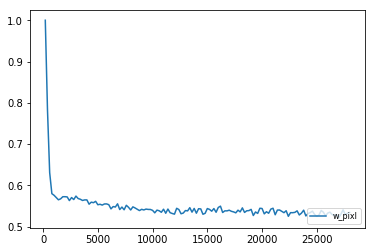

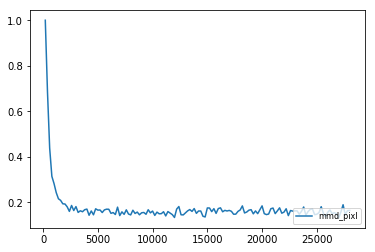

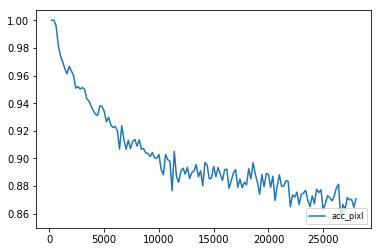

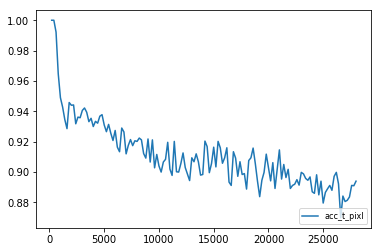

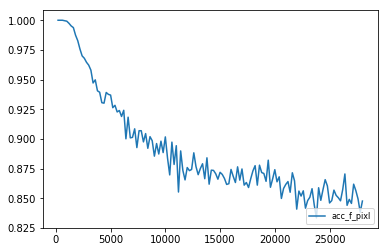

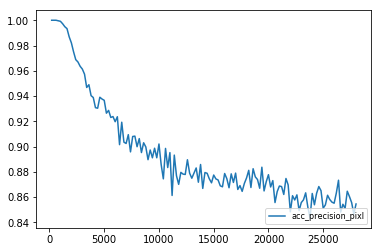

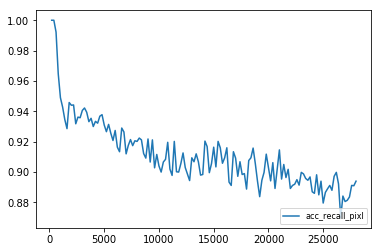

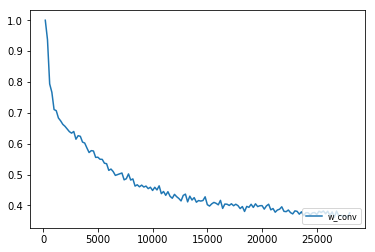

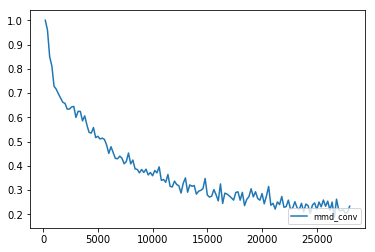

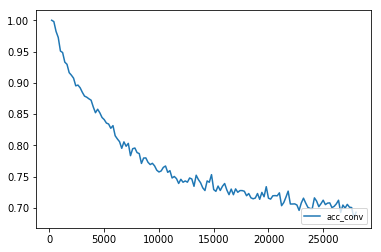

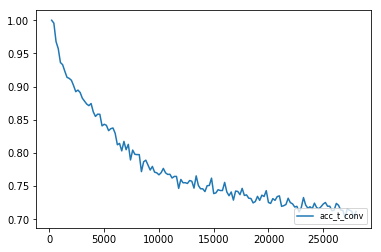

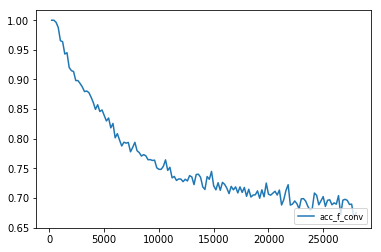

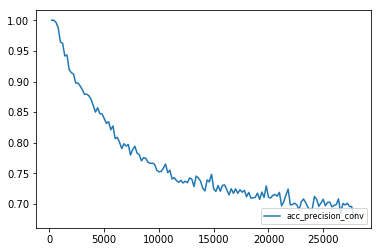

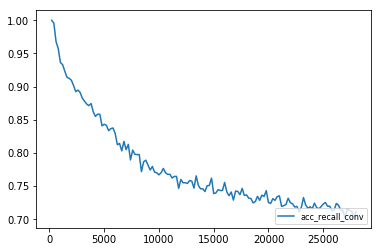

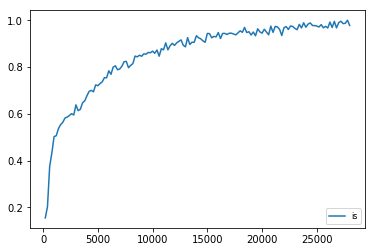

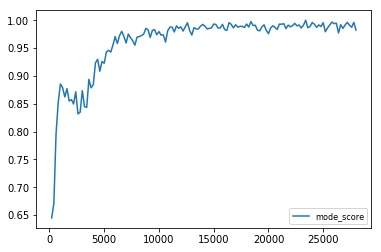

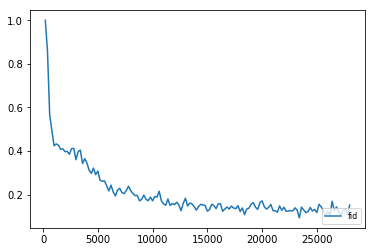

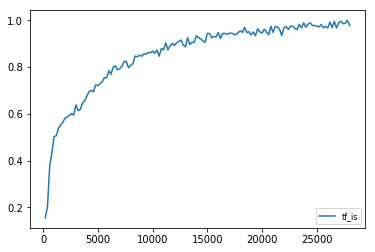

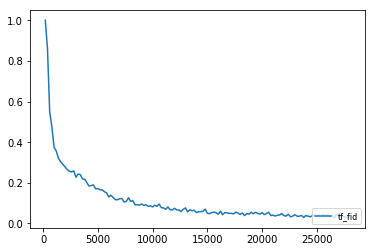

In [10]:

import torch.utils.data as Data

from keras.datasets import mnist,fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K
import os
import matplotlib.pyplot as plt

import numpy as np

class BIGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        self.x = []
        self.y = np.zeros((31, 1), dtype=np.int)
        self.y = list(self.y)
        for i in range(31):
            self.y[i] = []

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # Build the encoder
        self.encoder = self.build_encoder()

        # The part of the bigan that trains the discriminator and encoder
        self.discriminator.trainable = False

        # Generate image from sampled noise
        z = Input(shape=(self.latent_dim, ))
        img_ = self.generator(z)

        # Encode image
        img = Input(shape=self.img_shape)
        z_ = self.encoder(img)

        # Latent -> img is fake, and img -> latent is valid
        fake = self.discriminator([z, img_])
        valid = self.discriminator([z_, img])

        # Set up and compile the combined model
        # Trains generator to fool the discriminator
        self.bigan_generator = Model([z, img], [fake, valid])
        self.bigan_generator.compile(loss=['binary_crossentropy', 'binary_crossentropy'],
            optimizer=optimizer)


    def build_encoder(self):
        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(self.latent_dim))

        model.summary()

        img = Input(shape=self.img_shape)
        z = model(img)

        return Model(img, z)

    def build_generator(self):
        model = Sequential()

        model.add(Dense(512, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        z = Input(shape=(self.latent_dim,))
        gen_img = model(z)

        return Model(z, gen_img)

    def build_discriminator(self):

        z = Input(shape=(self.latent_dim, ))
        img = Input(shape=self.img_shape)
        d_in = concatenate([z, Flatten()(img)])

        model = Dense(1024)(d_in)
        model = LeakyReLU(alpha=0.2)(model)
        model = Dropout(0.5)(model)
        model = Dense(1024)(model)
        model = LeakyReLU(alpha=0.2)(model)
        model = Dropout(0.5)(model)
        model = Dense(1024)(model)
        model = LeakyReLU(alpha=0.2)(model)
        model = Dropout(0.5)(model)
        validity = Dense(1, activation="sigmoid")(model)

        return Model([z, img], validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (X_test, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        X_test = (X_test.astype(np.float32) - 127.5) / 127.5
        # X_test = X_test / 127.5 - 1.
        X_test = np.expand_dims(X_test, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        nb_batches = int(X_train.shape[0] / batch_size)
        global_step = 0

        for epoch in range(epochs):

            for index in range(nb_batches):
                global_step += 1
                image_batch = X_train[index * batch_size:(index + 1) * batch_size]
                z = np.random.normal(size=(batch_size, self.latent_dim))
                imgs_ = self.generator.predict(z)

                # Select a random batch of images and encode
                # idx = np.random.randint(0, X_train.shape[0], batch_size)
                # imgs = X_train[idx]
                z_ = self.encoder.predict(image_batch)

                # Train the discriminator (img -> z is valid, z -> img is fake)
                d_loss_real = self.discriminator.train_on_batch([z_, image_batch], valid)
                d_loss_fake = self.discriminator.train_on_batch([z, imgs_], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # ---------------------
                #  Train Generator
                # ---------------------

                # Train the generator (z -> img is valid and img -> z is is invalid)
                g_loss = self.bigan_generator.train_on_batch([z, image_batch], [valid, fake])

                # Plot the progress
                print("epoch:%d step:%d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (epoch,global_step, d_loss[0],
                                                                                   100 * d_loss[1], g_loss[0]))

                # If at save interval => save generated image samples
                sampleSize = 5000
                # If at save interval => save generated image samples
                if global_step % sample_interval == 0:
                    s = self.metrics(global_step, X_test, sampleSize)
        for i in range(len(s)):
            self.y[i] = [float(j) / max(self.y[i]) for j in self.y[i]]#对值进行归一化处理

        for i in range(len(s)):
            font1={'size':8}

            plt.plot(self.x, self.y[i], label=labels_name[i])
            plt.legend(loc='lower right',prop=font1)
            plt.savefig('saved_models_bigan/{}.png'.format(labels_name[i]))
            plt.show()
            plt.close()

    def metrics(self, epoch, X_test, sampleSize):
        self.x.append(epoch)
        r, c = 10, sampleSize // 10
        noise = np.random.normal(0, 1, (r * c, 100))
#         sampled_labels = np.array([num for _ in range(r) for num in range(c)])
        gen_imgs = self.generator.predict([noise])
        x_dataset = MyDataset(X_test[:sampleSize])
        # print(x_dataset[0].shape)
        x_real_loader = Data.DataLoader(dataset=x_dataset, batch_size=sampleSize, shuffle=True)
        x_fake_dataset = MyDataset(gen_imgs)
        x_fake_loader = Data.DataLoader(dataset=x_fake_dataset, batch_size=sampleSize, shuffle=True)
        s = compute_score_raw(x_real_loader, x_fake_loader, 256, '/real/', './fake', conv_model='tfgan',
                              workers=int(1))
        real_images = tf.convert_to_tensor(X_test)  # real images
#         # MNIST_CLASSIFIER_FROZEN_GRAPH = '.\classify_mnist_graph_def.pb'
        gen_imgs = np.array(gen_imgs)
        eval_images = tf.convert_to_tensor(gen_imgs)
        eval_score = utils.mnist_score(eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH)  # IS score
        frechet_distance = utils.mnist_frechet_distance(real_images, eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH)
        mnist_score, f_distance = sess.run([eval_score, frechet_distance])
        # print(mnist_score)
        # print(f_distance)
        # s[14]=mnist_score
        # s[16]=f_distance
        s[17] = mnist_score
        s[18] = f_distance
        print('IS socre: %f' % mnist_score)
        print('FID: %f' % f_distance)

        for i in range(len(s)):
            print(i, "=", s[i])
        for i in range(len(s)):
            self.y[i].append(s[i])
        f.writelines('\n')
        f.writelines('epoch:' + str(epoch))
        f.writelines('\n')
        f.writelines('%.8f' % (i) for i in s)
        f.writelines('\n')
        return s

if __name__ == '__main__':
    bigan = BIGAN()
    bigan.train(epochs=30, batch_size=64, sample_interval=200)
